This notebook is with final version of LION-tSNE tests.

Here LION-tSNE will be implemented right in the cells. After debugging here it will be moved to production code.

In [2]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import gridspec
import numpy as np
import lion_tsne
from importlib import reload
reload(lion_tsne)  # Rerun this cell after update of lion_tsne
import os
import pickle
%matplotlib inline
from scipy.spatial import distance

# MNIST Tests

Loading and applying transformations.

In [3]:
regenerate_mnist = False # Use only if necessary. Original tSNE run might take a while.

In [4]:
# If not pickled, or regeneration is explicitly requested, then we regenerate
mnist_file = 'mnist.p'

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

if not os.path.isfile(mnist_file) or regenerate_mnist:

    all_mnist_trained_images = mnist.train.images
    all_mnist_labels = mnist.train.labels
    
    np.random.seed(0)
    ind = np.random.choice(np.arange(len(mnist.train.images)), size = 2567) # For 0 random seed 2567 samples have
    #exactly 2500 unique ones
    mnist_chosen_indices = ind
    X_mnist_raw = mnist.train.images[ind]
    labels_mnist = mnist.train.labels[ind]

    temp = np.ascontiguousarray(X_mnist_raw).view(np.dtype((np.void, X_mnist_raw.dtype.itemsize * X_mnist_raw.shape[1])))
    _, un_idx = np.unique(temp, return_index=True)
    X_mnist_raw = X_mnist_raw[un_idx, :]
    labels_mnist = labels_mnist[un_idx]
    mnist_chosen_indices = mnist_chosen_indices[un_idx]

    mnist_pca = PCA(n_components=30)
    X_mnist = mnist_pca.fit_transform(X_mnist_raw)

    labels_mnist_onehot = labels_mnist
    labels_mnist = np.argmax(labels_mnist,axis=1)

    print("MNIST data reloaded")
    # Run TSNE
    dTSNE_mnist = lion_tsne.LionTSNE(perplexity=30)
    Y_mnist = dTSNE_mnist.fit(X_mnist, optimizer_kwargs={'momentum': 0.8, 'n_iter': 3000,
                                                         'early_exaggeration_iters' : 300}, random_seed=1, verbose=2)
    with open(mnist_file, 'wb') as f:
        pickle.dump((X_mnist_raw, dTSNE_mnist.P_matrix, dTSNE_mnist.sigma, Y_mnist, labels_mnist_onehot, mnist_pca,
                       all_mnist_trained_images, all_mnist_labels, mnist_chosen_indices), f)
else:
    with open(mnist_file, 'rb') as f:
        X_mnist_raw, P_mnist, sigma_mnist, Y_mnist, labels_mnist_onehot, mnist_pca,\
        all_mnist_trained_images, all_mnist_labels, mnist_chosen_indices = pickle.load(f)

    labels_mnist = np.argmax(labels_mnist_onehot,axis=1)
        
    temp = np.ascontiguousarray(X_mnist_raw).view(np.dtype((np.void, X_mnist_raw.dtype.itemsize * X_mnist_raw.shape[1])))
    _, un_idx = np.unique(temp, return_index=True)
    X_mnist_raw = X_mnist_raw[un_idx, :]
    labels_mnist = labels_mnist[un_idx]
    mnist_chosen_indices = mnist_chosen_indices[un_idx]
        
    X_mnist = mnist_pca.fit_transform(X_mnist_raw)
    dTSNE_mnist = lion_tsne.LionTSNE(perplexity=30)
    dTSNE_mnist.incorporate(x=X_mnist, y=Y_mnist, p_matrix=P_mnist, sigma=sigma_mnist)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
D = distance.pdist(X_mnist)
print("After PCA - minimum distance between samples is ", np.min(D))
# We want to have 2500 DISTINCT samples, even after PCA.
# Should be around 0.45 for the data I know.

After PCA - minimum distance between samples is  0.452286143031


In [6]:
#Here we manually correct for all examples that were mislabeled.
# Many were unclear, original label was unchanged if it even remotely fits.
# Fixing only if the label is obviously wrong
# labels_mnist[479] = 3 # Was 0. Picture is unclear, but definitely not 0. Almost certainly 3.
# 644 looks more like 2 than 7. But we keep, it can be 7.
# Whatever. Labeling seems correct. A few corner cases do not change things.

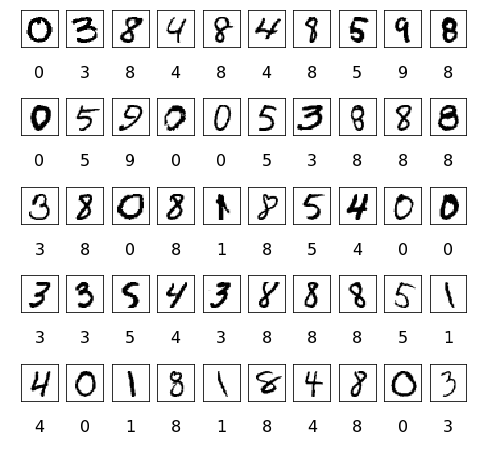

In [7]:
# Now we go through all 2500 samples one-by-one and correct mislabeling.
width = 10 #total number to show in one row
start_index = 1150

height = 10 # Number of rows /2 to show. half will go to labels, half to pictures.

f, ax = plt.subplots(height,width)
f.set_size_inches(8,8)
f.subplots_adjust()
for i in range(int(height/2)):
    for j in range(width):
        ax[2*i][j].imshow(X_mnist_raw[start_index + width*i + j,:].reshape(28,28), cmap='gray_r')
        ax[2*i+1][j].text(text=str(labels_mnist[start_index + width*i + j]),x=0.5, y=0.5,s=11,
                    ha='center', va='center', fontsize=16)
        ax[2*i][j].axes.get_xaxis().set_visible(False)
        ax[2*i][j].axes.get_yaxis().set_visible(False)
        ax[2*i+1][j].set_axis_off()
#f.subplots_adjust(left=-0.04, right=0.99, top=0.99,bottom=0.01)
plt.show(f)

In [8]:
from collections import Counter
Counter(labels_mnist)

Counter({0: 232,
         1: 274,
         2: 283,
         3: 248,
         4: 223,
         5: 218,
         6: 269,
         7: 286,
         8: 240,
         9: 227})

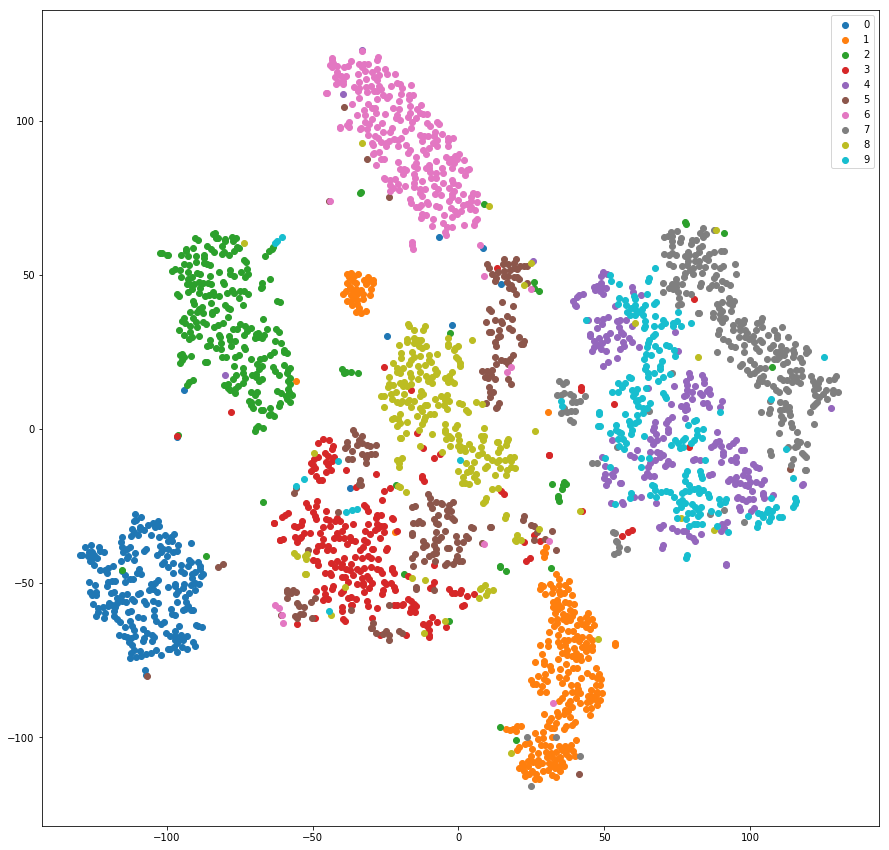

In [9]:
# That plot is just for my own reference 
plt.gcf().set_size_inches(15,15)
legend_list = list()
for l in set(sorted(labels_mnist)):
    plt.scatter(Y_mnist[labels_mnist == l, 0], Y_mnist[labels_mnist == l, 1], marker = 'o', alpha=1.0)
    legend_list.append(str(l))
#plt.title("MNIST Dataset - TSNE visualization")
#plt.tight_layout()
plt.legend(legend_list)
plt.show()

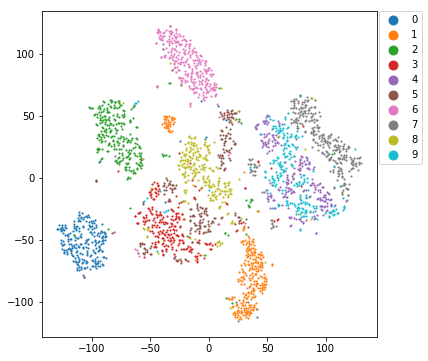

In [10]:
plt.gcf().set_size_inches(6,6) #Let's set the plot sizes that just fit paper margins 
legend_list = list()
for l in set(sorted(labels_mnist)):
    plt.scatter(Y_mnist[labels_mnist == l, 0], Y_mnist[labels_mnist == l, 1], marker = '.', s=5)
    legend_list.append(str(l))
#plt.title("MNIST Dataset - TSNE visualization")
#plt.tight_layout()
l = plt.legend(legend_list, bbox_to_anchor=(1.15, 1.015), markerscale=8)
plt.savefig("Figures/mnist_tsne_original.png",bbox_extra_artists=[l],bbox_inches='tight')
plt.show()

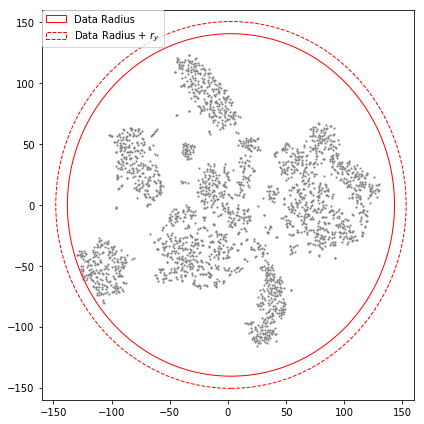

In [11]:
# Obsolete. For circular outlier placement.
f,ax = plt.subplots()

f.set_size_inches(6,6) #Let's set the plot sizes that just fit paper margins 
legend_list = list()
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], marker = '.', s=5, c='gray')
y_center = np.mean(Y_mnist, axis = 0) # Ususally centered, but theoretically does not have to
data_radius = np.max(np.sqrt(np.sum((Y_mnist-y_center)**2,axis=1)))
data_circle = plt.Circle((y_center[0],y_center[1]), data_radius, fill=None, color='red')
data_plus_r_circle = plt.Circle((y_center[0],y_center[1]), data_radius+10, fill=None, color='red', linestyle='--')
dc = ax.add_artist(data_circle)
dcr = ax.add_artist(data_plus_r_circle)
l = plt.legend([dc,dcr],["Data Radius","Data Radius + $r_y$"], loc=2, borderaxespad = 0)
ax.set_ylim([-160,160])
ax.set_xlim([-160,160])
f.tight_layout()
#f.savefig("OldFigures/circular_outlier_placement.png")
plt.show(f)

In [12]:
lion_toy_interp = dTSNE_mnist.generate_lion_tsne_embedder(verbose=0, random_state=0, function_kwargs={'y_safety_margin':0,
                                                                                                     'radius_y_percentile':100})

In [13]:
n_outl = 255
x_outl = np.zeros([n_outl, X_mnist.shape[1]])
np.random.seed(0)
for i in range(n_outl):
    n = np.random.choice(30,15)
    x_sample = np.array([-100]*X_mnist.shape[1]).reshape(1,-1)
    x_sample[0,n] = 100
    x_outl[i,:] = x_sample

In [14]:
y_outl = lion_toy_interp(x_outl, verbose=0) #Verbose 2 produce quite a bit of output. Verbose 3 produce a lot.

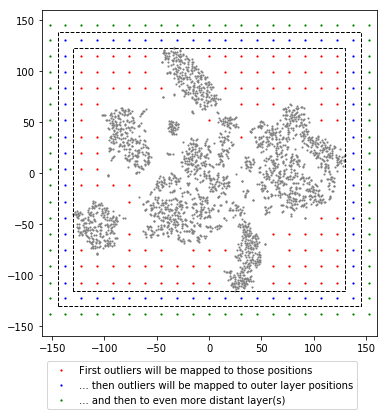

In [15]:
f,ax = plt.subplots()

f.set_size_inches(6,6) #Let's set the plot sizes that just fit paper margins 
legend_list = list()
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], marker = '.', s=5, c='gray')
#l = plt.legend([dc,dcr],["Data Radius","Data Radius + $r_y$"], loc=2, borderaxespad = 0)
#ax.plot(y_outl[:, 0], y_outl[:, 1], marker = '.', ms=5,linestyle=":", c='red')
n_o = 111
n_o_2 = 179
g1 = ax.scatter(y_outl[:n_o, 0], y_outl[:n_o, 1], marker = 'o', s=5,c='red', lw=0)
g2 = ax.scatter(y_outl[n_o:n_o_2, 0], y_outl[n_o:n_o_2, 1], marker = 'o', s=5,c='blue',lw=0)
g3 = ax.scatter(y_outl[n_o_2:, 0], y_outl[n_o_2:, 1], marker = 'o', s=5,c='green',lw=0)
ax.plot([min(Y_mnist[:, 0]), min(Y_mnist[:, 0]), max(Y_mnist[:, 0]), max(Y_mnist[:, 0]), min(Y_mnist[:, 0])],
        [min(Y_mnist[:, 1]), max(Y_mnist[:, 1]), max(Y_mnist[:, 1]), min(Y_mnist[:, 1]), min(Y_mnist[:, 1])],
        linestyle='--', c='black',lw=1)
ax.plot([min(Y_mnist[:, 0])-15, min(Y_mnist[:, 0])-15, max(Y_mnist[:, 0])+15, max(Y_mnist[:, 0])+15, min(Y_mnist[:, 0])-15],
        [min(Y_mnist[:, 1])-15, max(Y_mnist[:, 1])+15, max(Y_mnist[:, 1])+15, min(Y_mnist[:, 1])-15, min(Y_mnist[:, 1])-15],
        linestyle='--', c='black',lw=1)
ax.set_ylim([-160,160])
ax.set_xlim([-160,160])
# f.tight_layout()
l = plt.legend([g1,g2,g3],["First outliers will be mapped to those positions",
                       "... then outliers will be mapped to outer layer positions",
                       "... and then to even more distant layer(s)"],loc=6, bbox_to_anchor=[0.0,-0.15])
f.savefig("Figures/outlier_placement_example.png", bbox_extra_artists=[l],bbox_inches='tight')
plt.show(f)

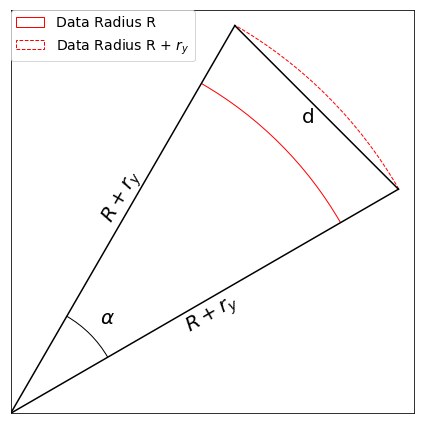

In [16]:
# OBSOLETE. Picture back from circular outlier placement.
from matplotlib import patches

f,ax = plt.subplots()

f.set_size_inches(6,6) #Let's set the plot sizes that just fit paper margins 
outer_arc = patches.Arc((0,0), 20, 20,  theta1=30, theta2=60, color='red', linestyle = '--')
outer_arc2 = patches.Arc((0,0), 17, 17,  theta1=30, theta2=60, color='red')
inner_arc = patches.Arc((0,0), 5, 5,  theta1=30, theta2=60, color='black')
oa = ax.add_artist(outer_arc)
oa2 = ax.add_artist(outer_arc2)
ia = ax.add_artist(inner_arc)
#ax.set_axis_off()
ax.plot([0,5],[0,8.65], c='black')
ax.plot([0,8.65],[0,5], c='black')
ax.plot([5,8.65],[8.65,5], c='black')
ax.text(2,2, '$\\alpha$',fontsize=20)
ax.text(6.5,6.5, 'd',fontsize=20)
ax.text(4.5,2.2, '$R + r_y$',fontsize=20, rotation=30, ha = 'center', va = 'center')
ax.text(2.5,4.85, '$R + r_y$',fontsize=20, rotation=60, ha = 'center', va = 'center')
l = ax.legend([oa2,oa],["Data Radius R","Data Radius R + $r_y$"], loc=2, borderaxespad = 0,fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_ylim([0,9])
ax.set_xlim([0,9])
f.tight_layout()
#f.savefig("Figures/outlier_angles.png")
plt.show(f)

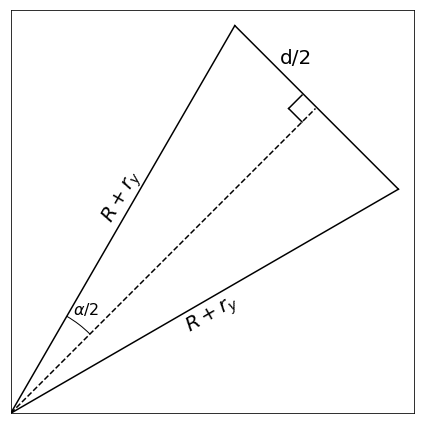

In [18]:
# OBSOLETE. Picture back from circular outlier placement.

f,ax = plt.subplots()

f.set_size_inches(6,6) #Let's set the plot sizes that just fit paper margins 
#outer_arc = patches.Arc((0,0), 20, 20,  theta1=30, theta2=60, color='red', linestyle = ':')
#outer_arc2 = patches.Arc((0,0), 17, 17,  theta1=30, theta2=60, color='red',linestyle = '--')
#outer_arc3 = patches.Arc((0,0), 15, 15,  theta1=30, theta2=60, color='red')
inner_arc = patches.Arc((0,0), 5, 5,  theta1=45, theta2=60, color='black')
#oa = ax.add_artist(outer_arc)
#oa2 = ax.add_artist(outer_arc2)
#oa3 = ax.add_artist(outer_arc3)
ia = ax.add_artist(inner_arc)
#ax.set_axis_off()
ax.plot([0,6.8],[0,6.8], c='black', linestyle='--')
ax.plot([6.5,6.2],[6.5,6.8], c='black')
ax.plot([6.2,6.5],[6.8,7.1], c='black')
ax.plot([0,5],[0,8.65], c='black')
ax.plot([0,8.65],[0,5], c='black')
ax.plot([5,8.65],[8.65,5], c='black')
ax.text(1.4,2.2, '$\\alpha$/2',fontsize=16)
ax.text(6,7.8, 'd/2',fontsize=20)
ax.text(4.5,2.2, '$R + r_y$',fontsize=20, rotation=30, ha = 'center', va = 'center')
ax.text(2.5,4.85, '$R + r_y$',fontsize=20, rotation=60, ha = 'center', va = 'center')
#l = ax.legend([oa3,oa2,oa],["R","R + $r_y$", "R + $r_y$ + SM"], loc=2, borderaxespad = 0,fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_ylim([0,9])
ax.set_xlim([0,9])
f.tight_layout()
#f.savefig("Figures/outlier_angles_counting.png")
plt.show(f)

In [19]:
y_center

array([ 2.62093585, -0.07274501])

In [50]:
# Generate all embedders etc.
emb_mnist_multiquadric = dTSNE_mnist.generate_embedding_function(embedding_function_type='rbf',
                                                                   function_kwargs={'function':'multiquadric'})
emb_mnist_linear = dTSNE_mnist.generate_embedding_function(embedding_function_type='rbf',
                                                                   function_kwargs={'function':'linear'})
emb_mnist_cubic = dTSNE_mnist.generate_embedding_function(embedding_function_type='rbf',
                                                                   function_kwargs={'function':'cubic'})
emb_mnist_quintic = dTSNE_mnist.generate_embedding_function(embedding_function_type='rbf',
                                                                   function_kwargs={'function':'quintic'})
emb_mnist_gaussian = dTSNE_mnist.generate_embedding_function(embedding_function_type='rbf',
                                                                   function_kwargs={'function':'gaussian'})
emb_mnist_inverse = dTSNE_mnist.generate_embedding_function(embedding_function_type='rbf',
                                                                   function_kwargs={'function':'inverse'})
emb_mnist_thin_plate = dTSNE_mnist.generate_embedding_function(embedding_function_type='rbf',
                                                                   function_kwargs={'function':'thin-plate'})
emb_mnist_idw20 = dTSNE_mnist.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                                                   function_kwargs={'power':20})
emb_mnist_idw10 = dTSNE_mnist.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                                                   function_kwargs={'power':10})
emb_mnist_idw_optimal = dTSNE_mnist.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                                                   function_kwargs={'power':27.9})
emb_mnist_idw1 = dTSNE_mnist.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                                                   function_kwargs={'power':1})
emb_mnist_idw40 = dTSNE_mnist.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                                                   function_kwargs={'power':40})

In [ ]:
# Here is what happens if we straightforwardly incorporate new data:
# TODO

## MNIST - Continuity Test

In [23]:
# Find nearest neighbors after PCA. That way we remove the influence of PCA on accuracy of interpolation.

# We pick 10 random training points for which there exists a neighbor in not chosen incides, and that neighbor is closer to
ind_unchosen = [i for i in range(len(all_mnist_labels)) if i not in mnist_chosen_indices]
np.random.seed(10) # Any seed, just don't use it again for selecting indices from same dataset

X_mnist_unchosen_raw = mnist.train.images[ind_unchosen]
labels_mnist_unchosen = mnist.train.labels[ind_unchosen]
labels_mnist_unchosen = np.argmax(labels_mnist_unchosen,axis=1)

X_mnist_unchosen_pca = mnist_pca.transform(X_mnist_unchosen_raw)

ind_to_pick = 1000
displayed_neighbors = 10

In [25]:
picked_indices = list()
chosen_labels = list()
nearest_training_indices = list()
picked_neighbors = np.zeros((ind_to_pick, X_mnist.shape[1]))
picked_neighbor_labels = list()
picked_neighbors_raw = np.zeros((ind_to_pick, X_mnist_raw.shape[1]))

remaining_indices = list(np.arange(len(mnist_chosen_indices)))
while (len(picked_indices) < ind_to_pick)and(len(remaining_indices) > 0):
    chosen_index = np.random.choice(remaining_indices, 1)
    remaining_indices.remove(chosen_index)
    
    #Without PCA
    #chosen_raw_value = X_mnist_raw[chosen_index, :]    
    #distances_in_training_samples = np.sum((X_mnist_raw - chosen_raw_value)**2, axis=1)
    # With PCA
    chosen_value = X_mnist[chosen_index, :]    
    distances_in_training_samples = np.sum((X_mnist - chosen_value)**2, axis=1)
    
    distances_in_training_samples[distances_in_training_samples == 0] = np.infty # We don't need training sample itself
    closest_in_training_samples = np.argmin(distances_in_training_samples)
    closest_distance_in_training_samples = np.min(distances_in_training_samples)    
    
    #Without PCA
    #distances_to_unchosen = np.sum((X_mnist_unchosen_raw - chosen_value)**2, axis=1)
    #With PCA
    distances_to_unchosen = np.sum((X_mnist_unchosen_pca - chosen_value)**2, axis=1)
    
    distances_to_unchosen[distances_to_unchosen==0] = np.infty # We don't need exactly the same samples    
    if np.min(distances_to_unchosen) < closest_distance_in_training_samples:
        picked_neighbors_raw[len(picked_indices), :] = X_mnist_unchosen_raw[np.argmin(distances_to_unchosen), :]
        picked_neighbors[len(picked_indices), :] = X_mnist_unchosen_pca[np.argmin(distances_to_unchosen), :]
        picked_indices.append(chosen_index[0])
        chosen_labels.append(labels_mnist[chosen_index[0]])
        picked_neighbor_labels.append(labels_mnist_unchosen[np.argmin(distances_to_unchosen)])
        nearest_training_indices.append(closest_in_training_samples)
        #print("\tFound neighbor")
    else:
        #print("\tNothing closer than one of training samples")
        pass
    
print(picked_indices)
print(nearest_training_indices)

[1289, 527, 1346, 1181, 2013, 734, 1525, 1955, 2050, 1034, 1100, 2315, 40, 2432, 1561, 357, 240, 2460, 2117, 578, 1233, 980, 1728, 78, 13, 414, 1422, 661, 1383, 92, 1851, 288, 97, 80, 2488, 404, 1718, 1260, 2096, 643, 1446, 1482, 1179, 812, 46, 2094, 2164, 1919, 1881, 1417, 2388, 2232, 1298, 1585, 798, 493, 65, 1567, 2290, 1658, 2475, 241, 2423, 768, 2014, 938, 1584, 1399, 1697, 1132, 808, 710, 948, 1434, 1296, 2208, 278, 1575, 298, 418, 1053, 2253, 694, 1431, 209, 2058, 1847, 396, 556, 466, 371, 960, 1150, 2196, 1682, 530, 1448, 1116, 1460, 2102, 1853, 481, 2126, 1730, 956, 2042, 1846, 712, 361, 1685, 2490, 434, 1338, 917, 1202, 1031, 2367, 1299, 1086, 1447, 581, 363, 111, 820, 1357, 159, 2197, 1635, 1269, 1832, 2332, 1565, 398, 2313, 2441, 1624, 2155, 664, 691, 463, 684, 2408, 2158, 356, 1950, 719, 2357, 49, 2077, 1629, 373, 1555, 1690, 930, 634, 488, 1203, 702, 59, 2062, 1973, 2195, 1385, 128, 1515, 967, 1314, 394, 2173, 2073, 595, 708, 333, 223, 1703, 139, 1326, 494, 470, 1452, 149

In [26]:
shown_indices = 10

In [27]:
# TODO Closest training sample on raw dataset

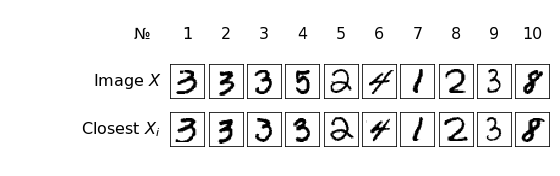

In [28]:
width = shown_indices #total number to show
start_index = 0

gs = gridspec.GridSpec(3, width+1, width_ratios=[4]+[1]*width) 

f, ax_total = plt.subplots(7,width+1)
f.set_size_inches(7,2)
f.subplots_adjust()
for i in range(width):
    ax = [plt.subplot(gs[i+1]), plt.subplot(gs[width+i+2]), plt.subplot(gs[2*width+i+3])]
    ax[0].text(text=str(i+1),x=0.5, y=0.5,s=11, ha='center', va='center', fontsize=16)    
    ax[1].imshow(picked_neighbors_raw[i,:].reshape(28,28), cmap='gray_r')
    ax[2].imshow(X_mnist_raw[picked_indices[i], :].reshape(28,28), cmap='gray_r')
    
    ax[0].set_axis_off()
    #Set_axis_off does not fit. I want a bounding box.
    ax[1].axes.get_xaxis().set_visible(False)
    ax[2].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)
    ax[2].axes.get_yaxis().set_visible(False)
plt.subplot(gs[0]).set_axis_off()
plt.subplot(gs[0]).text(text="№   ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)
plt.subplot(gs[width+1]).set_axis_off()
plt.subplot(gs[width+1]).text(text="Image $X$  ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)
plt.subplot(gs[2*width+2]).set_axis_off()
plt.subplot(gs[2*width+2]).text(text="Closest $X_i$  ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)
#gs.tight_layout(f)
gs.update(wspace=0.1, hspace=0.025)
f.subplots_adjust(left=-0.04, right=0.99, top=0.99,bottom=0.01)

plt.show(f)
f.savefig("Figures/nearest_neighbors_hor.png")

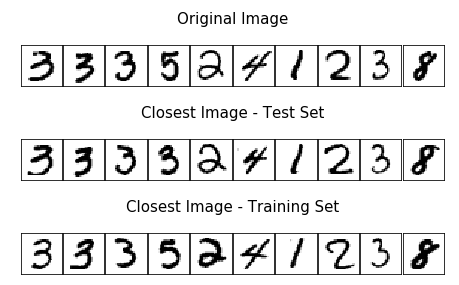

In [29]:
# TODO How to incorporate indices and original labels properly?

# In the paper we are very limited in X-axis and not so limited on Y-axis
# Let's get vertical version of the same plot.
f, ax_total = plt.subplots()
height_r = 5
vert_gridspec = gridspec.GridSpec(6,1, height_ratios=[1,height_r,1,height_r,1,height_r])
f.set_size_inches(6,4)
f.subplots_adjust()

vert_gridspec.update(hspace=0.001)

plt.subplot(vert_gridspec[0]).set_axis_off()
plt.subplot(vert_gridspec[2]).set_axis_off()
plt.subplot(vert_gridspec[4]).set_axis_off()
plt.subplot(vert_gridspec[0]).text(text="Original Image",x=0.5, y=0.0,s=11, ha='center', va='bottom', fontsize=15)
plt.subplot(vert_gridspec[2]).text(text="Closest Image - Test Set",x=0.5, y=0.0,s=11, va='bottom', ha='center', fontsize=15)
plt.subplot(vert_gridspec[4]).text(text="Closest Image - Training Set",x=0.5, y=0.0,s=11, va='bottom', ha='center', fontsize=15)

wsp = 0.025

inner_gridspec_original = gridspec.GridSpecFromSubplotSpec(1, shown_indices, subplot_spec=vert_gridspec[1],
                                                          wspace=wsp)
inner_gridspec_test = gridspec.GridSpecFromSubplotSpec(1, shown_indices, subplot_spec=vert_gridspec[3],
                                                          wspace=wsp)
inner_gridspec_training = gridspec.GridSpecFromSubplotSpec(1, shown_indices, subplot_spec=vert_gridspec[5],
                                                          wspace=wsp)

for i in range(shown_indices):
    orig_subplot = plt.subplot(inner_gridspec_original[i])
    test_subplot = plt.subplot(inner_gridspec_test[i])
    training_subplot = plt.subplot(inner_gridspec_training[i])
    orig_subplot.imshow(picked_neighbors_raw[i,:].reshape(28,28), cmap='gray_r')
    test_subplot.imshow(X_mnist_raw[picked_indices[i], :].reshape(28,28), cmap='gray_r')
    training_subplot.imshow(X_mnist_raw[nearest_training_indices[i],:].reshape(28,28), cmap='gray_r')
    orig_subplot.axes.get_xaxis().set_visible(False)
    test_subplot.axes.get_xaxis().set_visible(False)
    training_subplot.axes.get_xaxis().set_visible(False)
    orig_subplot.axes.get_yaxis().set_visible(False)
    test_subplot.axes.get_yaxis().set_visible(False)
    training_subplot.axes.get_yaxis().set_visible(False)
#gs.tight_layout(f)
f.subplots_adjust(left=0.01, right=0.99, top=0.99,bottom=0.01)

plt.show(f)
f.savefig("Figures/nearest_neighbors_vert.png")

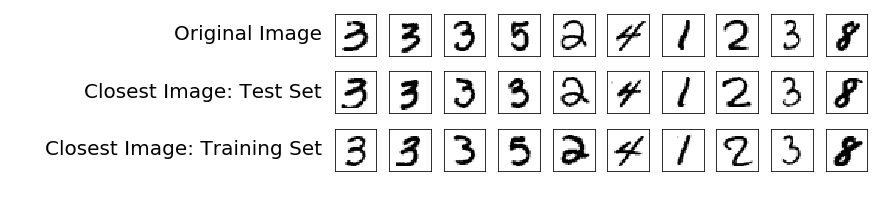

In [30]:
# Previous figure - big version.

gs = gridspec.GridSpec(3, shown_indices+1, width_ratios=[7]+[1]*shown_indices) 

f, ax_total = plt.subplots(3,shown_indices+1)
f.set_size_inches(15,3)
f.subplots_adjust()
for i in range(shown_indices):
    ax = [plt.subplot(gs[i+1]), plt.subplot(gs[shown_indices+i+2]), plt.subplot(gs[2*shown_indices+i+3])]
    ax[0].imshow(picked_neighbors_raw[i,:].reshape(28,28), cmap='gray_r')
    ax[1].imshow(X_mnist_raw[picked_indices[i], :].reshape(28,28), cmap='gray_r')
    ax[2].imshow(X_mnist_raw[nearest_training_indices[i],:].reshape(28,28), cmap='gray_r')
    ax[0].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_xaxis().set_visible(False)
    ax[2].axes.get_xaxis().set_visible(False)
    ax[0].axes.get_yaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)
    ax[2].axes.get_yaxis().set_visible(False)
plt.subplot(gs[0]).set_axis_off()
plt.subplot(gs[0]).text(text="Original Image",x=1.0, y=0.4,s=11, fontsize=20, ha='right')
plt.subplot(gs[shown_indices+1]).set_axis_off()
plt.subplot(gs[shown_indices+1]).text(text="Closest Image: Test Set",x=1.0, y=0.4,s=10, fontsize=20, ha='right')
plt.subplot(gs[2*shown_indices+2]).set_axis_off()
plt.subplot(gs[2*shown_indices+2]).text(text="Closest Image: Training Set",x=1.0, y=0.4,s=10, fontsize=20, ha='right')

plt.show(f)
f.savefig("Figures/nearest_neighbors_big.png")

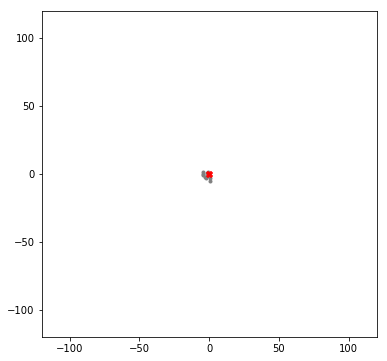

In [31]:
# Finds indices of nearest neighbors in Y space
# Just to make things easier.
def get_nearest_neighbors_in_y(y, n=10):
    y_distances = np.sum((Y_mnist - y)**2, axis=1)
    return np.argsort(y_distances)[:n]

# Let's test it  
y_test = [0,0]
ind = get_nearest_neighbors_in_y(y_test,10)

f, ax = plt.subplots()
f.set_size_inches(6,6)

plots_for_legend_list = list()
ax.scatter(Y_mnist[ind, 0], Y_mnist[ind, 1], c= 'gray', zorder=1, label=None, marker='.')
ax.scatter(y_test[0], y_test[1], c='red', marker = 'X')
plt.xlim([-120,120])
plt.ylim([-120,120])

plt.show(f)

In [34]:
accuracy_nn = 10
illustration_nn = accuracy_nn
# 10 works well for illustration and for accuracy counting.

In [60]:
#picked_neighbors_mnist_pca = mnist_pca.transform(picked_neighbors)
#It takes a while. Let's pickle.

cluster_results_file = 'clustering_results.p'
regenerate_cluster_results = False

picked_indices_y_mnist = Y_mnist[picked_indices, :]
picked_closest_training_indices_y_mnist = Y_mnist[nearest_training_indices, :]

if os.path.isfile(cluster_results_file) and not regenerate_cluster_results:
    print("Results file found. Loading...")
    with open(cluster_results_file, 'rb') as f:
        picked_neighbors_y_multiquadric, picked_neighbors_y_cubic, picked_neighbors_y_linear, \
        picked_neighbors_y_quintic, picked_neighbors_y_gaussian, picked_neighbors_y_inverse, \
        picked_neighbors_y_thin_plate, picked_neighbors_y_idw1, picked_neighbors_y_idw10, \
        picked_neighbors_y_idw20, picked_neighbors_y_idw_optimal, picked_neighbors_y_idw40 = pickle.load(f)
else:
    print("No results file or regenerate requested")
    picked_neighbors_y_multiquadric = emb_mnist_multiquadric(picked_neighbors)
    print("Got multiquadric")
    picked_neighbors_y_cubic = emb_mnist_cubic(picked_neighbors)
    print("Got cubic")
    picked_neighbors_y_linear = emb_mnist_linear(picked_neighbors)
    print("Got linear")
    picked_neighbors_y_quintic = emb_mnist_quintic(picked_neighbors)
    print("Got quintic")
    picked_neighbors_y_gaussian = emb_mnist_gaussian(picked_neighbors)
    print("Got Gaussian")
    picked_neighbors_y_inverse = emb_mnist_inverse(picked_neighbors)
    print("Got inverse")
    picked_neighbors_y_thin_plate = emb_mnist_thin_plate(picked_neighbors)
    print("Got thin plate")
    picked_neighbors_y_idw1 = emb_mnist_idw1(picked_neighbors)
    print("Got IDW1")
    picked_neighbors_y_idw20 = emb_mnist_idw20(picked_neighbors)
    print("Got IDW20")
    picked_neighbors_y_idw_optimal = emb_mnist_idw_optimal(picked_neighbors)
    print("Got IDW optimal")
    picked_neighbors_y_idw40 = emb_mnist_idw40(picked_neighbors)
    print("Got IDW 40")
    picked_neighbors_y_idw10 = emb_mnist_idw10(picked_neighbors)
    print("Got IDW 10")
    with open(cluster_results_file, 'wb') as f:
        pickle.dump((picked_neighbors_y_multiquadric, picked_neighbors_y_cubic, picked_neighbors_y_linear, \
        picked_neighbors_y_quintic, picked_neighbors_y_gaussian, picked_neighbors_y_inverse, \
        picked_neighbors_y_thin_plate, picked_neighbors_y_idw1, picked_neighbors_y_idw10, \
        picked_neighbors_y_idw20, picked_neighbors_y_idw_optimal, picked_neighbors_y_idw40), f)    
    print("Saved")

No results file or regenerate requested
Got multiquadric
Got cubic
Got linear
Got quintic
Got Gaussian
Got inverse
Got thin plate
Got IDW1
Got IDW20
Got IDW optimal
Got IDW 40
Got IDW 10
Saved


In [ ]:
#lion_interp_1 = dTSNE_mnist.generate_lion_tsne_embedder(verbose=3, random_state=0, function_kwargs={
#    'radius_x_percentile':99,
#    'radius_y_percentile':100,
#    'power': 1})
#lion_interp_2 = dTSNE_mnist.generate_lion_tsne_embedder(verbose=3, random_state=0, function_kwargs={
#    'radius_x_percentile':99,
#    'radius_y_percentile':100,
#    'power': 2})
#lion_interp_10 = dTSNE_mnist.generate_lion_tsne_embedder(verbose=3, random_state=0, function_kwargs={
#    'radius_x_percentile':99,
#    'radius_y_percentile':100,
#    'power': 10})

In [121]:
# Leaving it extensible to get smth like "KL vs power" etc. if we need to.
regenerate_lion_accuracy = False

lion_power_options = np.arange(0.1, 50.1, step=0.1)
lion_percentile_options = [90,95,99,100]
lion_power_plot_data_file = 'lion_power_plot_data.p'
lion_power_plot_data = dict() # Start from scratch

distance_matrix = distance.squareform(distance.pdist(X_mnist))
np.fill_diagonal(distance_matrix, np.inf)  # We are not interested in distance to itself
nn_x_distance = np.min(distance_matrix, axis=1)  # Any axis will do
radius_x = dict()
for p in lion_percentile_options:
    radius_x[p] = np.percentile(nn_x_distance, p)
print(radius_x)

skip_accuracy = False
recalculate_performance = False

if os.path.isfile(lion_power_plot_data_file) and not regenerate_lion_accuracy:
    with open(lion_power_plot_data_file, 'rb') as f:
        lion_power_plot_data = pickle.load(f)

for perc in lion_percentile_options:
    for p in lion_power_options:
        print("Processing percentile and power", p, perc)
        key = str(perc)+";"+"%.3f"%(p)
        print(key)
        if key not in lion_power_plot_data:
            lion_power_plot_data[key] = dict()

        if 'Accuracy' not in lion_power_plot_data[key] and not skip_accuracy:
            print("Accuracy not found for power ",p," percentile",perc,"\tCalculating...")
            interpolator = dTSNE_mnist.generate_lion_tsne_embedder(verbose=0, random_state=0, function_kwargs={
                        'radius_x_percentile':perc,
                        'power': p})            
            
            per_sample_accuracy = np.zeros((len(picked_neighbors),))
            for i in range(len(picked_neighbors)):
                #if i%100==0:
                #    print("\tPower: ",p,"Processing:",i)
                expected_label = picked_neighbor_labels[i]
                result = interpolator(picked_neighbors[i],verbose=0)
                nn_indices = get_nearest_neighbors_in_y(result, n=accuracy_nn)
                obtained_labels = labels_mnist[nn_indices]
                per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
            cur_acc = np.mean(per_sample_accuracy)
            #print('================= ',p,perc, cur_acc)
            lion_power_plot_data[key]['Accuracy'] = cur_acc
            with open(lion_power_plot_data_file, 'wb') as f:
                 pickle.dump(lion_power_plot_data, f)

        if 'PowerSquareDist' not in lion_power_plot_data[key] or recalculate_performance:
            print("Power performance not found for power ",p," percentile",perc,"\tCalculating...")
            
            y_sum_square_dist = 0.0
            y_sum_abs_dist = 0.0
            y_count = 0.0
            for i in range(len(X_mnist)):
                distances = distance_matrix[i,:].copy()
                distances[i] = np.inf #Not interested in distance to itself
                # Step 1. Find nearest neighbors in the neighborhood.
                neighbor_indices = np.where(distances <= radius_x[perc])[0]
                num_neighbors = len(neighbor_indices)
                if num_neighbors >= 2: # Below 2? Cannot interpolate
                    # We are good
                    weights = 1 / distances[neighbor_indices] ** p
                    weights = weights / np.sum(weights)
                    cur_y_result = weights.dot(Y_mnist[neighbor_indices,:])
                    y_sum_square_dist += np.sum(cur_y_result - Y_mnist[i,:])**2
                    y_sum_abs_dist += np.sqrt(np.sum(cur_y_result - Y_mnist[i,:])**2)
                    y_count += 1.0
            new_dict = dict() 
            new_dict['PowerSquareDist'] = y_sum_square_dist / y_count
            new_dict['PowerAbsDist'] = y_sum_abs_dist / y_count
            # Just in case it will become unstable due to too few neighbors
            new_dict['PowerSquareDistSum'] = y_sum_square_dist
            new_dict['PowerSquareDistCount'] = y_count
            lion_power_plot_data[key] = new_dict
            
            with open(lion_power_plot_data_file, 'wb') as f:
                 pickle.dump(lion_power_plot_data, f)

{90: 4.4519202916244023, 99: 5.5147221375046396, 100: 6.5381001908062197, 95: 4.794539444353707}
Processing percentile and power 0.1 90
90;0.100
Processing percentile and power 0.2 90
90;0.200
Processing percentile and power 0.3 90
90;0.300
Processing percentile and power 0.4 90
90;0.400
Processing percentile and power 0.5 90
90;0.500
Processing percentile and power 0.6 90
90;0.600
Processing percentile and power 0.7 90
90;0.700
Processing percentile and power 0.8 90
90;0.800
Processing percentile and power 0.9 90
90;0.900
Processing percentile and power 1.0 90
90;1.000
Processing percentile and power 1.1 90
90;1.100
Processing percentile and power 1.2 90
90;1.200
Processing percentile and power 1.3 90
90;1.300
Processing percentile and power 1.4 90
90;1.400
Processing percentile and power 1.5 90
90;1.500
Processing percentile and power 1.6 90
90;1.600
Processing percentile and power 1.7 90
90;1.700
Processing percentile and power 1.8 90
90;1.800
Processing percentile and power 1.9 90


Processing percentile and power 8.9 90
90;8.900
Accuracy not found for power  8.9  percentile 90 	Calculating...
Processing percentile and power 9.0 90
90;9.000
Accuracy not found for power  9.0  percentile 90 	Calculating...
Processing percentile and power 9.1 90
90;9.100
Accuracy not found for power  9.1  percentile 90 	Calculating...
Processing percentile and power 9.2 90
90;9.200
Accuracy not found for power  9.2  percentile 90 	Calculating...
Processing percentile and power 9.3 90
90;9.300
Accuracy not found for power  9.3  percentile 90 	Calculating...
Processing percentile and power 9.4 90
90;9.400
Accuracy not found for power  9.4  percentile 90 	Calculating...
Processing percentile and power 9.5 90
90;9.500
Accuracy not found for power  9.5  percentile 90 	Calculating...
Processing percentile and power 9.6 90
90;9.600
Accuracy not found for power  9.6  percentile 90 	Calculating...
Processing percentile and power 9.7 90
90;9.700
Accuracy not found for power  9.7  percentile 90

Processing percentile and power 16.0 90
90;16.000
Accuracy not found for power  16.0  percentile 90 	Calculating...
Processing percentile and power 16.1 90
90;16.100
Accuracy not found for power  16.1  percentile 90 	Calculating...
Processing percentile and power 16.2 90
90;16.200
Accuracy not found for power  16.2  percentile 90 	Calculating...
Processing percentile and power 16.3 90
90;16.300
Accuracy not found for power  16.3  percentile 90 	Calculating...
Processing percentile and power 16.4 90
90;16.400
Accuracy not found for power  16.4  percentile 90 	Calculating...
Processing percentile and power 16.5 90
90;16.500
Accuracy not found for power  16.5  percentile 90 	Calculating...
Processing percentile and power 16.6 90
90;16.600
Accuracy not found for power  16.6  percentile 90 	Calculating...
Processing percentile and power 16.7 90
90;16.700
Accuracy not found for power  16.7  percentile 90 	Calculating...
Processing percentile and power 16.8 90
90;16.800
Accuracy not found for

Processing percentile and power 23.1 90
90;23.100
Accuracy not found for power  23.1  percentile 90 	Calculating...
Processing percentile and power 23.2 90
90;23.200
Accuracy not found for power  23.2  percentile 90 	Calculating...
Processing percentile and power 23.3 90
90;23.300
Accuracy not found for power  23.3  percentile 90 	Calculating...
Processing percentile and power 23.4 90
90;23.400
Accuracy not found for power  23.4  percentile 90 	Calculating...
Processing percentile and power 23.5 90
90;23.500
Accuracy not found for power  23.5  percentile 90 	Calculating...
Processing percentile and power 23.6 90
90;23.600
Accuracy not found for power  23.6  percentile 90 	Calculating...
Processing percentile and power 23.7 90
90;23.700
Accuracy not found for power  23.7  percentile 90 	Calculating...
Processing percentile and power 23.8 90
90;23.800
Accuracy not found for power  23.8  percentile 90 	Calculating...
Processing percentile and power 23.9 90
90;23.900
Accuracy not found for

Processing percentile and power 30.2 90
90;30.200
Accuracy not found for power  30.2  percentile 90 	Calculating...
Processing percentile and power 30.3 90
90;30.300
Accuracy not found for power  30.3  percentile 90 	Calculating...
Processing percentile and power 30.4 90
90;30.400
Accuracy not found for power  30.4  percentile 90 	Calculating...
Processing percentile and power 30.5 90
90;30.500
Accuracy not found for power  30.5  percentile 90 	Calculating...
Processing percentile and power 30.6 90
90;30.600
Accuracy not found for power  30.6  percentile 90 	Calculating...
Processing percentile and power 30.7 90
90;30.700
Accuracy not found for power  30.7  percentile 90 	Calculating...
Processing percentile and power 30.8 90
90;30.800
Accuracy not found for power  30.8  percentile 90 	Calculating...
Processing percentile and power 30.9 90
90;30.900
Accuracy not found for power  30.9  percentile 90 	Calculating...
Processing percentile and power 31.0 90
90;31.000
Accuracy not found for

Processing percentile and power 37.3 90
90;37.300
Accuracy not found for power  37.3  percentile 90 	Calculating...
Processing percentile and power 37.4 90
90;37.400
Accuracy not found for power  37.4  percentile 90 	Calculating...
Processing percentile and power 37.5 90
90;37.500
Accuracy not found for power  37.5  percentile 90 	Calculating...
Processing percentile and power 37.6 90
90;37.600
Accuracy not found for power  37.6  percentile 90 	Calculating...
Processing percentile and power 37.7 90
90;37.700
Accuracy not found for power  37.7  percentile 90 	Calculating...
Processing percentile and power 37.8 90
90;37.800
Accuracy not found for power  37.8  percentile 90 	Calculating...
Processing percentile and power 37.9 90
90;37.900
Accuracy not found for power  37.9  percentile 90 	Calculating...
Processing percentile and power 38.0 90
90;38.000
Accuracy not found for power  38.0  percentile 90 	Calculating...
Processing percentile and power 38.1 90
90;38.100
Accuracy not found for

Processing percentile and power 44.4 90
90;44.400
Accuracy not found for power  44.4  percentile 90 	Calculating...
Processing percentile and power 44.5 90
90;44.500
Accuracy not found for power  44.5  percentile 90 	Calculating...
Processing percentile and power 44.6 90
90;44.600
Accuracy not found for power  44.6  percentile 90 	Calculating...
Processing percentile and power 44.7 90
90;44.700
Accuracy not found for power  44.7  percentile 90 	Calculating...
Processing percentile and power 44.8 90
90;44.800
Accuracy not found for power  44.8  percentile 90 	Calculating...
Processing percentile and power 44.9 90
90;44.900
Accuracy not found for power  44.9  percentile 90 	Calculating...
Processing percentile and power 45.0 90
90;45.000
Accuracy not found for power  45.0  percentile 90 	Calculating...
Processing percentile and power 45.1 90
90;45.100
Accuracy not found for power  45.1  percentile 90 	Calculating...
Processing percentile and power 45.2 90
90;45.200
Accuracy not found for

Processing percentile and power 1.5 95
95;1.500
Accuracy not found for power  1.5  percentile 95 	Calculating...
Processing percentile and power 1.6 95
95;1.600
Accuracy not found for power  1.6  percentile 95 	Calculating...
Processing percentile and power 1.7 95
95;1.700
Accuracy not found for power  1.7  percentile 95 	Calculating...
Processing percentile and power 1.8 95
95;1.800
Accuracy not found for power  1.8  percentile 95 	Calculating...
Processing percentile and power 1.9 95
95;1.900
Accuracy not found for power  1.9  percentile 95 	Calculating...
Processing percentile and power 2.0 95
95;2.000
Accuracy not found for power  2.0  percentile 95 	Calculating...
Processing percentile and power 2.1 95
95;2.100
Accuracy not found for power  2.1  percentile 95 	Calculating...
Processing percentile and power 2.2 95
95;2.200
Accuracy not found for power  2.2  percentile 95 	Calculating...
Processing percentile and power 2.3 95
95;2.300
Accuracy not found for power  2.3  percentile 95

Processing percentile and power 8.8 95
95;8.800
Accuracy not found for power  8.8  percentile 95 	Calculating...
Processing percentile and power 8.9 95
95;8.900
Accuracy not found for power  8.9  percentile 95 	Calculating...
Processing percentile and power 9.0 95
95;9.000
Accuracy not found for power  9.0  percentile 95 	Calculating...
Processing percentile and power 9.1 95
95;9.100
Accuracy not found for power  9.1  percentile 95 	Calculating...
Processing percentile and power 9.2 95
95;9.200
Accuracy not found for power  9.2  percentile 95 	Calculating...
Processing percentile and power 9.3 95
95;9.300
Accuracy not found for power  9.3  percentile 95 	Calculating...
Processing percentile and power 9.4 95
95;9.400
Accuracy not found for power  9.4  percentile 95 	Calculating...
Processing percentile and power 9.5 95
95;9.500
Accuracy not found for power  9.5  percentile 95 	Calculating...
Processing percentile and power 9.6 95
95;9.600
Accuracy not found for power  9.6  percentile 95

Processing percentile and power 15.9 95
95;15.900
Accuracy not found for power  15.9  percentile 95 	Calculating...
Processing percentile and power 16.0 95
95;16.000
Accuracy not found for power  16.0  percentile 95 	Calculating...
Processing percentile and power 16.1 95
95;16.100
Accuracy not found for power  16.1  percentile 95 	Calculating...
Processing percentile and power 16.2 95
95;16.200
Accuracy not found for power  16.2  percentile 95 	Calculating...
Processing percentile and power 16.3 95
95;16.300
Accuracy not found for power  16.3  percentile 95 	Calculating...
Processing percentile and power 16.4 95
95;16.400
Accuracy not found for power  16.4  percentile 95 	Calculating...
Processing percentile and power 16.5 95
95;16.500
Accuracy not found for power  16.5  percentile 95 	Calculating...
Processing percentile and power 16.6 95
95;16.600
Accuracy not found for power  16.6  percentile 95 	Calculating...
Processing percentile and power 16.7 95
95;16.700
Accuracy not found for

Processing percentile and power 23.0 95
95;23.000
Accuracy not found for power  23.0  percentile 95 	Calculating...
Processing percentile and power 23.1 95
95;23.100
Accuracy not found for power  23.1  percentile 95 	Calculating...
Processing percentile and power 23.2 95
95;23.200
Accuracy not found for power  23.2  percentile 95 	Calculating...
Processing percentile and power 23.3 95
95;23.300
Accuracy not found for power  23.3  percentile 95 	Calculating...
Processing percentile and power 23.4 95
95;23.400
Accuracy not found for power  23.4  percentile 95 	Calculating...
Processing percentile and power 23.5 95
95;23.500
Accuracy not found for power  23.5  percentile 95 	Calculating...
Processing percentile and power 23.6 95
95;23.600
Accuracy not found for power  23.6  percentile 95 	Calculating...
Processing percentile and power 23.7 95
95;23.700
Accuracy not found for power  23.7  percentile 95 	Calculating...
Processing percentile and power 23.8 95
95;23.800
Accuracy not found for

Processing percentile and power 30.1 95
95;30.100
Accuracy not found for power  30.1  percentile 95 	Calculating...
Processing percentile and power 30.2 95
95;30.200
Accuracy not found for power  30.2  percentile 95 	Calculating...
Processing percentile and power 30.3 95
95;30.300
Accuracy not found for power  30.3  percentile 95 	Calculating...
Processing percentile and power 30.4 95
95;30.400
Accuracy not found for power  30.4  percentile 95 	Calculating...
Processing percentile and power 30.5 95
95;30.500
Accuracy not found for power  30.5  percentile 95 	Calculating...
Processing percentile and power 30.6 95
95;30.600
Accuracy not found for power  30.6  percentile 95 	Calculating...
Processing percentile and power 30.7 95
95;30.700
Accuracy not found for power  30.7  percentile 95 	Calculating...
Processing percentile and power 30.8 95
95;30.800
Accuracy not found for power  30.8  percentile 95 	Calculating...
Processing percentile and power 30.9 95
95;30.900
Accuracy not found for

Processing percentile and power 37.2 95
95;37.200
Accuracy not found for power  37.2  percentile 95 	Calculating...
Processing percentile and power 37.3 95
95;37.300
Accuracy not found for power  37.3  percentile 95 	Calculating...
Processing percentile and power 37.4 95
95;37.400
Accuracy not found for power  37.4  percentile 95 	Calculating...
Processing percentile and power 37.5 95
95;37.500
Accuracy not found for power  37.5  percentile 95 	Calculating...
Processing percentile and power 37.6 95
95;37.600
Accuracy not found for power  37.6  percentile 95 	Calculating...
Processing percentile and power 37.7 95
95;37.700
Accuracy not found for power  37.7  percentile 95 	Calculating...
Processing percentile and power 37.8 95
95;37.800
Accuracy not found for power  37.8  percentile 95 	Calculating...
Processing percentile and power 37.9 95
95;37.900
Accuracy not found for power  37.9  percentile 95 	Calculating...
Processing percentile and power 38.0 95
95;38.000
Accuracy not found for

Processing percentile and power 44.3 95
95;44.300
Accuracy not found for power  44.3  percentile 95 	Calculating...
Processing percentile and power 44.4 95
95;44.400
Accuracy not found for power  44.4  percentile 95 	Calculating...
Processing percentile and power 44.5 95
95;44.500
Accuracy not found for power  44.5  percentile 95 	Calculating...
Processing percentile and power 44.6 95
95;44.600
Accuracy not found for power  44.6  percentile 95 	Calculating...
Processing percentile and power 44.7 95
95;44.700
Accuracy not found for power  44.7  percentile 95 	Calculating...
Processing percentile and power 44.8 95
95;44.800
Accuracy not found for power  44.8  percentile 95 	Calculating...
Processing percentile and power 44.9 95
95;44.900
Accuracy not found for power  44.9  percentile 95 	Calculating...
Processing percentile and power 45.0 95
95;45.000
Accuracy not found for power  45.0  percentile 95 	Calculating...
Processing percentile and power 45.1 95
95;45.100
Accuracy not found for

Processing percentile and power 1.4 99
99;1.400
Accuracy not found for power  1.4  percentile 99 	Calculating...
Processing percentile and power 1.5 99
99;1.500
Accuracy not found for power  1.5  percentile 99 	Calculating...
Processing percentile and power 1.6 99
99;1.600
Accuracy not found for power  1.6  percentile 99 	Calculating...
Processing percentile and power 1.7 99
99;1.700
Accuracy not found for power  1.7  percentile 99 	Calculating...
Processing percentile and power 1.8 99
99;1.800
Accuracy not found for power  1.8  percentile 99 	Calculating...
Processing percentile and power 1.9 99
99;1.900
Accuracy not found for power  1.9  percentile 99 	Calculating...
Processing percentile and power 2.0 99
99;2.000
Accuracy not found for power  2.0  percentile 99 	Calculating...
Processing percentile and power 2.1 99
99;2.100
Accuracy not found for power  2.1  percentile 99 	Calculating...
Processing percentile and power 2.2 99
99;2.200
Accuracy not found for power  2.2  percentile 99

Processing percentile and power 8.7 99
99;8.700
Accuracy not found for power  8.7  percentile 99 	Calculating...
Processing percentile and power 8.8 99
99;8.800
Accuracy not found for power  8.8  percentile 99 	Calculating...
Processing percentile and power 8.9 99
99;8.900
Accuracy not found for power  8.9  percentile 99 	Calculating...
Processing percentile and power 9.0 99
99;9.000
Accuracy not found for power  9.0  percentile 99 	Calculating...
Processing percentile and power 9.1 99
99;9.100
Accuracy not found for power  9.1  percentile 99 	Calculating...
Processing percentile and power 9.2 99
99;9.200
Accuracy not found for power  9.2  percentile 99 	Calculating...
Processing percentile and power 9.3 99
99;9.300
Accuracy not found for power  9.3  percentile 99 	Calculating...
Processing percentile and power 9.4 99
99;9.400
Accuracy not found for power  9.4  percentile 99 	Calculating...
Processing percentile and power 9.5 99
99;9.500
Accuracy not found for power  9.5  percentile 99

Processing percentile and power 15.8 99
99;15.800
Accuracy not found for power  15.8  percentile 99 	Calculating...
Processing percentile and power 15.9 99
99;15.900
Accuracy not found for power  15.9  percentile 99 	Calculating...
Processing percentile and power 16.0 99
99;16.000
Accuracy not found for power  16.0  percentile 99 	Calculating...
Processing percentile and power 16.1 99
99;16.100
Accuracy not found for power  16.1  percentile 99 	Calculating...
Processing percentile and power 16.2 99
99;16.200
Accuracy not found for power  16.2  percentile 99 	Calculating...
Processing percentile and power 16.3 99
99;16.300
Accuracy not found for power  16.3  percentile 99 	Calculating...
Processing percentile and power 16.4 99
99;16.400
Accuracy not found for power  16.4  percentile 99 	Calculating...
Processing percentile and power 16.5 99
99;16.500
Accuracy not found for power  16.5  percentile 99 	Calculating...
Processing percentile and power 16.6 99
99;16.600
Accuracy not found for

Processing percentile and power 22.9 99
99;22.900
Accuracy not found for power  22.9  percentile 99 	Calculating...
Processing percentile and power 23.0 99
99;23.000
Accuracy not found for power  23.0  percentile 99 	Calculating...
Processing percentile and power 23.1 99
99;23.100
Accuracy not found for power  23.1  percentile 99 	Calculating...
Processing percentile and power 23.2 99
99;23.200
Accuracy not found for power  23.2  percentile 99 	Calculating...
Processing percentile and power 23.3 99
99;23.300
Accuracy not found for power  23.3  percentile 99 	Calculating...
Processing percentile and power 23.4 99
99;23.400
Accuracy not found for power  23.4  percentile 99 	Calculating...
Processing percentile and power 23.5 99
99;23.500
Accuracy not found for power  23.5  percentile 99 	Calculating...
Processing percentile and power 23.6 99
99;23.600
Accuracy not found for power  23.6  percentile 99 	Calculating...
Processing percentile and power 23.7 99
99;23.700
Accuracy not found for

Processing percentile and power 30.0 99
99;30.000
Accuracy not found for power  30.0  percentile 99 	Calculating...
Processing percentile and power 30.1 99
99;30.100
Accuracy not found for power  30.1  percentile 99 	Calculating...
Processing percentile and power 30.2 99
99;30.200
Accuracy not found for power  30.2  percentile 99 	Calculating...
Processing percentile and power 30.3 99
99;30.300
Accuracy not found for power  30.3  percentile 99 	Calculating...
Processing percentile and power 30.4 99
99;30.400
Accuracy not found for power  30.4  percentile 99 	Calculating...
Processing percentile and power 30.5 99
99;30.500
Accuracy not found for power  30.5  percentile 99 	Calculating...
Processing percentile and power 30.6 99
99;30.600
Accuracy not found for power  30.6  percentile 99 	Calculating...
Processing percentile and power 30.7 99
99;30.700
Accuracy not found for power  30.7  percentile 99 	Calculating...
Processing percentile and power 30.8 99
99;30.800
Accuracy not found for

Processing percentile and power 37.1 99
99;37.100
Accuracy not found for power  37.1  percentile 99 	Calculating...
Processing percentile and power 37.2 99
99;37.200
Accuracy not found for power  37.2  percentile 99 	Calculating...
Processing percentile and power 37.3 99
99;37.300
Accuracy not found for power  37.3  percentile 99 	Calculating...
Processing percentile and power 37.4 99
99;37.400
Accuracy not found for power  37.4  percentile 99 	Calculating...
Processing percentile and power 37.5 99
99;37.500
Accuracy not found for power  37.5  percentile 99 	Calculating...
Processing percentile and power 37.6 99
99;37.600
Accuracy not found for power  37.6  percentile 99 	Calculating...
Processing percentile and power 37.7 99
99;37.700
Accuracy not found for power  37.7  percentile 99 	Calculating...
Processing percentile and power 37.8 99
99;37.800
Accuracy not found for power  37.8  percentile 99 	Calculating...
Processing percentile and power 37.9 99
99;37.900
Accuracy not found for

Processing percentile and power 44.2 99
99;44.200
Accuracy not found for power  44.2  percentile 99 	Calculating...
Processing percentile and power 44.3 99
99;44.300
Accuracy not found for power  44.3  percentile 99 	Calculating...
Processing percentile and power 44.4 99
99;44.400
Accuracy not found for power  44.4  percentile 99 	Calculating...
Processing percentile and power 44.5 99
99;44.500
Accuracy not found for power  44.5  percentile 99 	Calculating...
Processing percentile and power 44.6 99
99;44.600
Accuracy not found for power  44.6  percentile 99 	Calculating...
Processing percentile and power 44.7 99
99;44.700
Accuracy not found for power  44.7  percentile 99 	Calculating...
Processing percentile and power 44.8 99
99;44.800
Accuracy not found for power  44.8  percentile 99 	Calculating...
Processing percentile and power 44.9 99
99;44.900
Accuracy not found for power  44.9  percentile 99 	Calculating...
Processing percentile and power 45.0 99
99;45.000
Accuracy not found for

Processing percentile and power 1.3 100
100;1.300
Accuracy not found for power  1.3  percentile 100 	Calculating...
Processing percentile and power 1.4 100
100;1.400
Accuracy not found for power  1.4  percentile 100 	Calculating...
Processing percentile and power 1.5 100
100;1.500
Accuracy not found for power  1.5  percentile 100 	Calculating...
Processing percentile and power 1.6 100
100;1.600
Accuracy not found for power  1.6  percentile 100 	Calculating...
Processing percentile and power 1.7 100
100;1.700
Accuracy not found for power  1.7  percentile 100 	Calculating...
Processing percentile and power 1.8 100
100;1.800
Accuracy not found for power  1.8  percentile 100 	Calculating...
Processing percentile and power 1.9 100
100;1.900
Accuracy not found for power  1.9  percentile 100 	Calculating...
Processing percentile and power 2.0 100
100;2.000
Accuracy not found for power  2.0  percentile 100 	Calculating...
Processing percentile and power 2.1 100
100;2.100
Accuracy not found for

Processing percentile and power 8.4 100
100;8.400
Accuracy not found for power  8.4  percentile 100 	Calculating...
Processing percentile and power 8.5 100
100;8.500
Accuracy not found for power  8.5  percentile 100 	Calculating...
Processing percentile and power 8.6 100
100;8.600
Accuracy not found for power  8.6  percentile 100 	Calculating...
Processing percentile and power 8.7 100
100;8.700
Accuracy not found for power  8.7  percentile 100 	Calculating...
Processing percentile and power 8.8 100
100;8.800
Accuracy not found for power  8.8  percentile 100 	Calculating...
Processing percentile and power 8.9 100
100;8.900
Accuracy not found for power  8.9  percentile 100 	Calculating...
Processing percentile and power 9.0 100
100;9.000
Accuracy not found for power  9.0  percentile 100 	Calculating...
Processing percentile and power 9.1 100
100;9.100
Accuracy not found for power  9.1  percentile 100 	Calculating...
Processing percentile and power 9.2 100
100;9.200
Accuracy not found for

Processing percentile and power 15.4 100
100;15.400
Accuracy not found for power  15.4  percentile 100 	Calculating...
Processing percentile and power 15.5 100
100;15.500
Accuracy not found for power  15.5  percentile 100 	Calculating...
Processing percentile and power 15.6 100
100;15.600
Accuracy not found for power  15.6  percentile 100 	Calculating...
Processing percentile and power 15.7 100
100;15.700
Accuracy not found for power  15.7  percentile 100 	Calculating...
Processing percentile and power 15.8 100
100;15.800
Accuracy not found for power  15.8  percentile 100 	Calculating...
Processing percentile and power 15.9 100
100;15.900
Accuracy not found for power  15.9  percentile 100 	Calculating...
Processing percentile and power 16.0 100
100;16.000
Accuracy not found for power  16.0  percentile 100 	Calculating...
Processing percentile and power 16.1 100
100;16.100
Accuracy not found for power  16.1  percentile 100 	Calculating...
Processing percentile and power 16.2 100
100;16.

Processing percentile and power 22.3 100
100;22.300
Accuracy not found for power  22.3  percentile 100 	Calculating...
Processing percentile and power 22.4 100
100;22.400
Accuracy not found for power  22.4  percentile 100 	Calculating...
Processing percentile and power 22.5 100
100;22.500
Accuracy not found for power  22.5  percentile 100 	Calculating...
Processing percentile and power 22.6 100
100;22.600
Accuracy not found for power  22.6  percentile 100 	Calculating...
Processing percentile and power 22.7 100
100;22.700
Accuracy not found for power  22.7  percentile 100 	Calculating...
Processing percentile and power 22.8 100
100;22.800
Accuracy not found for power  22.8  percentile 100 	Calculating...
Processing percentile and power 22.9 100
100;22.900
Accuracy not found for power  22.9  percentile 100 	Calculating...
Processing percentile and power 23.0 100
100;23.000
Accuracy not found for power  23.0  percentile 100 	Calculating...
Processing percentile and power 23.1 100
100;23.

Processing percentile and power 29.2 100
100;29.200
Accuracy not found for power  29.2  percentile 100 	Calculating...
Processing percentile and power 29.3 100
100;29.300
Accuracy not found for power  29.3  percentile 100 	Calculating...
Processing percentile and power 29.4 100
100;29.400
Accuracy not found for power  29.4  percentile 100 	Calculating...
Processing percentile and power 29.5 100
100;29.500
Accuracy not found for power  29.5  percentile 100 	Calculating...
Processing percentile and power 29.6 100
100;29.600
Accuracy not found for power  29.6  percentile 100 	Calculating...
Processing percentile and power 29.7 100
100;29.700
Accuracy not found for power  29.7  percentile 100 	Calculating...
Processing percentile and power 29.8 100
100;29.800
Accuracy not found for power  29.8  percentile 100 	Calculating...
Processing percentile and power 29.9 100
100;29.900
Accuracy not found for power  29.9  percentile 100 	Calculating...
Processing percentile and power 30.0 100
100;30.

Processing percentile and power 36.1 100
100;36.100
Accuracy not found for power  36.1  percentile 100 	Calculating...
Processing percentile and power 36.2 100
100;36.200
Accuracy not found for power  36.2  percentile 100 	Calculating...
Processing percentile and power 36.3 100
100;36.300
Accuracy not found for power  36.3  percentile 100 	Calculating...
Processing percentile and power 36.4 100
100;36.400
Accuracy not found for power  36.4  percentile 100 	Calculating...
Processing percentile and power 36.5 100
100;36.500
Accuracy not found for power  36.5  percentile 100 	Calculating...
Processing percentile and power 36.6 100
100;36.600
Accuracy not found for power  36.6  percentile 100 	Calculating...
Processing percentile and power 36.7 100
100;36.700
Accuracy not found for power  36.7  percentile 100 	Calculating...
Processing percentile and power 36.8 100
100;36.800
Accuracy not found for power  36.8  percentile 100 	Calculating...
Processing percentile and power 36.9 100
100;36.

Processing percentile and power 43.0 100
100;43.000
Accuracy not found for power  43.0  percentile 100 	Calculating...
Processing percentile and power 43.1 100
100;43.100
Accuracy not found for power  43.1  percentile 100 	Calculating...
Processing percentile and power 43.2 100
100;43.200
Accuracy not found for power  43.2  percentile 100 	Calculating...
Processing percentile and power 43.3 100
100;43.300
Accuracy not found for power  43.3  percentile 100 	Calculating...
Processing percentile and power 43.4 100
100;43.400
Accuracy not found for power  43.4  percentile 100 	Calculating...
Processing percentile and power 43.5 100
100;43.500
Accuracy not found for power  43.5  percentile 100 	Calculating...
Processing percentile and power 43.6 100
100;43.600
Accuracy not found for power  43.6  percentile 100 	Calculating...
Processing percentile and power 43.7 100
100;43.700
Accuracy not found for power  43.7  percentile 100 	Calculating...
Processing percentile and power 43.8 100
100;43.

Processing percentile and power 49.9 100
100;49.900
Accuracy not found for power  49.9  percentile 100 	Calculating...
Processing percentile and power 50.0 100
100;50.000
Accuracy not found for power  50.0  percentile 100 	Calculating...


In [33]:
idw_power_performance_file = 'idw_power_perfomance_data.p'

global_idw_power_performance = dict()
global_idw_power_performance_abs = dict()

regenerate_idw_power_performance = False

if os.path.isfile(idw_power_performance_file) and not regenerate_idw_power_performance:
    with open(idw_power_performance_file, 'rb') as f:
        global_idw_power_performance, global_idw_power_performance_abs = pickle.load(f)

for p in lion_power_options:
    if p in global_idw_power_performance:
        print("Loaded p", p)
        continue
    print("Processing p", p)
    y_sum_square_dist = 0.0
    y_abs_dist = 0.0
    y_count = 0.0
    for i in range(len(X_mnist)):
        distances = distance_matrix[i,:].copy()
        #distances[i] = np.inf #Not interested in distance to itself
        # Step 1. Find nearest neighbors in the neighborhood.
        neighbor_indices = list(range(X_mnist.shape[0]))
        neighbor_indices.remove(i)
        num_neighbors = len(neighbor_indices)
        weights = 1 / distances[neighbor_indices] ** p
        weights = weights / np.sum(weights)
        cur_y_result = weights.dot(Y_mnist[neighbor_indices,:])
        y_sum_square_dist += np.sum(cur_y_result - Y_mnist[i,:])**2
        y_sum_abs_dist += np.sqrt(np.sum(cur_y_result - Y_mnist[i,:])**2)
        y_count += 1.0
        
    global_idw_power_performance[p] = y_sum_square_dist / y_count
    global_idw_power_performance_abs[p] = y_sum_abs_dist / y_count
    # Just in case it will become unstable due to too few neighbors
    #lion_power_plot_data[(p, perc)]['PowerSquareDistSum'] = y_sum_square_dist
    #lion_power_plot_data[(p, perc)]['PowerSquareDistCount'] = y_count

    with open(idw_power_performance_file, 'wb') as f:
        pickle.dump((global_idw_power_performance, global_idw_power_performance_abs), f)


Loaded p 0.1
Loaded p 0.2
Loaded p 0.3
Loaded p 0.4
Loaded p 0.5
Loaded p 0.6
Loaded p 0.7
Loaded p 0.8
Loaded p 0.9
Loaded p 1.0
Loaded p 1.1
Loaded p 1.2
Loaded p 1.3
Loaded p 1.4
Loaded p 1.5
Loaded p 1.6
Loaded p 1.7
Loaded p 1.8
Loaded p 1.9
Loaded p 2.0
Loaded p 2.1
Loaded p 2.2
Loaded p 2.3
Loaded p 2.4
Loaded p 2.5
Loaded p 2.6
Loaded p 2.7
Loaded p 2.8
Loaded p 2.9
Loaded p 3.0
Loaded p 3.1
Loaded p 3.2
Loaded p 3.3
Loaded p 3.4
Loaded p 3.5
Loaded p 3.6
Loaded p 3.7
Loaded p 3.8
Loaded p 3.9
Loaded p 4.0
Loaded p 4.1
Loaded p 4.2
Loaded p 4.3
Loaded p 4.4
Loaded p 4.5
Loaded p 4.6
Loaded p 4.7
Loaded p 4.8
Loaded p 4.9
Loaded p 5.0
Loaded p 5.1
Loaded p 5.2
Loaded p 5.3
Loaded p 5.4
Loaded p 5.5
Loaded p 5.6
Loaded p 5.7
Loaded p 5.8
Loaded p 5.9
Loaded p 6.0
Loaded p 6.1
Loaded p 6.2
Loaded p 6.3
Loaded p 6.4
Loaded p 6.5
Loaded p 6.6
Loaded p 6.7
Loaded p 6.8
Loaded p 6.9
Loaded p 7.0
Loaded p 7.1
Loaded p 7.2
Loaded p 7.3
Loaded p 7.4
Loaded p 7.5
Loaded p 7.6
Loaded p 7.7

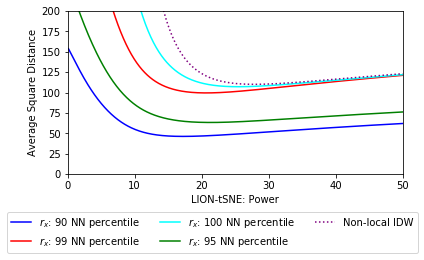

In [122]:
# CAREFUL: It is not just a plot, it also searches optimal power parameter.
lion_optimal_power = dict()

legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,3)
power_perc_combos = lion_power_plot_data.keys()
#print(power_perc_combos)
all_percentages = set([int(i.split(";")[0]) for i in power_perc_combos])
x = sorted(set([float(i.split(";")[1]) for i in power_perc_combos]))
color_dict = {90:'blue', 95:'green',99:'red',100:'cyan'}
legend_list = list()
legend_lines = list()
#print(all_percentages)
for perc in all_percentages:
    y = list()
    for cur_power in x:
        key = str(perc)+";%.3f"%(cur_power)
        #print(cur_power, perc, lion_power_plot_data[key])
        y.append(lion_power_plot_data[key]['PowerSquareDist'])
    h, = plt.plot(x,y, c=color_dict[perc])
    #print(perc, x[np.argmin(y)])
    lion_optimal_power[perc] = x[np.argmin(y)]
    legend_lines.append(h)
    legend_list.append("$r_x$: "+str(perc)+" NN percentile")
    
EPS = 1e-5
y = list()
x_global = list()
for cur_power in x:
    closest_power = [i for i in global_idw_power_performance_abs if np.abs(i-cur_power)<EPS]
    if len(closest_power)>0:
        x_global.append(cur_power)
        y.append(global_idw_power_performance[closest_power[0]])
#print("Non-Local", x_global[np.argmin(y)])
idw_optimal_power = x_global[np.argmin(y)]
h, = plt.plot(x_global,y, c='purple', linestyle=":")
legend_lines.append(h)
legend_list.append("Non-local IDW")
#plt.title("IDW - Accuracy vs Power") # We'd better use figure caption
#ax.legend([h1,h2,h3,h4,h5,h6], ["Closest Training Set Image"]+idw_method_list)
#h = plt.axhline(y=baseline_accuracy, c = 'black', linestyle='--')
l = plt.legend(legend_lines,legend_list, bbox_to_anchor=[1.06,-0.2], ncol=3)
plt.xlabel("LION-tSNE: Power")
plt.ylabel("Average Square Distance")
plt.ylim([0,200])
plt.xlim([0,50])
#f.tight_layout()
plt.savefig("Figures/LION-power-training-set.png",bbox_extra_artists=[l],bbox_inches='tight')
plt.show(f)

In [123]:
idw_optimal_power

27.9

In [124]:
lion_optimal_power

{90: 17.2, 95: 21.3, 99: 20.7, 100: 25.5}

In [313]:
# Make a table for LaTeX
width_share = math.floor(100*0.4 / (len(lion_optimal_power)))/100

print('\t\\begin{table*} \caption{Power parameter selection}  \label{tab_power_selection}')
print('\t\t\\begin{tabular}{| M{0.23\\textwidth} '+ ('| M{%.2f\\textwidth}'%width_share)*(len(lion_optimal_power)) + '| M{0.15\\textwidth} |}')
print('\t\t\t\\hline')
print('\t\t\t \\textbf{$r_x$ percentile} &'+
      ''.join(['%d & '%i for i in sorted(lion_optimal_power)])+' Non-local IDW')
print('\t\t\t\\\\ \\hline')
print('\t\t\t \\textbf{Selected $p$} &'+
      ''.join(['%.1f &'%lion_optimal_power[i] for i in sorted(lion_optimal_power)])+
      '%.1f'%idw_optimal_power)
print('\t\\\\ \\hline')    
print('\t\t\\end{tabular}')
print('\t\\end{table*}')

	\begin{table*} \caption{Power parameter selection}  \label{tab_power_selection}
		\begin{tabular}{| M{0.23\textwidth} | M{0.10\textwidth}| M{0.10\textwidth}| M{0.10\textwidth}| M{0.10\textwidth}| M{0.15\textwidth} |}
			\hline
			 \textbf{$r_x$ percentile} &90 & 95 & 99 & 100 &  Non-local IDW
			\\ \hline
			 \textbf{Optimal $p$} &17.2 &21.3 &20.7 &25.5 &27.9
	\\ \hline
		\end{tabular}
	\end{table*}


In [150]:
emb_lion_90 = dTSNE_mnist.generate_lion_tsne_embedder(function_kwargs={'radius_x_percentile':90,
                                                                       'power' : lion_optimal_power[90]})
emb_lion_95 = dTSNE_mnist.generate_lion_tsne_embedder(function_kwargs={'radius_x_percentile':95,
                                                                      'power' : lion_optimal_power[95]})
emb_lion_99 = dTSNE_mnist.generate_lion_tsne_embedder(function_kwargs={'radius_x_percentile':99,
                                                                      'power' : lion_optimal_power[99]})
emb_lion_100 = dTSNE_mnist.generate_lion_tsne_embedder(function_kwargs={'radius_x_percentile':100,
                                                                        'power' : lion_optimal_power[100]})                                                                       

In [152]:
#picked_neighbors_mnist_pca = mnist_pca.transform(picked_neighbors)
#It takes a while. Let's pickle.

cluster_lion_results_file = 'lion_clustering_results.p'
regenerate_lion_cluster_results = False

if os.path.isfile(cluster_lion_results_file) and not regenerate_lion_cluster_results:
    print("Results file found. Loading...")
    with open(cluster_lion_results_file, 'rb') as f:
        picked_neighbors_y_lion90, picked_neighbors_y_lion95, picked_neighbors_y_lion99, \
        picked_neighbors_y_lion100 = pickle.load(f)
else:
    print("No results file or regenerate requested")
    picked_neighbors_y_lion90 = emb_lion_90(picked_neighbors)
    print("Got LION-tSNE 90th percentile")
    picked_neighbors_y_lion95 = emb_lion_95(picked_neighbors)
    print("Got LION-tSNE 95th percentile")
    picked_neighbors_y_lion99 = emb_lion_99(picked_neighbors)
    print("Got LION-tSNE 99th percentile")
    picked_neighbors_y_lion100 = emb_lion_100(picked_neighbors)
    print("Got LION-tSNE 100th percentile")    
    with open(cluster_lion_results_file, 'wb') as f:
        pickle.dump((picked_neighbors_y_lion90, picked_neighbors_y_lion95, picked_neighbors_y_lion99, \
        picked_neighbors_y_lion100), f)    
    print("Saved")

No results file or regenerate requested
Got LION-tSNE 90th percentile
Got LION-tSNE 95th percentile
Got LION-tSNE 99th percentile
Got LION-tSNE 100th percentile
Saved


In [198]:
lion_method_list = ["LION; $r_x$ at %dth perc.; $p$=%.1f"%(i, lion_optimal_power[i]) for i in sorted(lion_optimal_power)]
lion_method_results = [picked_neighbors_y_lion90, picked_neighbors_y_lion95, picked_neighbors_y_lion99,
                       picked_neighbors_y_lion100]

In [199]:
lion_nearest_neighbors_percentiles_matrix = np.zeros((len(picked_neighbors), len(lion_method_list)))
for i in range(len(picked_neighbors)):
    for j in range(len(lion_method_list)):
        y = lion_method_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((Y_mnist-y)**2, axis=1)))
        lion_nearest_neighbors_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
lion_distance_percentiles = np.mean(lion_nearest_neighbors_percentiles_matrix, axis=0) 
for j in range(len(lion_method_list)):
    print(lion_method_list[j], lion_distance_percentiles[j])

LION; $r_x$ at 90th perc.; $p$=17.2 7.29116
LION; $r_x$ at 95th perc.; $p$=21.3 5.00196
LION; $r_x$ at 99th perc.; $p$=20.7 4.64476
LION; $r_x$ at 100th perc.; $p$=25.5 3.22444


In [200]:
lion_kl = np.zeros((len(lion_method_list), len(picked_neighbors)))

processed_indices = list()

kl_lion_performance_file = 'kl_lion_performance.p'
if os.path.isfile(kl_lion_performance_file):
    with open(kl_lion_performance_file, 'rb') as f:
        lion_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(picked_neighbors),))
for i in range(len(picked_neighbors)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, picked_neighbors[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = lion_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(lion_method_results)):
        # Single file with p matrix
        new_Y = np.concatenate((Y_mnist, lion_method_results[j][i,:].reshape((1,-1))), axis=0)
        lion_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_lion_performance_file,'wb') as f:
        pickle.dump((lion_kl, processed_indices), f)
# This should be fast
lion_avg_kl = np.mean(lion_kl, axis=1) 

Sample 0 already processed. Results loaded.
Sample 1 already processed. Results loaded.
Sample 2 already processed. Results loaded.
Sample 3 already processed. Results loaded.
Sample 4 already processed. Results loaded.
Sample 5 already processed. Results loaded.
Sample 6 already processed. Results loaded.
Sample 7 already processed. Results loaded.
Sample 8 already processed. Results loaded.
Sample 9 already processed. Results loaded.
Sample 10 already processed. Results loaded.
Sample 11 already processed. Results loaded.
Sample 12 already processed. Results loaded.
Sample 13 already processed. Results loaded.
Sample 14 already processed. Results loaded.
Sample 15 already processed. Results loaded.
Sample 16 already processed. Results loaded.
Sample 17 already processed. Results loaded.
Sample 18 already processed. Results loaded.
Sample 19 already processed. Results loaded.
Sample 20 already processed. Results loaded.
Sample 21 already processed. Results loaded.
Sample 22 already pr

Sample 455 already processed. Results loaded.
Sample 456 already processed. Results loaded.
Sample 457 already processed. Results loaded.
Sample 458 already processed. Results loaded.
Sample 459 already processed. Results loaded.
Sample 460 already processed. Results loaded.
Sample 461 already processed. Results loaded.
Sample 462 already processed. Results loaded.
Sample 463 already processed. Results loaded.
Sample 464 already processed. Results loaded.
Sample 465 already processed. Results loaded.
Sample 466 already processed. Results loaded.
Sample 467 already processed. Results loaded.
Sample 468 already processed. Results loaded.
Sample 469 already processed. Results loaded.
Sample 470 already processed. Results loaded.
Sample 471 already processed. Results loaded.
Sample 472 already processed. Results loaded.
Sample 473 already processed. Results loaded.
Sample 474 already processed. Results loaded.
Sample 475 already processed. Results loaded.
Sample 476 already processed. Resu

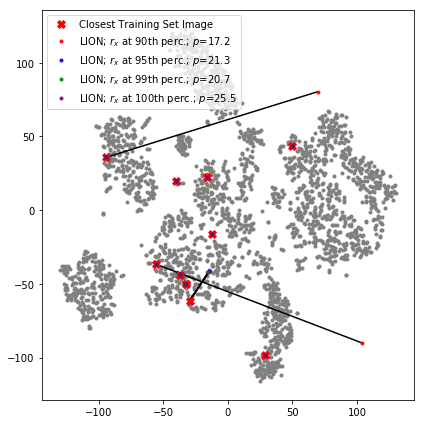

In [201]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
chosen_indices = list(range(shown_indices))
#chosen_indices = [3]
for l in range(shown_indices):
    if l in chosen_indices:
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_lion90[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_lion90[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_lion95[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_lion95[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_lion99[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_lion99[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_lion100[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_lion100[l,1]], c='black', label=None, zorder=2)
    
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
#legend_list.append(str(l))
h1 = ax.scatter(picked_indices_y_mnist[:shown_indices,0],
                picked_indices_y_mnist[:shown_indices:,1], c='red', marker='X', s=60, zorder=3)
h2 = ax.scatter(picked_neighbors_y_lion90[:shown_indices,0],
                picked_neighbors_y_lion90[:shown_indices,1], c='red', marker='.', zorder=3,alpha=0.9)
h3 = ax.scatter(picked_neighbors_y_lion95[:shown_indices,0],
                picked_neighbors_y_lion95[:shown_indices,1], c='blue', marker='.', zorder=3,alpha=0.9)
h4 = ax.scatter(picked_neighbors_y_lion99[:shown_indices,0],
                picked_neighbors_y_lion99[:shown_indices,1], c='green', marker='.', zorder=3,alpha=0.9)
h5 = ax.scatter(picked_neighbors_y_lion100[:shown_indices,0],
                picked_neighbors_y_lion100[:shown_indices,1], c='purple', marker='.', zorder=3,alpha=0.9)

ax.legend([h1,h2,h3,h4,h5], ["Closest Training Set Image"]+lion_method_list, loc=2)
f.tight_layout()
plt.savefig("Figures/neighbor-test-LION.png")
plt.show(f)

In [202]:
lion_accuracy = np.zeros((len(lion_method_list),))

for j in range(len(lion_method_results)):
    per_sample_accuracy = np.zeros((len(picked_neighbors),))
    for i in range(len(picked_neighbors)):
        expected_label = picked_neighbor_labels[i]
        nn_indices = get_nearest_neighbors_in_y(lion_method_results[j][i,:], n=accuracy_nn)
        obtained_labels = labels_mnist[nn_indices]
        per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
    lion_accuracy[j] = np.mean(per_sample_accuracy) 
    print(lion_method_list[j], lion_accuracy[j])

LION; $r_x$ at 90th perc.; $p$=17.2 0.8649
LION; $r_x$ at 95th perc.; $p$=21.3 0.8715
LION; $r_x$ at 99th perc.; $p$=20.7 0.8788
LION; $r_x$ at 100th perc.; $p$=25.5 0.8785


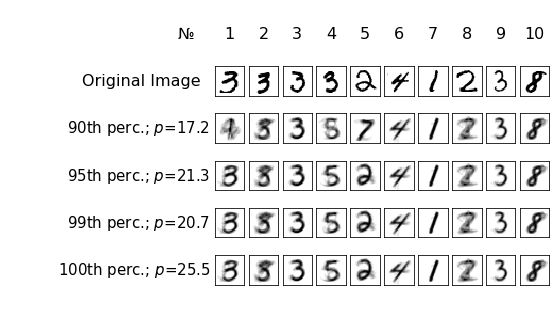

In [206]:
# Another way to check whether we are in the same cluster:
# For ending Y, pick several nearest neighbors in Y space, get their Xs, average them out and print.
width = shown_indices
height = len(lion_method_results)

gs = gridspec.GridSpec(height+2, width+1, width_ratios=[6.1]+[1]*width)     
    
width = shown_indices #total number to show
start_index = 0

f, ax_total = plt.subplots()

# First row - number of examples
plt.subplot(gs[0]).set_axis_off()
plt.subplot(gs[width+1]).set_axis_off()
plt.subplot(gs[0]).text(text="№   ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)
plt.subplot(gs[width+1]).text(text="Original Image  ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)

f.set_size_inches(7,4)
f.subplots_adjust()

for j in range(len(lion_method_results)):
    sp = plt.subplot(gs[(j+2)*(width+1)])
    # Shorten one of names
    sp.text(text=lion_method_list[j][15:],x=1.0, y=0.4,s=11, ha='right', fontsize=15)
    sp.set_axis_off()
    
# It is just a plot, let's make it simple and use 2 loop rather than vectorization
for i in range(width):
    orig_sp = plt.subplot(gs[width+i+2])
    orig_sp.imshow(X_mnist_raw[picked_indices[i], :].reshape(28,28), cmap='gray_r')
    orig_sp.axes.get_xaxis().set_visible(False)
    orig_sp.axes.get_yaxis().set_visible(False)
    num_sp = plt.subplot(gs[i+1])
    num_sp.text(text=str(i+1),x=0.5, y=0.5,s=11, ha='center', va='center', fontsize=16)
    num_sp.set_axis_off()
    for j in range(len(lion_method_results)):
        sp = plt.subplot(gs[(j+2)*(width+1) + i+1])
        nn_indices = get_nearest_neighbors_in_y(lion_method_results[j][i,:], n=illustration_nn)
        average_image = np.mean(X_mnist_raw[nn_indices,:], axis=0).reshape(28,28)
        sp.imshow(average_image, cmap='gray_r')
        sp.axes.get_xaxis().set_visible(False)
        sp.axes.get_yaxis().set_visible(False)
#gs.tight_layout(f)
gs.update(wspace=0.1, hspace=0.025)
f.subplots_adjust(left=-0.04, right=0.99, top=0.99,bottom=0.01)

plt.show(f)
f.savefig("Figures/lion_clustered_nearest_neighbors.png")

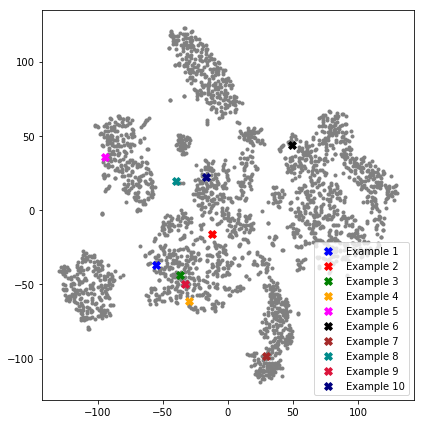

In [104]:
# Plot with examples
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)

plots_for_legend_list = list()
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')

color_list = ['blue','red','green','orange','magenta','black','brown','darkcyan','crimson','navy']

for i in range(shown_indices):
    h = ax.scatter(picked_indices_y_mnist[i,0],
                   picked_indices_y_mnist[i,1], marker='X', c=color_list[i], s=60, zorder=3)
    legend_list.append("Example "+str(i+1))
    #c = plt.Circle((picked_indices_y_mnist[l,0], picked_indices_y_mnist[l,1]), r, color='black', fill=False,zorder=4)
    #ax.add_artist(c)
    plots_for_legend_list.append(h)

ax.legend(plots_for_legend_list, legend_list)

f.tight_layout()
plt.savefig("Figures/examples-positioned.png")
plt.show(f)

In [105]:
rbf_method_list = ["RBF - Multiquadric","RBF - Gaussian",
                        "RBF - Inverse Multiquadric","RBF - Linear",'RBF - Cubic','RBF - Quintic',
                        'RBF - Thin Plate']

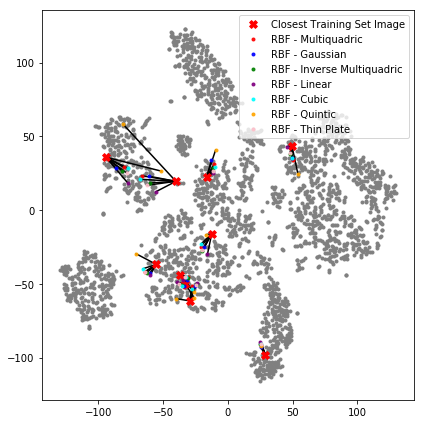

In [106]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
chosen_indices = list(range(shown_indices))
#chosen_indices = [3]
for l in range(shown_indices):
    if l in chosen_indices:
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_multiquadric[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_multiquadric[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gaussian[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_gaussian[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_linear[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_linear[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_inverse[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_inverse[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_cubic[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_cubic[l,1]], c='black', label=None, zorder=2)    
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_quintic[l,0]],             
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_quintic[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_thin_plate[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_thin_plate[l,1]], c='black', label=None, zorder=2)
    
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
#legend_list.append(str(l))
h1 = ax.scatter(picked_indices_y_mnist[:shown_indices,0],
                picked_indices_y_mnist[:shown_indices:,1], c='red', marker='X', s=60, zorder=3)
h2 = ax.scatter(picked_neighbors_y_multiquadric[:shown_indices,0],
                picked_neighbors_y_multiquadric[:shown_indices,1], c='red', marker='.', zorder=3,alpha=0.9)
h3 = ax.scatter(picked_neighbors_y_gaussian[:shown_indices,0],
                picked_neighbors_y_gaussian[:shown_indices,1], c='blue', marker='.', zorder=3,alpha=0.9)
h4 = ax.scatter(picked_neighbors_y_inverse[:shown_indices,0],
                picked_neighbors_y_inverse[:shown_indices,1], c='green', marker='.', zorder=3,alpha=0.9)
h5 = ax.scatter(picked_neighbors_y_linear[:shown_indices,0],
                picked_neighbors_y_linear[:shown_indices,1], c='purple', marker='.', zorder=3,alpha=0.9)
h6 = ax.scatter(picked_neighbors_y_cubic[:shown_indices,0],
                picked_neighbors_y_cubic[:shown_indices,1], c='cyan', marker='.', zorder=3,alpha=0.9)
h7 = ax.scatter(picked_neighbors_y_quintic[:shown_indices,0],
                picked_neighbors_y_quintic[:shown_indices,1], c='orange', marker='.', zorder=3,alpha=0.9)
h8 = ax.scatter(picked_neighbors_y_thin_plate[:shown_indices,0],
                picked_neighbors_y_thin_plate[:shown_indices,1], c='pink', marker='.', zorder=3,alpha=0.9)

ax.legend([h1,h2,h3,h4,h5,h6,h7,h8], ["Closest Training Set Image"]+rbf_method_list)
f.tight_layout()
plt.savefig("Figures/neighbor-test-RBF.png")
plt.show(f)

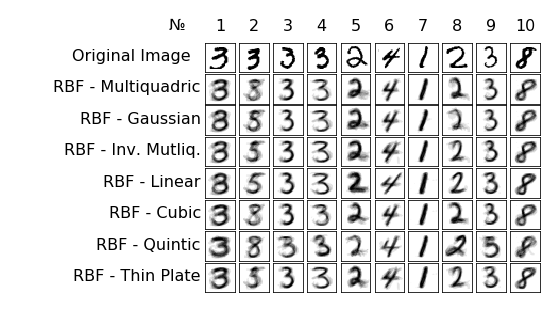

In [107]:
# Another way to check whether we are in the same cluster:
# For ending Y, pick several nearest neighbors in Y space, get their Xs, average them out and print.
rbf_method_results = [picked_neighbors_y_multiquadric, picked_neighbors_y_gaussian, picked_neighbors_y_inverse,
                      picked_neighbors_y_linear, picked_neighbors_y_cubic, picked_neighbors_y_quintic,
                      picked_neighbors_y_thin_plate]

width = shown_indices
height = len(rbf_method_results)

gs = gridspec.GridSpec(height+2, width+1, width_ratios=[6.1]+[1]*width)     
    
width = shown_indices #total number to show
start_index = 0

f, ax_total = plt.subplots()

# First row - number of examples
plt.subplot(gs[0]).set_axis_off()
plt.subplot(gs[width+1]).set_axis_off()
plt.subplot(gs[0]).text(text="№   ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)
plt.subplot(gs[width+1]).text(text="Original Image  ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)

f.set_size_inches(7,4)
f.subplots_adjust()

for j in range(len(rbf_method_results)):
    sp = plt.subplot(gs[(j+2)*(width+1)])
    # Shorten one of names
    sp.text(text=(rbf_method_list[j] if j!=2 else 'RBF - Inv. Mutliq.'),x=1.0, y=0.4,s=11, ha='right', fontsize=16)
    sp.set_axis_off()
    
# It is just a plot, let's make it simple and use 2 loop rather than vectorization
for i in range(width):
    orig_sp = plt.subplot(gs[width+i+2])
    orig_sp.imshow(X_mnist_raw[picked_indices[i], :].reshape(28,28), cmap='gray_r')
    orig_sp.axes.get_xaxis().set_visible(False)
    orig_sp.axes.get_yaxis().set_visible(False)
    num_sp = plt.subplot(gs[i+1])
    num_sp.text(text=str(i+1),x=0.5, y=0.5,s=11, ha='center', va='center', fontsize=16)
    num_sp.set_axis_off()
    for j in range(len(rbf_method_results)):
        sp = plt.subplot(gs[(j+2)*(width+1) + i+1])
        nn_indices = get_nearest_neighbors_in_y(rbf_method_results[j][i,:], n=illustration_nn)
        average_image = np.mean(X_mnist_raw[nn_indices,:], axis=0).reshape(28,28)
        sp.imshow(average_image, cmap='gray_r')
        sp.axes.get_xaxis().set_visible(False)
        sp.axes.get_yaxis().set_visible(False)
#gs.tight_layout(f)
gs.update(wspace=0.1, hspace=0.025)
f.subplots_adjust(left=-0.04, right=0.99, top=0.99,bottom=0.01)

plt.show(f)
f.savefig("Figures/rbf_clustered_nearest_neighbors.png")

In [108]:
# Baseline accuracy: sometimes the point is in the mixed cluster, and K nearest neighbors of it belong to different clusters
# themselves. Accuracy 100% would not be achieved that way.

# TODO Should we call our metric accuracy at all?
# Should we count sample itself, when calculating baseline accuracy? On one hand, no - training sample is obviously its own NN.
# On another hand, we are looking for accuracy upper bound. And it is not training sample itself we are avaluating, it is
# "in upper bound case we would have had embedding very close to ..." etc.
# If we say "keep training sample", our target accuracy will be higher.
# So let's make sure that errors are not in our favor.
# Actaully, see the paper.
per_sample_accuracy = np.zeros((len(picked_neighbors),))
for i in range(len(picked_neighbors)):
    expected_label = picked_neighbor_labels[i]
    nn_indices = get_nearest_neighbors_in_y(picked_indices_y_mnist[i,:], n=accuracy_nn)
    obtained_labels = labels_mnist[nn_indices]
    per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
baseline_accuracy = np.mean(per_sample_accuracy) 
print("Baseline Accuracy: ", baseline_accuracy)

Baseline Accuracy:  0.8759


{90, 99, 100, 95}


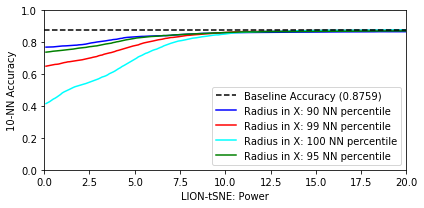

In [126]:
# Accuracy-vs-power plot
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,3)
power_perc_combos = lion_power_plot_data.keys()
all_percentages = set([int(i.split(";")[0]) for i in power_perc_combos])
x = sorted(set([float(i.split(";")[1]) for i in power_perc_combos]))
color_dict = {90:'blue', 95:'green',99:'red',100:'cyan'}
legend_list = list()
legend_lines = list()
print(all_percentages)
for perc in all_percentages:
    y = list()
    for cur_power in x:
        key = "%d;%.3f"%(perc,cur_power)
        #print(key)
        y.append(lion_power_plot_data[key]["Accuracy"])
    h, = plt.plot(x,y, c=color_dict[perc])
    legend_lines.append(h)
    legend_list.append("Radius in X: "+str(perc)+" NN percentile")
#plt.title("IDW - Accuracy vs Power") # We'd better use figure caption
#ax.legend([h1,h2,h3,h4,h5,h6], ["Closest Training Set Image"]+idw_method_list)
h = plt.axhline(y=baseline_accuracy, c = 'black', linestyle='--')
plt.legend([h]+legend_lines,["Baseline Accuracy (%.4f)"%baseline_accuracy]+legend_list)
plt.xlabel("LION-tSNE: Power")
plt.ylabel("10-NN Accuracy")
plt.ylim([0,1])
plt.xlim([0,20])
f.tight_layout()
plt.savefig("Figures/LION-power-vs-accuracy.png")
plt.show(f)

In [127]:
#lion_power_plot_data["90;2.800"]

In [128]:
D_Y = distance.squareform(distance.pdist(Y_mnist))
# Now find distance to closest neighbor
np.fill_diagonal(D_Y, np.inf) #... but not to itself
nearest_neighbors_y_dist = np.min(D_Y, axis=1) # Actually, whatever axis

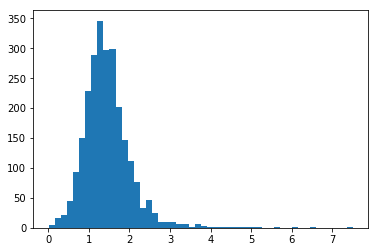

In [129]:
plt.hist(nearest_neighbors_y_dist, bins=50)
plt.show()

In [130]:
# Checking nearest neighbor accuracy.
# Code for copy-pasting LaTeX table will be later in the notebook. And it will rely on accuracy calculated here.

rbf_accuracy = np.zeros((len(rbf_method_list),))

for j in range(len(rbf_method_results)):
    per_sample_accuracy = np.zeros((len(picked_neighbors),))
    for i in range(len(picked_neighbors)):
        expected_label = picked_neighbor_labels[i]
        nn_indices = get_nearest_neighbors_in_y(rbf_method_results[j][i,:], n=accuracy_nn)
        obtained_labels = labels_mnist[nn_indices]
        per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
    rbf_accuracy[j] = np.mean(per_sample_accuracy) 
    print(rbf_method_list[j], rbf_accuracy[j])

RBF - Multiquadric 0.7384
RBF - Gaussian 0.7378
RBF - Inverse Multiquadric 0.743
RBF - Linear 0.7093
RBF - Cubic 0.7349
RBF - Quintic 0.6744
RBF - Thin Plate 0.7283


In [131]:
rbf_kl = np.zeros((len(rbf_method_list), len(picked_neighbors)))

processed_indices = list()

kl_rbf_performance_file = 'kl_rbf_performance.p'
if os.path.isfile(kl_rbf_performance_file):
    with open(kl_rbf_performance_file, 'rb') as f:
        rbf_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(picked_neighbors),))
for i in range(len(picked_neighbors)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, picked_neighbors[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = lion_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(rbf_method_results)):
        # Single file with p matrix
        new_Y = np.concatenate((Y_mnist, rbf_method_results[j][i,:].reshape((1,-1))), axis=0)
        rbf_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_rbf_performance_file,'wb') as f:
        pickle.dump((rbf_kl, processed_indices), f)
# This should be fast
rbf_avg_kl = np.mean(rbf_kl, axis=1) 

Sample 0 already processed. Results loaded.
Sample 1 already processed. Results loaded.
Sample 2 already processed. Results loaded.
Sample 3 already processed. Results loaded.
Sample 4 already processed. Results loaded.
Sample 5 already processed. Results loaded.
Sample 6 already processed. Results loaded.
Sample 7 already processed. Results loaded.
Sample 8 already processed. Results loaded.
Sample 9 already processed. Results loaded.
Sample 10 already processed. Results loaded.
Sample 11 already processed. Results loaded.
Sample 12 already processed. Results loaded.
Sample 13 already processed. Results loaded.
Sample 14 already processed. Results loaded.
Sample 15 already processed. Results loaded.
Sample 16 already processed. Results loaded.
Sample 17 already processed. Results loaded.
Sample 18 already processed. Results loaded.
Sample 19 already processed. Results loaded.
Sample 20 already processed. Results loaded.
Sample 21 already processed. Results loaded.
Sample 22 already pr

Sample 452 already processed. Results loaded.
Sample 453 already processed. Results loaded.
Sample 454 already processed. Results loaded.
Sample 455 already processed. Results loaded.
Sample 456 already processed. Results loaded.
Sample 457 already processed. Results loaded.
Sample 458 already processed. Results loaded.
Sample 459 already processed. Results loaded.
Sample 460 already processed. Results loaded.
Sample 461 already processed. Results loaded.
Sample 462 already processed. Results loaded.
Sample 463 already processed. Results loaded.
Sample 464 already processed. Results loaded.
Sample 465 already processed. Results loaded.
Sample 466 already processed. Results loaded.
Sample 467 already processed. Results loaded.
Sample 468 already processed. Results loaded.
Sample 469 already processed. Results loaded.
Sample 470 already processed. Results loaded.
Sample 471 already processed. Results loaded.
Sample 472 already processed. Results loaded.
Sample 473 already processed. Resu

In [132]:
from scipy import stats

rbf_nearest_neighbors_percentiles_matrix = np.zeros((len(picked_neighbors), len(rbf_method_list)))
for i in range(len(picked_neighbors)):
    for j in range(len(rbf_method_list)):
        y = rbf_method_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((Y_mnist-y)**2, axis=1)))
        rbf_nearest_neighbors_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
rbf_distance_percentiles = np.mean(rbf_nearest_neighbors_percentiles_matrix, axis=0) 
for j in range(len(rbf_method_list)):
    print(rbf_method_list[j], rbf_distance_percentiles[j])

RBF - Multiquadric 53.54832
RBF - Gaussian 55.08056
RBF - Inverse Multiquadric 53.22592
RBF - Linear 52.65868
RBF - Cubic 53.97352
RBF - Quintic 61.67152
RBF - Thin Plate 53.14104


In [133]:
rbf_method_results[0].shape

(1000, 2)

In [140]:
baseline_accuracies_by_nn = list()

for n in range(1,21):
    per_sample_accuracy = np.zeros((len(picked_neighbors),))
    for i in range(len(picked_neighbors)):
        expected_label = picked_neighbor_labels[i]
        nn_indices = get_nearest_neighbors_in_y(picked_indices_y_mnist[i,:], n=n)
        obtained_labels = labels_mnist[nn_indices]
        per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
    baseline_accuracies_by_nn.append(np.mean(per_sample_accuracy))
    print("Baseline Accuracy",n,"NN: ", baseline_accuracies_by_nn[-1])

Baseline Accuracy 1 NN:  0.978
Baseline Accuracy 2 NN:  0.9455
Baseline Accuracy 3 NN:  0.930666666667
Baseline Accuracy 4 NN:  0.91325
Baseline Accuracy 5 NN:  0.9034
Baseline Accuracy 6 NN:  0.895
Baseline Accuracy 7 NN:  0.891714285714
Baseline Accuracy 8 NN:  0.8865
Baseline Accuracy 9 NN:  0.880111111111
Baseline Accuracy 10 NN:  0.8759
Baseline Accuracy 11 NN:  0.870636363636
Baseline Accuracy 12 NN:  0.866083333333
Baseline Accuracy 13 NN:  0.862846153846
Baseline Accuracy 14 NN:  0.859
Baseline Accuracy 15 NN:  0.8554
Baseline Accuracy 16 NN:  0.85175
Baseline Accuracy 17 NN:  0.849705882353
Baseline Accuracy 18 NN:  0.847
Baseline Accuracy 19 NN:  0.844578947368
Baseline Accuracy 20 NN:  0.84255


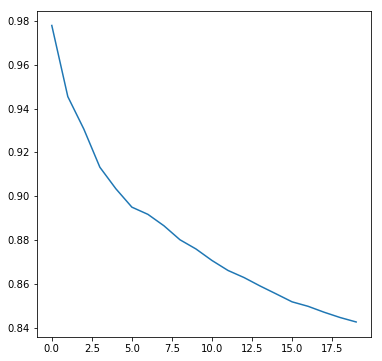

In [143]:
# Should I include it in the paper? Unlikely. Just for my own reference.
plt.gcf().set_size_inches(6,6)
plt.plot(baseline_accuracies_by_nn)
plt.show()

In [136]:
original_kl, _ = lion_tsne.kl_divergence_and_gradient(p_matrix=dTSNE_mnist.P_matrix, y=dTSNE_mnist.Y)
print("Original KL divergence", original_kl)

for j in range(len(rbf_method_results)):
    print(rbf_method_list[j], rbf_avg_kl[j])

Original KL divergence 1.11687680132
RBF - Multiquadric 1.11908619031
RBF - Gaussian 1.11907230907
RBF - Inverse Multiquadric 1.11899300106
RBF - Linear 1.11907894093
RBF - Cubic 1.11909273121
RBF - Quintic 1.11959626553
RBF - Thin Plate 1.11903489236


In [144]:
idw_method_list = ["IDW - Power 1","IDW - Power 10", "IDW - Power 20","IDW - Power 27.9", "IDW - Power 40"]

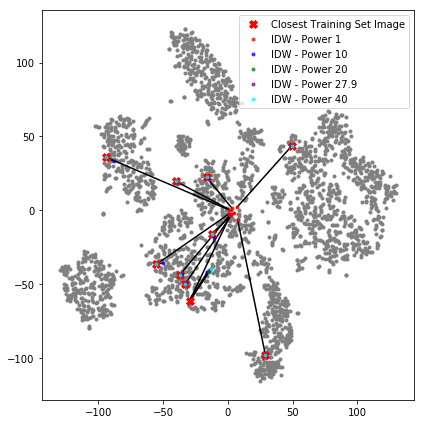

In [145]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
chosen_indices = list(range(shown_indices))
#chosen_indices = [3]
for l in range(shown_indices):
    if l in chosen_indices:
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_idw1[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_idw1[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_idw10[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_idw10[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_idw20[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_idw20[l,1]], c='black', label=None, zorder=2)        
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_idw_optimal[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_idw_optimal[l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_idw40[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_idw40[l,1]], c='black', label=None, zorder=2)  
        
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
#legend_list.append(str(l))
h1 = ax.scatter(picked_indices_y_mnist[:shown_indices,0],
                picked_indices_y_mnist[:shown_indices,1], c='red', marker='X', s=60, zorder=3)
h2 = ax.scatter(picked_neighbors_y_idw1[:shown_indices,0],
                picked_neighbors_y_idw1[:shown_indices,1], c='red', marker='.', zorder=3,alpha=0.7)
h3 = ax.scatter(picked_neighbors_y_idw10[:shown_indices,0],
                picked_neighbors_y_idw10[:shown_indices,1], c='blue', marker='.', zorder=3,alpha=0.7)
h4 = ax.scatter(picked_neighbors_y_idw20[:shown_indices,0],
                picked_neighbors_y_idw20[:shown_indices,1], c='green', marker='.', zorder=3,alpha=0.7)
h5 = ax.scatter(picked_neighbors_y_idw_optimal[:shown_indices,0],
                picked_neighbors_y_idw_optimal[:shown_indices,1], c='purple', marker='.', zorder=3,alpha=0.7)
h6 = ax.scatter(picked_neighbors_y_idw40[:shown_indices,0],
                picked_neighbors_y_idw40[:shown_indices,1], c='cyan', marker='.', zorder=3,alpha=0.7)

ax.legend([h1,h2,h3,h4,h5,h6], ["Closest Training Set Image"]+idw_method_list)
f.tight_layout()
plt.savefig("Figures/neighbor-test-IDW.png")
plt.show(f)

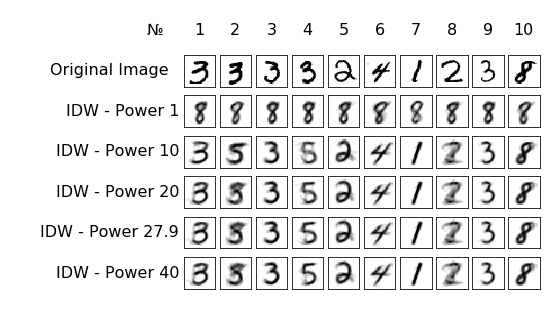

In [146]:
# Another way to check whether we are in the same cluster:
# For ending Y, pick several nearest neighbors in Y space, get their Xs, average them out and print.
idw_method_results = [picked_neighbors_y_idw1, picked_neighbors_y_idw10, picked_neighbors_y_idw20,
                      picked_neighbors_y_idw_optimal, picked_neighbors_y_idw40]

width = shown_indices
height = len(idw_method_results)

gs = gridspec.GridSpec(height+2, width+1, width_ratios=[5]+[1]*width)     
    
width = shown_indices #total number to show
start_index = 0

f, ax_total = plt.subplots()

# First row - number of examples
plt.subplot(gs[0]).set_axis_off()
plt.subplot(gs[width+1]).set_axis_off()
plt.subplot(gs[0]).text(text="№   ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)
plt.subplot(gs[width+1]).text(text="Original Image  ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)

f.set_size_inches(7,4)
f.subplots_adjust()

for j in range(len(idw_method_results)):
    sp = plt.subplot(gs[(j+2)*(width+1)])
    sp.text(text=idw_method_list[j],x=1.0, y=0.4,s=11, ha='right', fontsize=16)
    sp.set_axis_off()
    
# It is just a plot, let's make it simple and use 2 loop rather than vectorization
for i in range(width):
    orig_sp = plt.subplot(gs[width+i+2])
    orig_sp.imshow(X_mnist_raw[picked_indices[i], :].reshape(28,28), cmap='gray_r')
    orig_sp.axes.get_xaxis().set_visible(False)
    orig_sp.axes.get_yaxis().set_visible(False)
    num_sp = plt.subplot(gs[i+1])
    num_sp.text(text=str(i+1),x=0.5, y=0.5,s=11, ha='center', va='center', fontsize=16)
    num_sp.set_axis_off()
    for j in range(len(idw_method_results)):
        sp = plt.subplot(gs[(j+2)*(width+1) + i+1])
        nn_indices = get_nearest_neighbors_in_y(idw_method_results[j][i,:], n=illustration_nn)
        average_image = np.mean(X_mnist_raw[nn_indices,:], axis=0).reshape(28,28)
        sp.imshow(average_image, cmap='gray_r')
        sp.axes.get_xaxis().set_visible(False)
        sp.axes.get_yaxis().set_visible(False)
#gs.tight_layout(f)
gs.update(wspace=0.1, hspace=0.025)
f.subplots_adjust(left=-0.04, right=0.99, top=0.99,bottom=0.01)

plt.show(f)
f.savefig("Figures/idw_clustered_nearest_neighbors.png")

In [148]:
idw_kl = np.zeros((len(idw_method_list), len(picked_neighbors)))

processed_indices = list()

kl_idw_performance_file = 'kl_idw_performance.p'
if os.path.isfile(kl_idw_performance_file):
    with open(kl_idw_performance_file, 'rb') as f:
        idw_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(picked_neighbors),))
for i in range(len(picked_neighbors)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, picked_neighbors[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = lion_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(idw_method_results)):
        # Single file with p matrix
        new_Y = np.concatenate((Y_mnist, idw_method_results[j][i,:].reshape((1,-1))), axis=0)
        idw_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_idw_performance_file,'wb') as f:
        pickle.dump((idw_kl, processed_indices), f)
# This should be fast
idw_avg_kl = np.mean(idw_kl, axis=1) 

Processing sample  0
	P-matrix file found. Loading.
Processing sample  1
	P-matrix file found. Loading.
Processing sample  2
	P-matrix file found. Loading.
Processing sample  3
	P-matrix file found. Loading.
Processing sample  4
	P-matrix file found. Loading.
Processing sample  5
	P-matrix file found. Loading.
Processing sample  6
	P-matrix file found. Loading.
Processing sample  7
	P-matrix file found. Loading.
Processing sample  8
	P-matrix file found. Loading.
Processing sample  9
	P-matrix file found. Loading.
Processing sample  10
	P-matrix file found. Loading.
Processing sample  11
	P-matrix file found. Loading.
Processing sample  12
	P-matrix file found. Loading.
Processing sample  13
	P-matrix file found. Loading.
Processing sample  14
	P-matrix file found. Loading.
Processing sample  15
	P-matrix file found. Loading.
Processing sample  16
	P-matrix file found. Loading.
Processing sample  17
	P-matrix file found. Loading.
Processing sample  18
	P-matrix file found. Loading.
Pro

Processing sample  154
	P-matrix file found. Loading.
Processing sample  155
	P-matrix file found. Loading.
Processing sample  156
	P-matrix file found. Loading.
Processing sample  157
	P-matrix file found. Loading.
Processing sample  158
	P-matrix file found. Loading.
Processing sample  159
	P-matrix file found. Loading.
Processing sample  160
	P-matrix file found. Loading.
Processing sample  161
	P-matrix file found. Loading.
Processing sample  162
	P-matrix file found. Loading.
Processing sample  163
	P-matrix file found. Loading.
Processing sample  164
	P-matrix file found. Loading.
Processing sample  165
	P-matrix file found. Loading.
Processing sample  166
	P-matrix file found. Loading.
Processing sample  167
	P-matrix file found. Loading.
Processing sample  168
	P-matrix file found. Loading.
Processing sample  169
	P-matrix file found. Loading.
Processing sample  170
	P-matrix file found. Loading.
Processing sample  171
	P-matrix file found. Loading.
Processing sample  172
	P-ma

Processing sample  306
	P-matrix file found. Loading.
Processing sample  307
	P-matrix file found. Loading.
Processing sample  308
	P-matrix file found. Loading.
Processing sample  309
	P-matrix file found. Loading.
Processing sample  310
	P-matrix file found. Loading.
Processing sample  311
	P-matrix file found. Loading.
Processing sample  312
	P-matrix file found. Loading.
Processing sample  313
	P-matrix file found. Loading.
Processing sample  314
	P-matrix file found. Loading.
Processing sample  315
	P-matrix file found. Loading.
Processing sample  316
	P-matrix file found. Loading.
Processing sample  317
	P-matrix file found. Loading.
Processing sample  318
	P-matrix file found. Loading.
Processing sample  319
	P-matrix file found. Loading.
Processing sample  320
	P-matrix file found. Loading.
Processing sample  321
	P-matrix file found. Loading.
Processing sample  322
	P-matrix file found. Loading.
Processing sample  323
	P-matrix file found. Loading.
Processing sample  324
	P-ma

Processing sample  458
	P-matrix file found. Loading.
Processing sample  459
	P-matrix file found. Loading.
Processing sample  460
	P-matrix file found. Loading.
Processing sample  461
	P-matrix file found. Loading.
Processing sample  462
	P-matrix file found. Loading.
Processing sample  463
	P-matrix file found. Loading.
Processing sample  464
	P-matrix file found. Loading.
Processing sample  465
	P-matrix file found. Loading.
Processing sample  466
	P-matrix file found. Loading.
Processing sample  467
	P-matrix file found. Loading.
Processing sample  468
	P-matrix file found. Loading.
Processing sample  469
	P-matrix file found. Loading.
Processing sample  470
	P-matrix file found. Loading.
Processing sample  471
	P-matrix file found. Loading.
Processing sample  472
	P-matrix file found. Loading.
Processing sample  473
	P-matrix file found. Loading.
Processing sample  474
	P-matrix file found. Loading.
Processing sample  475
	P-matrix file found. Loading.
Processing sample  476
	P-ma

Processing sample  610
	P-matrix file found. Loading.
Processing sample  611
	P-matrix file found. Loading.
Processing sample  612
	P-matrix file found. Loading.
Processing sample  613
	P-matrix file found. Loading.
Processing sample  614
	P-matrix file found. Loading.
Processing sample  615
	P-matrix file found. Loading.
Processing sample  616
	P-matrix file found. Loading.
Processing sample  617
	P-matrix file found. Loading.
Processing sample  618
	P-matrix file found. Loading.
Processing sample  619
	P-matrix file found. Loading.
Processing sample  620
	P-matrix file found. Loading.
Processing sample  621
	P-matrix file found. Loading.
Processing sample  622
	P-matrix file found. Loading.
Processing sample  623
	P-matrix file found. Loading.
Processing sample  624
	P-matrix file found. Loading.
Processing sample  625
	P-matrix file found. Loading.
Processing sample  626
	P-matrix file found. Loading.
Processing sample  627
	P-matrix file found. Loading.
Processing sample  628
	P-ma

Processing sample  762
	P-matrix file found. Loading.
Processing sample  763
	P-matrix file found. Loading.
Processing sample  764
	P-matrix file found. Loading.
Processing sample  765
	P-matrix file found. Loading.
Processing sample  766
	P-matrix file found. Loading.
Processing sample  767
	P-matrix file found. Loading.
Processing sample  768
	P-matrix file found. Loading.
Processing sample  769
	P-matrix file found. Loading.
Processing sample  770
	P-matrix file found. Loading.
Processing sample  771
	P-matrix file found. Loading.
Processing sample  772
	P-matrix file found. Loading.
Processing sample  773
	P-matrix file found. Loading.
Processing sample  774
	P-matrix file found. Loading.
Processing sample  775
	P-matrix file found. Loading.
Processing sample  776
	P-matrix file found. Loading.
Processing sample  777
	P-matrix file found. Loading.
Processing sample  778
	P-matrix file found. Loading.
Processing sample  779
	P-matrix file found. Loading.
Processing sample  780
	P-ma

Processing sample  914
	P-matrix file found. Loading.
Processing sample  915
	P-matrix file found. Loading.
Processing sample  916
	P-matrix file found. Loading.
Processing sample  917
	P-matrix file found. Loading.
Processing sample  918
	P-matrix file found. Loading.
Processing sample  919
	P-matrix file found. Loading.
Processing sample  920
	P-matrix file found. Loading.
Processing sample  921
	P-matrix file found. Loading.
Processing sample  922
	P-matrix file found. Loading.
Processing sample  923
	P-matrix file found. Loading.
Processing sample  924
	P-matrix file found. Loading.
Processing sample  925
	P-matrix file found. Loading.
Processing sample  926
	P-matrix file found. Loading.
Processing sample  927
	P-matrix file found. Loading.
Processing sample  928
	P-matrix file found. Loading.
Processing sample  929
	P-matrix file found. Loading.
Processing sample  930
	P-matrix file found. Loading.
Processing sample  931
	P-matrix file found. Loading.
Processing sample  932
	P-ma

In [147]:
# Checking nearest neighbor accuracy.
# Code for copy-pasting LaTeX table will be later in the notebook. And it will rely on accuracy calculated here.

idw_accuracy = np.zeros((len(idw_method_list,)))

for j in range(len(idw_method_results)):
    per_sample_accuracy = np.zeros((len(picked_neighbors),))
    for i in range(len(picked_neighbors)):
        expected_label = picked_neighbor_labels[i]
        nn_indices = get_nearest_neighbors_in_y(idw_method_results[j][i,:], n=accuracy_nn)
        obtained_labels = labels_mnist[nn_indices]

        per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
    idw_accuracy[j] = np.mean(per_sample_accuracy) 
    print(idw_method_list[j], idw_accuracy[j])

IDW - Power 1 0.0892
IDW - Power 10 0.8373
IDW - Power 20 0.8788
IDW - Power 27.9 0.8795
IDW - Power 40 0.8796


In [165]:
original_kl, _ = lion_tsne.kl_divergence_and_gradient(p_matrix=dTSNE_mnist.P_matrix, y=dTSNE_mnist.Y)
print("Original KL divergence", original_kl)

for j in range(len(idw_method_results)):
    print(idw_method_list[j], idw_avg_kl[j])

Original KL divergence 1.11687680132
IDW - Power 1 1.12219788351
IDW - Power 10 1.11818638631
IDW - Power 20 1.11788545818
IDW - Power 27.9 1.11787640941
IDW - Power 40 1.11787477264


In [166]:
original_kl, _ = lion_tsne.kl_divergence_and_gradient(p_matrix=dTSNE_mnist.P_matrix, y=dTSNE_mnist.Y)
print("Original KL divergence", original_kl)

for j in range(len(lion_method_results)):
    print(lion_method_list[j], lion_avg_kl[j])

Original KL divergence 1.11687680132
LION; $r_x$ at 90th perc.; $p$ = 17.2 1.1179669939
LION; $r_x$ at 95th perc.; $p$ = 21.3 1.11792295164
LION; $r_x$ at 99th perc.; $p$ = 20.7 1.11789313169
LION; $r_x$ at 100th perc.; $p$ = 25.5 1.11788183718


In [167]:
idw_nearest_neighbors_percentiles_matrix = np.zeros((len(picked_neighbors), len(idw_method_list)))
for i in range(len(picked_neighbors)):
    for j in range(len(idw_method_list)):
        y = idw_method_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((Y_mnist-y)**2, axis=1)))
        idw_nearest_neighbors_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
idw_distance_percentiles = np.mean(idw_nearest_neighbors_percentiles_matrix, axis=0) 
for j in range(len(idw_method_list)):
    print(idw_method_list[j], idw_distance_percentiles[j])

IDW - Power 1 65.85296
IDW - Power 10 25.17004
IDW - Power 20 4.84548
IDW - Power 27.9 2.78196
IDW - Power 40 1.90468


In [235]:
# Leaving it extensible to get smth like "KL vs power" etc. if we need to.

idw_power_options = np.arange(0.5, 50.1, step=0.1)
idw_power_plot_data_file = 'idw_power_plot_data.p'
idw_power_plot_data = dict() # Start from scratch

if os.path.isfile(idw_power_plot_data_file):
    with open(idw_power_plot_data_file, 'rb') as f:
        idw_power_plot_data = pickle.load(f)

for p in idw_power_options:
    print("Processing power", p)
    if p not in idw_power_plot_data:
        idw_power_plot_data[p] = dict()
        
    # Building IDW interpolator costs nothing
    interpolator = dTSNE_mnist.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                                                   function_kwargs={'power':p})
    
    if 'Accuracy' not in idw_power_plot_data[p]:
        print("Accuracy not found for power ",p,"\tCalculating...")
        per_sample_accuracy = np.zeros((len(picked_neighbors),))
        for i in range(len(picked_neighbors)):
            if i%100==0:
                print("\tPower: ",p,"Processing:",i)
            expected_label = picked_neighbor_labels[i]
            result = interpolator(picked_neighbors[i])
            nn_indices = get_nearest_neighbors_in_y(result, n=accuracy_nn)
            obtained_labels = labels_mnist[nn_indices]
            per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
        idw_power_plot_data[p]['Accuracy'] = np.mean(per_sample_accuracy)
        with open(idw_power_plot_data_file, 'wb') as f:
             pickle.dump(idw_power_plot_data, f)
    #TODO Also get KL divergence?
        

Processing power 0.5
Processing power 0.6
Accuracy not found for power  0.6 	Calculating...
	Power:  0.6 Processing: 0
	Power:  0.6 Processing: 100
	Power:  0.6 Processing: 200
	Power:  0.6 Processing: 300
	Power:  0.6 Processing: 400
	Power:  0.6 Processing: 500
	Power:  0.6 Processing: 600
	Power:  0.6 Processing: 700
	Power:  0.6 Processing: 800
	Power:  0.6 Processing: 900
Processing power 0.7
Accuracy not found for power  0.7 	Calculating...
	Power:  0.7 Processing: 0
	Power:  0.7 Processing: 100
	Power:  0.7 Processing: 200
	Power:  0.7 Processing: 300
	Power:  0.7 Processing: 400
	Power:  0.7 Processing: 500
	Power:  0.7 Processing: 600
	Power:  0.7 Processing: 700
	Power:  0.7 Processing: 800
	Power:  0.7 Processing: 900
Processing power 0.8
Accuracy not found for power  0.8 	Calculating...
	Power:  0.8 Processing: 0
	Power:  0.8 Processing: 100
	Power:  0.8 Processing: 200
	Power:  0.8 Processing: 300
	Power:  0.8 Processing: 400
	Power:  0.8 Processing: 500
	Power:  0.8 Proce

	Power:  2.8 Processing: 800
	Power:  2.8 Processing: 900
Processing power 2.9
Accuracy not found for power  2.9 	Calculating...
	Power:  2.9 Processing: 0
	Power:  2.9 Processing: 100
	Power:  2.9 Processing: 200
	Power:  2.9 Processing: 300
	Power:  2.9 Processing: 400
	Power:  2.9 Processing: 500
	Power:  2.9 Processing: 600
	Power:  2.9 Processing: 700
	Power:  2.9 Processing: 800
	Power:  2.9 Processing: 900
Processing power 3.0
Accuracy not found for power  3.0 	Calculating...
	Power:  3.0 Processing: 0
	Power:  3.0 Processing: 100
	Power:  3.0 Processing: 200
	Power:  3.0 Processing: 300
	Power:  3.0 Processing: 400
	Power:  3.0 Processing: 500
	Power:  3.0 Processing: 600
	Power:  3.0 Processing: 700
	Power:  3.0 Processing: 800
	Power:  3.0 Processing: 900
Processing power 3.1
Accuracy not found for power  3.1 	Calculating...
	Power:  3.1 Processing: 0
	Power:  3.1 Processing: 100
	Power:  3.1 Processing: 200
	Power:  3.1 Processing: 300
	Power:  3.1 Processing: 400
	Power:  3

	Power:  5.1 Processing: 600
	Power:  5.1 Processing: 700
	Power:  5.1 Processing: 800
	Power:  5.1 Processing: 900
Processing power 5.2
Accuracy not found for power  5.2 	Calculating...
	Power:  5.2 Processing: 0
	Power:  5.2 Processing: 100
	Power:  5.2 Processing: 200
	Power:  5.2 Processing: 300
	Power:  5.2 Processing: 400
	Power:  5.2 Processing: 500
	Power:  5.2 Processing: 600
	Power:  5.2 Processing: 700
	Power:  5.2 Processing: 800
	Power:  5.2 Processing: 900
Processing power 5.3
Accuracy not found for power  5.3 	Calculating...
	Power:  5.3 Processing: 0
	Power:  5.3 Processing: 100
	Power:  5.3 Processing: 200
	Power:  5.3 Processing: 300
	Power:  5.3 Processing: 400
	Power:  5.3 Processing: 500
	Power:  5.3 Processing: 600
	Power:  5.3 Processing: 700
	Power:  5.3 Processing: 800
	Power:  5.3 Processing: 900
Processing power 5.4
Accuracy not found for power  5.4 	Calculating...
	Power:  5.4 Processing: 0
	Power:  5.4 Processing: 100
	Power:  5.4 Processing: 200
	Power:  5

	Power:  7.4 Processing: 400
	Power:  7.4 Processing: 500
	Power:  7.4 Processing: 600
	Power:  7.4 Processing: 700
	Power:  7.4 Processing: 800
	Power:  7.4 Processing: 900
Processing power 7.5
Accuracy not found for power  7.5 	Calculating...
	Power:  7.5 Processing: 0
	Power:  7.5 Processing: 100
	Power:  7.5 Processing: 200
	Power:  7.5 Processing: 300
	Power:  7.5 Processing: 400
	Power:  7.5 Processing: 500
	Power:  7.5 Processing: 600
	Power:  7.5 Processing: 700
	Power:  7.5 Processing: 800
	Power:  7.5 Processing: 900
Processing power 7.6
Accuracy not found for power  7.6 	Calculating...
	Power:  7.6 Processing: 0
	Power:  7.6 Processing: 100
	Power:  7.6 Processing: 200
	Power:  7.6 Processing: 300
	Power:  7.6 Processing: 400
	Power:  7.6 Processing: 500
	Power:  7.6 Processing: 600
	Power:  7.6 Processing: 700
	Power:  7.6 Processing: 800
	Power:  7.6 Processing: 900
Processing power 7.7
Accuracy not found for power  7.7 	Calculating...
	Power:  7.7 Processing: 0
	Power:  7

	Power:  9.7 Processing: 200
	Power:  9.7 Processing: 300
	Power:  9.7 Processing: 400
	Power:  9.7 Processing: 500
	Power:  9.7 Processing: 600
	Power:  9.7 Processing: 700
	Power:  9.7 Processing: 800
	Power:  9.7 Processing: 900
Processing power 9.8
Accuracy not found for power  9.8 	Calculating...
	Power:  9.8 Processing: 0
	Power:  9.8 Processing: 100
	Power:  9.8 Processing: 200
	Power:  9.8 Processing: 300
	Power:  9.8 Processing: 400
	Power:  9.8 Processing: 500
	Power:  9.8 Processing: 600
	Power:  9.8 Processing: 700
	Power:  9.8 Processing: 800
	Power:  9.8 Processing: 900
Processing power 9.9
Accuracy not found for power  9.9 	Calculating...
	Power:  9.9 Processing: 0
	Power:  9.9 Processing: 100
	Power:  9.9 Processing: 200
	Power:  9.9 Processing: 300
	Power:  9.9 Processing: 400
	Power:  9.9 Processing: 500
	Power:  9.9 Processing: 600
	Power:  9.9 Processing: 700
	Power:  9.9 Processing: 800
	Power:  9.9 Processing: 900
Processing power 10.0
Accuracy not found for power

	Power:  11.9 Processing: 500
	Power:  11.9 Processing: 600
	Power:  11.9 Processing: 700
	Power:  11.9 Processing: 800
	Power:  11.9 Processing: 900
Processing power 12.0
Accuracy not found for power  12.0 	Calculating...
	Power:  12.0 Processing: 0
	Power:  12.0 Processing: 100
	Power:  12.0 Processing: 200
	Power:  12.0 Processing: 300
	Power:  12.0 Processing: 400
	Power:  12.0 Processing: 500
	Power:  12.0 Processing: 600
	Power:  12.0 Processing: 700
	Power:  12.0 Processing: 800
	Power:  12.0 Processing: 900
Processing power 12.1
Accuracy not found for power  12.1 	Calculating...
	Power:  12.1 Processing: 0
	Power:  12.1 Processing: 100
	Power:  12.1 Processing: 200
	Power:  12.1 Processing: 300
	Power:  12.1 Processing: 400
	Power:  12.1 Processing: 500
	Power:  12.1 Processing: 600
	Power:  12.1 Processing: 700
	Power:  12.1 Processing: 800
	Power:  12.1 Processing: 900
Processing power 12.2
Accuracy not found for power  12.2 	Calculating...
	Power:  12.2 Processing: 0
	Power:

	Power:  14.1 Processing: 700
	Power:  14.1 Processing: 800
	Power:  14.1 Processing: 900
Processing power 14.2
Accuracy not found for power  14.2 	Calculating...
	Power:  14.2 Processing: 0
	Power:  14.2 Processing: 100
	Power:  14.2 Processing: 200
	Power:  14.2 Processing: 300
	Power:  14.2 Processing: 400
	Power:  14.2 Processing: 500
	Power:  14.2 Processing: 600
	Power:  14.2 Processing: 700
	Power:  14.2 Processing: 800
	Power:  14.2 Processing: 900
Processing power 14.3
Accuracy not found for power  14.3 	Calculating...
	Power:  14.3 Processing: 0
	Power:  14.3 Processing: 100
	Power:  14.3 Processing: 200
	Power:  14.3 Processing: 300
	Power:  14.3 Processing: 400
	Power:  14.3 Processing: 500
	Power:  14.3 Processing: 600
	Power:  14.3 Processing: 700
	Power:  14.3 Processing: 800
	Power:  14.3 Processing: 900
Processing power 14.4
Accuracy not found for power  14.4 	Calculating...
	Power:  14.4 Processing: 0
	Power:  14.4 Processing: 100
	Power:  14.4 Processing: 200
	Power:

	Power:  16.3 Processing: 900
Processing power 16.4
Accuracy not found for power  16.4 	Calculating...
	Power:  16.4 Processing: 0
	Power:  16.4 Processing: 100
	Power:  16.4 Processing: 200
	Power:  16.4 Processing: 300
	Power:  16.4 Processing: 400
	Power:  16.4 Processing: 500
	Power:  16.4 Processing: 600
	Power:  16.4 Processing: 700
	Power:  16.4 Processing: 800
	Power:  16.4 Processing: 900
Processing power 16.5
Accuracy not found for power  16.5 	Calculating...
	Power:  16.5 Processing: 0
	Power:  16.5 Processing: 100
	Power:  16.5 Processing: 200
	Power:  16.5 Processing: 300
	Power:  16.5 Processing: 400
	Power:  16.5 Processing: 500
	Power:  16.5 Processing: 600
	Power:  16.5 Processing: 700
	Power:  16.5 Processing: 800
	Power:  16.5 Processing: 900
Processing power 16.6
Accuracy not found for power  16.6 	Calculating...
	Power:  16.6 Processing: 0
	Power:  16.6 Processing: 100
	Power:  16.6 Processing: 200
	Power:  16.6 Processing: 300
	Power:  16.6 Processing: 400
	Power:

	Power:  18.6 Processing: 100
	Power:  18.6 Processing: 200
	Power:  18.6 Processing: 300
	Power:  18.6 Processing: 400
	Power:  18.6 Processing: 500
	Power:  18.6 Processing: 600
	Power:  18.6 Processing: 700
	Power:  18.6 Processing: 800
	Power:  18.6 Processing: 900
Processing power 18.7
Accuracy not found for power  18.7 	Calculating...
	Power:  18.7 Processing: 0
	Power:  18.7 Processing: 100
	Power:  18.7 Processing: 200
	Power:  18.7 Processing: 300
	Power:  18.7 Processing: 400
	Power:  18.7 Processing: 500
	Power:  18.7 Processing: 600
	Power:  18.7 Processing: 700
	Power:  18.7 Processing: 800
	Power:  18.7 Processing: 900
Processing power 18.8
Accuracy not found for power  18.8 	Calculating...
	Power:  18.8 Processing: 0
	Power:  18.8 Processing: 100
	Power:  18.8 Processing: 200
	Power:  18.8 Processing: 300
	Power:  18.8 Processing: 400
	Power:  18.8 Processing: 500
	Power:  18.8 Processing: 600
	Power:  18.8 Processing: 700
	Power:  18.8 Processing: 800
	Power:  18.8 Proc

	Power:  20.8 Processing: 300
	Power:  20.8 Processing: 400
	Power:  20.8 Processing: 500
	Power:  20.8 Processing: 600
	Power:  20.8 Processing: 700
	Power:  20.8 Processing: 800
	Power:  20.8 Processing: 900
Processing power 20.9
Accuracy not found for power  20.9 	Calculating...
	Power:  20.9 Processing: 0
	Power:  20.9 Processing: 100
	Power:  20.9 Processing: 200
	Power:  20.9 Processing: 300
	Power:  20.9 Processing: 400
	Power:  20.9 Processing: 500
	Power:  20.9 Processing: 600
	Power:  20.9 Processing: 700
	Power:  20.9 Processing: 800
	Power:  20.9 Processing: 900
Processing power 21.0
Accuracy not found for power  21.0 	Calculating...
	Power:  21.0 Processing: 0
	Power:  21.0 Processing: 100
	Power:  21.0 Processing: 200
	Power:  21.0 Processing: 300
	Power:  21.0 Processing: 400
	Power:  21.0 Processing: 500
	Power:  21.0 Processing: 600
	Power:  21.0 Processing: 700
	Power:  21.0 Processing: 800
	Power:  21.0 Processing: 900
Processing power 21.1
Accuracy not found for pow

	Power:  23.0 Processing: 500
	Power:  23.0 Processing: 600
	Power:  23.0 Processing: 700
	Power:  23.0 Processing: 800
	Power:  23.0 Processing: 900
Processing power 23.1
Accuracy not found for power  23.1 	Calculating...
	Power:  23.1 Processing: 0
	Power:  23.1 Processing: 100
	Power:  23.1 Processing: 200
	Power:  23.1 Processing: 300
	Power:  23.1 Processing: 400
	Power:  23.1 Processing: 500
	Power:  23.1 Processing: 600
	Power:  23.1 Processing: 700
	Power:  23.1 Processing: 800
	Power:  23.1 Processing: 900
Processing power 23.2
Accuracy not found for power  23.2 	Calculating...
	Power:  23.2 Processing: 0
	Power:  23.2 Processing: 100
	Power:  23.2 Processing: 200
	Power:  23.2 Processing: 300
	Power:  23.2 Processing: 400
	Power:  23.2 Processing: 500
	Power:  23.2 Processing: 600
	Power:  23.2 Processing: 700
	Power:  23.2 Processing: 800
	Power:  23.2 Processing: 900
Processing power 23.3
Accuracy not found for power  23.3 	Calculating...
	Power:  23.3 Processing: 0
	Power:

	Power:  25.2 Processing: 700
	Power:  25.2 Processing: 800
	Power:  25.2 Processing: 900
Processing power 25.3
Accuracy not found for power  25.3 	Calculating...
	Power:  25.3 Processing: 0
	Power:  25.3 Processing: 100
	Power:  25.3 Processing: 200
	Power:  25.3 Processing: 300
	Power:  25.3 Processing: 400
	Power:  25.3 Processing: 500
	Power:  25.3 Processing: 600
	Power:  25.3 Processing: 700
	Power:  25.3 Processing: 800
	Power:  25.3 Processing: 900
Processing power 25.4
Accuracy not found for power  25.4 	Calculating...
	Power:  25.4 Processing: 0
	Power:  25.4 Processing: 100
	Power:  25.4 Processing: 200
	Power:  25.4 Processing: 300
	Power:  25.4 Processing: 400
	Power:  25.4 Processing: 500
	Power:  25.4 Processing: 600
	Power:  25.4 Processing: 700
	Power:  25.4 Processing: 800
	Power:  25.4 Processing: 900
Processing power 25.5
Accuracy not found for power  25.5 	Calculating...
	Power:  25.5 Processing: 0
	Power:  25.5 Processing: 100
	Power:  25.5 Processing: 200
	Power:

	Power:  27.4 Processing: 900
Processing power 27.5
Accuracy not found for power  27.5 	Calculating...
	Power:  27.5 Processing: 0
	Power:  27.5 Processing: 100
	Power:  27.5 Processing: 200
	Power:  27.5 Processing: 300
	Power:  27.5 Processing: 400
	Power:  27.5 Processing: 500
	Power:  27.5 Processing: 600
	Power:  27.5 Processing: 700
	Power:  27.5 Processing: 800
	Power:  27.5 Processing: 900
Processing power 27.6
Accuracy not found for power  27.6 	Calculating...
	Power:  27.6 Processing: 0
	Power:  27.6 Processing: 100
	Power:  27.6 Processing: 200
	Power:  27.6 Processing: 300
	Power:  27.6 Processing: 400
	Power:  27.6 Processing: 500
	Power:  27.6 Processing: 600
	Power:  27.6 Processing: 700
	Power:  27.6 Processing: 800
	Power:  27.6 Processing: 900
Processing power 27.7
Accuracy not found for power  27.7 	Calculating...
	Power:  27.7 Processing: 0
	Power:  27.7 Processing: 100
	Power:  27.7 Processing: 200
	Power:  27.7 Processing: 300
	Power:  27.7 Processing: 400
	Power:

	Power:  29.7 Processing: 100
	Power:  29.7 Processing: 200
	Power:  29.7 Processing: 300
	Power:  29.7 Processing: 400
	Power:  29.7 Processing: 500
	Power:  29.7 Processing: 600
	Power:  29.7 Processing: 700
	Power:  29.7 Processing: 800
	Power:  29.7 Processing: 900
Processing power 29.8
Accuracy not found for power  29.8 	Calculating...
	Power:  29.8 Processing: 0
	Power:  29.8 Processing: 100
	Power:  29.8 Processing: 200
	Power:  29.8 Processing: 300
	Power:  29.8 Processing: 400
	Power:  29.8 Processing: 500
	Power:  29.8 Processing: 600
	Power:  29.8 Processing: 700
	Power:  29.8 Processing: 800
	Power:  29.8 Processing: 900
Processing power 29.9
Accuracy not found for power  29.9 	Calculating...
	Power:  29.9 Processing: 0
	Power:  29.9 Processing: 100
	Power:  29.9 Processing: 200
	Power:  29.9 Processing: 300
	Power:  29.9 Processing: 400
	Power:  29.9 Processing: 500
	Power:  29.9 Processing: 600
	Power:  29.9 Processing: 700
	Power:  29.9 Processing: 800
	Power:  29.9 Proc

	Power:  31.9 Processing: 300
	Power:  31.9 Processing: 400
	Power:  31.9 Processing: 500
	Power:  31.9 Processing: 600
	Power:  31.9 Processing: 700
	Power:  31.9 Processing: 800
	Power:  31.9 Processing: 900
Processing power 32.0
Accuracy not found for power  32.0 	Calculating...
	Power:  32.0 Processing: 0
	Power:  32.0 Processing: 100
	Power:  32.0 Processing: 200
	Power:  32.0 Processing: 300
	Power:  32.0 Processing: 400
	Power:  32.0 Processing: 500
	Power:  32.0 Processing: 600
	Power:  32.0 Processing: 700
	Power:  32.0 Processing: 800
	Power:  32.0 Processing: 900
Processing power 32.1
Accuracy not found for power  32.1 	Calculating...
	Power:  32.1 Processing: 0
	Power:  32.1 Processing: 100
	Power:  32.1 Processing: 200
	Power:  32.1 Processing: 300
	Power:  32.1 Processing: 400
	Power:  32.1 Processing: 500
	Power:  32.1 Processing: 600
	Power:  32.1 Processing: 700
	Power:  32.1 Processing: 800
	Power:  32.1 Processing: 900
Processing power 32.2
Accuracy not found for pow

	Power:  34.1 Processing: 500
	Power:  34.1 Processing: 600
	Power:  34.1 Processing: 700
	Power:  34.1 Processing: 800
	Power:  34.1 Processing: 900
Processing power 34.2
Accuracy not found for power  34.2 	Calculating...
	Power:  34.2 Processing: 0
	Power:  34.2 Processing: 100
	Power:  34.2 Processing: 200
	Power:  34.2 Processing: 300
	Power:  34.2 Processing: 400
	Power:  34.2 Processing: 500
	Power:  34.2 Processing: 600
	Power:  34.2 Processing: 700
	Power:  34.2 Processing: 800
	Power:  34.2 Processing: 900
Processing power 34.3
Accuracy not found for power  34.3 	Calculating...
	Power:  34.3 Processing: 0
	Power:  34.3 Processing: 100
	Power:  34.3 Processing: 200
	Power:  34.3 Processing: 300
	Power:  34.3 Processing: 400
	Power:  34.3 Processing: 500
	Power:  34.3 Processing: 600
	Power:  34.3 Processing: 700
	Power:  34.3 Processing: 800
	Power:  34.3 Processing: 900
Processing power 34.4
Accuracy not found for power  34.4 	Calculating...
	Power:  34.4 Processing: 0
	Power:

	Power:  36.3 Processing: 700
	Power:  36.3 Processing: 800
	Power:  36.3 Processing: 900
Processing power 36.4
Accuracy not found for power  36.4 	Calculating...
	Power:  36.4 Processing: 0
	Power:  36.4 Processing: 100
	Power:  36.4 Processing: 200
	Power:  36.4 Processing: 300
	Power:  36.4 Processing: 400
	Power:  36.4 Processing: 500
	Power:  36.4 Processing: 600
	Power:  36.4 Processing: 700
	Power:  36.4 Processing: 800
	Power:  36.4 Processing: 900
Processing power 36.5
Accuracy not found for power  36.5 	Calculating...
	Power:  36.5 Processing: 0
	Power:  36.5 Processing: 100
	Power:  36.5 Processing: 200
	Power:  36.5 Processing: 300
	Power:  36.5 Processing: 400
	Power:  36.5 Processing: 500
	Power:  36.5 Processing: 600
	Power:  36.5 Processing: 700
	Power:  36.5 Processing: 800
	Power:  36.5 Processing: 900
Processing power 36.6
Accuracy not found for power  36.6 	Calculating...
	Power:  36.6 Processing: 0
	Power:  36.6 Processing: 100
	Power:  36.6 Processing: 200
	Power:

	Power:  38.5 Processing: 900
Processing power 38.6
Accuracy not found for power  38.6 	Calculating...
	Power:  38.6 Processing: 0
	Power:  38.6 Processing: 100
	Power:  38.6 Processing: 200
	Power:  38.6 Processing: 300
	Power:  38.6 Processing: 400
	Power:  38.6 Processing: 500
	Power:  38.6 Processing: 600
	Power:  38.6 Processing: 700
	Power:  38.6 Processing: 800
	Power:  38.6 Processing: 900
Processing power 38.7
Accuracy not found for power  38.7 	Calculating...
	Power:  38.7 Processing: 0
	Power:  38.7 Processing: 100
	Power:  38.7 Processing: 200
	Power:  38.7 Processing: 300
	Power:  38.7 Processing: 400
	Power:  38.7 Processing: 500
	Power:  38.7 Processing: 600
	Power:  38.7 Processing: 700
	Power:  38.7 Processing: 800
	Power:  38.7 Processing: 900
Processing power 38.8
Accuracy not found for power  38.8 	Calculating...
	Power:  38.8 Processing: 0
	Power:  38.8 Processing: 100
	Power:  38.8 Processing: 200
	Power:  38.8 Processing: 300
	Power:  38.8 Processing: 400
	Power:

	Power:  40.8 Processing: 100
	Power:  40.8 Processing: 200
	Power:  40.8 Processing: 300
	Power:  40.8 Processing: 400
	Power:  40.8 Processing: 500
	Power:  40.8 Processing: 600
	Power:  40.8 Processing: 700
	Power:  40.8 Processing: 800
	Power:  40.8 Processing: 900
Processing power 40.9
Accuracy not found for power  40.9 	Calculating...
	Power:  40.9 Processing: 0
	Power:  40.9 Processing: 100
	Power:  40.9 Processing: 200
	Power:  40.9 Processing: 300
	Power:  40.9 Processing: 400
	Power:  40.9 Processing: 500
	Power:  40.9 Processing: 600
	Power:  40.9 Processing: 700
	Power:  40.9 Processing: 800
	Power:  40.9 Processing: 900
Processing power 41.0
Accuracy not found for power  41.0 	Calculating...
	Power:  41.0 Processing: 0
	Power:  41.0 Processing: 100
	Power:  41.0 Processing: 200
	Power:  41.0 Processing: 300
	Power:  41.0 Processing: 400
	Power:  41.0 Processing: 500
	Power:  41.0 Processing: 600
	Power:  41.0 Processing: 700
	Power:  41.0 Processing: 800
	Power:  41.0 Proc

	Power:  43.0 Processing: 300
	Power:  43.0 Processing: 400
	Power:  43.0 Processing: 500
	Power:  43.0 Processing: 600
	Power:  43.0 Processing: 700
	Power:  43.0 Processing: 800
	Power:  43.0 Processing: 900
Processing power 43.1
Accuracy not found for power  43.1 	Calculating...
	Power:  43.1 Processing: 0
	Power:  43.1 Processing: 100
	Power:  43.1 Processing: 200
	Power:  43.1 Processing: 300
	Power:  43.1 Processing: 400
	Power:  43.1 Processing: 500
	Power:  43.1 Processing: 600
	Power:  43.1 Processing: 700
	Power:  43.1 Processing: 800
	Power:  43.1 Processing: 900
Processing power 43.2
Accuracy not found for power  43.2 	Calculating...
	Power:  43.2 Processing: 0
	Power:  43.2 Processing: 100
	Power:  43.2 Processing: 200
	Power:  43.2 Processing: 300
	Power:  43.2 Processing: 400
	Power:  43.2 Processing: 500
	Power:  43.2 Processing: 600
	Power:  43.2 Processing: 700
	Power:  43.2 Processing: 800
	Power:  43.2 Processing: 900
Processing power 43.3
Accuracy not found for pow

	Power:  45.2 Processing: 500
	Power:  45.2 Processing: 600
	Power:  45.2 Processing: 700
	Power:  45.2 Processing: 800
	Power:  45.2 Processing: 900
Processing power 45.3
Accuracy not found for power  45.3 	Calculating...
	Power:  45.3 Processing: 0
	Power:  45.3 Processing: 100
	Power:  45.3 Processing: 200
	Power:  45.3 Processing: 300
	Power:  45.3 Processing: 400
	Power:  45.3 Processing: 500
	Power:  45.3 Processing: 600
	Power:  45.3 Processing: 700
	Power:  45.3 Processing: 800
	Power:  45.3 Processing: 900
Processing power 45.4
Accuracy not found for power  45.4 	Calculating...
	Power:  45.4 Processing: 0
	Power:  45.4 Processing: 100
	Power:  45.4 Processing: 200
	Power:  45.4 Processing: 300
	Power:  45.4 Processing: 400
	Power:  45.4 Processing: 500
	Power:  45.4 Processing: 600
	Power:  45.4 Processing: 700
	Power:  45.4 Processing: 800
	Power:  45.4 Processing: 900
Processing power 45.5
Accuracy not found for power  45.5 	Calculating...
	Power:  45.5 Processing: 0
	Power:

	Power:  47.4 Processing: 700
	Power:  47.4 Processing: 800
	Power:  47.4 Processing: 900
Processing power 47.5
Accuracy not found for power  47.5 	Calculating...
	Power:  47.5 Processing: 0
	Power:  47.5 Processing: 100
	Power:  47.5 Processing: 200
	Power:  47.5 Processing: 300
	Power:  47.5 Processing: 400
	Power:  47.5 Processing: 500
	Power:  47.5 Processing: 600
	Power:  47.5 Processing: 700
	Power:  47.5 Processing: 800
	Power:  47.5 Processing: 900
Processing power 47.6
Accuracy not found for power  47.6 	Calculating...
	Power:  47.6 Processing: 0
	Power:  47.6 Processing: 100
	Power:  47.6 Processing: 200
	Power:  47.6 Processing: 300
	Power:  47.6 Processing: 400
	Power:  47.6 Processing: 500
	Power:  47.6 Processing: 600
	Power:  47.6 Processing: 700
	Power:  47.6 Processing: 800
	Power:  47.6 Processing: 900
Processing power 47.7
Accuracy not found for power  47.7 	Calculating...
	Power:  47.7 Processing: 0
	Power:  47.7 Processing: 100
	Power:  47.7 Processing: 200
	Power:

	Power:  49.6 Processing: 900
Processing power 49.7
Accuracy not found for power  49.7 	Calculating...
	Power:  49.7 Processing: 0
	Power:  49.7 Processing: 100
	Power:  49.7 Processing: 200
	Power:  49.7 Processing: 300
	Power:  49.7 Processing: 400
	Power:  49.7 Processing: 500
	Power:  49.7 Processing: 600
	Power:  49.7 Processing: 700
	Power:  49.7 Processing: 800
	Power:  49.7 Processing: 900
Processing power 49.8
Accuracy not found for power  49.8 	Calculating...
	Power:  49.8 Processing: 0
	Power:  49.8 Processing: 100
	Power:  49.8 Processing: 200
	Power:  49.8 Processing: 300
	Power:  49.8 Processing: 400
	Power:  49.8 Processing: 500
	Power:  49.8 Processing: 600
	Power:  49.8 Processing: 700
	Power:  49.8 Processing: 800
	Power:  49.8 Processing: 900
Processing power 49.9
Accuracy not found for power  49.9 	Calculating...
	Power:  49.9 Processing: 0
	Power:  49.9 Processing: 100
	Power:  49.9 Processing: 200
	Power:  49.9 Processing: 300
	Power:  49.9 Processing: 400
	Power:

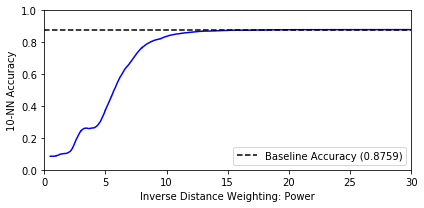

In [236]:
# Accuracy-vs-power plot
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,3)
x = sorted(idw_power_plot_data.keys())
y = [idw_power_plot_data[p]["Accuracy"] for p in x]
#plt.title("IDW - Accuracy vs Power") # We'd better use figure caption
#ax.legend([h1,h2,h3,h4,h5,h6], ["Closest Training Set Image"]+idw_method_list)
plt.plot(x,y, c='blue')
h = plt.axhline(y=baseline_accuracy, c = 'black', linestyle='--')
plt.legend([h],["Baseline Accuracy (%.4f)"%baseline_accuracy])
plt.xlabel("Inverse Distance Weighting: Power")
plt.ylabel("10-NN Accuracy")
plt.ylim([0,1])
plt.xlim([0,30])
f.tight_layout()
plt.savefig("Figures/IDW-power-vs-accuracy.png")
plt.show(f)

[90, 95, 99, 100]


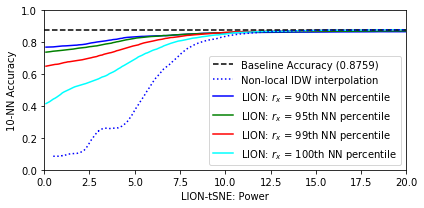

In [237]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,3)
power_perc_combos = lion_power_plot_data.keys()
all_percentages = sorted(set([int(i.split(';')[0]) for i in power_perc_combos]))
x = sorted(set([float(i.split(';')[1]) for i in power_perc_combos]))
color_dict = {90:'blue', 95:'green',99:'red',100:'cyan'}
legend_list = list()
legend_lines = list()
print(all_percentages)
for perc in all_percentages:
    y = list()
    for cur_power in x:
        key = "%d;%.3f"%(perc,cur_power)
        y.append(lion_power_plot_data[key]["Accuracy"])
    h, = plt.plot(x,y, c=color_dict[perc])
    legend_lines.append(h)
    legend_list.append(r"LION: $r_x$ = "+str(perc)+"th NN percentile")
#plt.title("IDW - Accuracy vs Power") # We'd better use figure caption
#ax.legend([h1,h2,h3,h4,h5,h6], ["Closest Training Set Image"]+idw_method_list)
h = plt.axhline(y=baseline_accuracy, c = 'black', linestyle='--')
x = sorted(idw_power_plot_data.keys())
y = [idw_power_plot_data[p]["Accuracy"] for p in x]
h2, = plt.plot(x,y, c='blue',linestyle=':')
plt.legend([h,h2]+legend_lines,["Baseline Accuracy (%.4f)"%baseline_accuracy, "Non-local IDW interpolation"]+legend_list)
plt.xlabel("LION-tSNE: Power")
plt.ylabel("10-NN Accuracy")
plt.ylim([0,1])
plt.xlim([0,20])
f.tight_layout()
plt.savefig("Figures/LION-and-IDW-power-vs-accuracy.png")
plt.show(f)

In [ ]:
# Let's see power influence using training data only
lion_power_plot_data

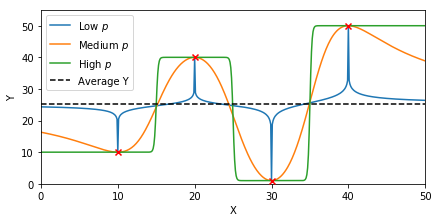

In [185]:
# This is 1-D illustration of "pull to the center" effect. Plot will appear in the discussion section
x_1d = np.array([[10],[20],[30],[40]])
y_1d = np.array([[10],[40],[1],[50]])
simple_example_model = lion_tsne.LionTSNE(perplexity=2)
simple_example_model.incorporate(x_1d, y_1d)

x = np.arange(0,50,0.1).reshape((-1,1))

powers_and_colors = {0.2 : 'blue', 2 : 'red', 20 : 'green'}
legend_by_p = {0.2 : r'Low $p$', 2 : r'Medium $p$', 20 : r'High $p$'}

plt.gcf().set_size_inches(6,3)
legend_list = list()
for p in powers_and_colors:
    interpolator = simple_example_model.generate_embedding_function(embedding_function_type='weighted-inverse-distance',
                                                                   function_kwargs={'power' : p})
    y_weighted = interpolator(x)
    plt.plot(x,y_weighted)
    legend_list.append(legend_by_p[p]) #To ensure proper order
plt.ylim([0,55])
plt.xlim([0,50])
plt.axhline(y=np.mean(y_1d), c = 'black', linestyle='--')
plt.tight_layout()
plt.legend(legend_list+["Average Y"])
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(x_1d,y_1d,c='red',marker='x',zorder=3)
plt.savefig("Figures/IDW-power-influence.png")
plt.show()

In [ ]:
# TODO Need max, min and average weight for powers 0.5, 1, 2, 10 and 20
# Or should we just use illustration?

In [ ]:
# TODO This is 

In [ ]:
# TODO: What about NN-distance-vs-power plot (especially for outliers? not needed, for outliers we'll use another method anyway)

## Repeated Gradient Descent Application

In [186]:
# Doing it from scratch takes REALLY long time. If possible, save results & pre-load

# These are consequences of parallelization
input_files = ['gd_results'+str(100*i)+'_'+str(100*i+100)+'.p' for i in range(10)]
output_file = 'gd_results.p'
covered_samples = list()

first_sample_inc = 0 #Change only if it is one of "Other notebooks just for parallelization"
last_sample_exclusive = len(picked_neighbors)

#Let's build all possible combinations. Later we'll decide what to plot
picked_neighbors_y_gd_transformed = np.zeros((len(picked_neighbors), Y_mnist.shape[1]))
picked_neighbors_y_gd_variance_recalc_transformed = np.zeros((len(picked_neighbors), Y_mnist.shape[1]))
picked_neighbors_y_gd_transformed_random = np.zeros((len(picked_neighbors), Y_mnist.shape[1]))
picked_neighbors_y_gd_variance_recalc_transformed_random = np.zeros((len(picked_neighbors), Y_mnist.shape[1]))

picked_neighbors_y_gd_early_exagg_transformed_random = np.zeros((len(picked_neighbors), Y_mnist.shape[1]))
picked_neighbors_y_gd_early_exagg_transformed = np.zeros((len(picked_neighbors), Y_mnist.shape[1]))
picked_neighbors_y_gd_variance_recalc_early_exagg_transformed_random = np.zeros((len(picked_neighbors), Y_mnist.shape[1]))
picked_neighbors_y_gd_variance_recalc_early_exagg_transformed = np.zeros((len(picked_neighbors), Y_mnist.shape[1]))

picked_random_starting_positions = np.zeros((len(picked_neighbors), Y_mnist.shape[1]))

for fname in input_files:
    if not os.path.isfile(fname):
        print("File not found: ",fname)
    else:
        with open(fname, 'rb') as f:
            cur_gd_transformed, cur_gd_variance_recalc_transformed, \
            cur_gd_transformed_random, cur_gd_variance_recalc_transformed_random, \
            cur_gd_early_exagg_transformed_random, cur_gd_early_exagg_transformed, \
            cur_gd_variance_recalc_early_exagg_transformed_random, cur_random_starting_positions, \
            cur_gd_variance_recalc_early_exagg_transformed, cur_covered_samples = pickle.load(f)
        print(cur_covered_samples)
        # Each files covers only part of samples
        for i in cur_covered_samples:
            print("\tLoaded sample ",i)
            picked_neighbors_y_gd_transformed[i,:] = cur_gd_transformed[i,:]
            picked_neighbors_y_gd_variance_recalc_transformed[i,:] = cur_gd_variance_recalc_transformed[i,:]
            picked_random_starting_positions[i,:] = cur_random_starting_positions[i,:]
            picked_neighbors_y_gd_transformed_random[i,:] = cur_gd_transformed_random[i,:]
            picked_neighbors_y_gd_variance_recalc_transformed_random[i,:] = cur_gd_variance_recalc_transformed_random[i,:]
            picked_neighbors_y_gd_early_exagg_transformed_random[i,:] = cur_gd_early_exagg_transformed_random[i,:]
            picked_neighbors_y_gd_early_exagg_transformed[i,:] = picked_neighbors_y_gd_early_exagg_transformed[i,:]
            picked_neighbors_y_gd_variance_recalc_early_exagg_transformed_random[i,:] = \
                            cur_gd_variance_recalc_early_exagg_transformed_random[i,:] 
            picked_neighbors_y_gd_variance_recalc_early_exagg_transformed[i,:] = \
                            cur_gd_variance_recalc_early_exagg_transformed[i,:]
            covered_samples.append(i)
            
    
for i in range(first_sample_inc, last_sample_exclusive):
    np.random.seed(i) # We reset random seed every time. Otherwise, if you load partial results from file, everything
    # will depend on which parts were loaded, random sequence will "shift" depend on that, and reproducibility will be lost.
    # I.e. if put seed(0) before the loop and start from scratch, then you will have some random sequence [abc] for sample 0,
    # other (continuation of that sequence) [def] for sample 1, etc. But if you already loaded sample 0 from file, you will
    # have [abc] for sample 1, [def] for sample 2, etc. Reproducibility should not depend on what parts are loaded.
    # Hence, random seed every time, and it depends on ABSOLUTE sample number.
    print(" ====================== Sample ",i,"\n\n")
    if i in covered_samples:
        print("Already loaded.")
    else:
        neighbor = picked_neighbors[i].reshape((1,-1))
        picked_neighbors_y_gd_transformed[i,:] = dTSNE_mnist.transform(neighbor,y='closest',
                                                                       verbose=2,optimizer_kwargs={'early_exaggeration':None})
        picked_neighbors_y_gd_variance_recalc_transformed[i,:] = dTSNE_mnist.transform(neighbor, keep_sigmas=False,y='closest',
                                                                       verbose=2,optimizer_kwargs={'early_exaggeration':None})

        #Let's pick random starts at any point. not necessary near the center.
        y_start = np.array([[
            np.random.uniform(np.min(Y_mnist[:,0]),np.max(Y_mnist[:,0])),
            np.random.uniform(np.min(Y_mnist[:,1]),np.max(Y_mnist[:,1]))
        ]])

        picked_random_starting_positions[i,:] = y_start

        picked_neighbors_y_gd_transformed_random[i,:] = dTSNE_mnist.transform(neighbor, y=y_start, #y='random',
                                                                       verbose=2,optimizer_kwargs={'early_exaggeration':None})
        picked_neighbors_y_gd_variance_recalc_transformed_random[i,:] = dTSNE_mnist.transform(neighbor,
                                                                        keep_sigmas=False, y=y_start, #y='random',
                                                                        verbose=2,optimizer_kwargs={'early_exaggeration':None})


        picked_neighbors_y_gd_early_exagg_transformed_random[i,:] = dTSNE_mnist.transform(neighbor,y=y_start, #y='random',
                                                                       verbose=2)
        picked_neighbors_y_gd_early_exagg_transformed[i,:] = dTSNE_mnist.transform(neighbor, y='closest', verbose=2)

        picked_neighbors_y_gd_variance_recalc_early_exagg_transformed_random[i,:] = dTSNE_mnist.transform(neighbor,y=y_start,
                                                                       keep_sigmas=False, verbose=2)
        picked_neighbors_y_gd_variance_recalc_early_exagg_transformed[i,:] = dTSNE_mnist.transform(neighbor, keep_sigmas=False,
                                                                        y='closest', verbose=2)

        covered_samples.append(i)
    # Re-saving even if it is a loaded sample
    print("Saving...")
    # Gradient descent results take a long while. Let's cache.
    with open(output_file, 'wb') as f:
        pickle.dump( (picked_neighbors_y_gd_transformed, picked_neighbors_y_gd_variance_recalc_transformed,
            picked_neighbors_y_gd_transformed_random, picked_neighbors_y_gd_variance_recalc_transformed_random,
            picked_neighbors_y_gd_early_exagg_transformed_random, picked_neighbors_y_gd_early_exagg_transformed,
            picked_neighbors_y_gd_variance_recalc_early_exagg_transformed_random, picked_random_starting_positions,
            picked_neighbors_y_gd_variance_recalc_early_exagg_transformed, covered_samples), f)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
	Loaded sample  0
	Loaded sample  1
	Loaded sample  2
	Loaded sample  3
	Loaded sample  4
	Loaded sample  5
	Loaded sample  6
	Loaded sample  7
	Loaded sample  8
	Loaded sample  9
	Loaded sample  10
	Loaded sample  11
	Loaded sample  12
	Loaded sample  13
	Loaded sample  14
	Loaded sample  15
	Loaded sample  16
	Loaded sample  17
	Loaded sample  18
	Loaded sample  19
	Loaded sample  20
	Loaded sample  21
	Loaded sample  22
	Loaded sample  23
	Loaded sample  24
	Loaded sample  25
	Loaded sample  26
	Loaded sample  27
	Loaded sample  28
	Loaded sample  29
	Loaded sample  30
	Loaded sample  31
	Loaded sam

	Loaded sample  591
	Loaded sample  592
	Loaded sample  593
	Loaded sample  594
	Loaded sample  595
	Loaded sample  596
	Loaded sample  597
	Loaded sample  598
	Loaded sample  599
[600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699]
	Loaded sample  600
	Loaded sample  601
	Loaded sample  602
	Loaded sample  603
	Loaded sample  604
	Loaded sample  605
	Loaded sample  606
	Loaded sample  607
	Loaded sample  608
	Loaded sample  609
	Loaded sample  610
	Loaded sample  611
	Loaded sample  612
	Loaded sample  613
	Loaded sample  614
	Loaded sample  615

Saving...
 ====================== Sample  202 


Already loaded.
Saving...
 ====================== Sample  203 


Already loaded.
Saving...
 ====================== Sample  204 


Already loaded.
Saving...
 ====================== Sample  205 


Already loaded.
Saving...
 ====================== Sample  206 


Already loaded.
Saving...
 ====================== Sample  207 


Already loaded.
Saving...
 ====================== Sample  208 


Already loaded.
Saving...
 ====================== Sample  209 


Already loaded.
Saving...
 ====================== Sample  210 


Already loaded.
Saving...
 ====================== Sample  211 


Already loaded.
Saving...
 ====================== Sample  212 


Already loaded.
Saving...
 ====================== Sample  213 


Already loaded.
Saving...
 ====================== Sample  214 


Already loaded.
Saving...
 ====================== Sample  215 


Already loaded.
Saving...
 ====================== Sample  216 


Already loaded.
Saving...
 ==============

 ====================== Sample  531 


Already loaded.
Saving...
 ====================== Sample  532 


Already loaded.
Saving...
 ====================== Sample  533 


Already loaded.
Saving...
 ====================== Sample  534 


Already loaded.
Saving...
 ====================== Sample  535 


Already loaded.
Saving...
 ====================== Sample  536 


Already loaded.
Saving...
 ====================== Sample  537 


Already loaded.
Saving...
 ====================== Sample  538 


Already loaded.
Saving...
 ====================== Sample  539 


Already loaded.
Saving...
 ====================== Sample  540 


Already loaded.
Saving...
 ====================== Sample  541 


Already loaded.
Saving...
 ====================== Sample  542 


Already loaded.
Saving...
 ====================== Sample  543 


Already loaded.
Saving...
 ====================== Sample  544 


Already loaded.
Saving...
 ====================== Sample  545 


Already loaded.
Saving...
 ====================== S

 ====================== Sample  808 


Already loaded.
Saving...
 ====================== Sample  809 


Already loaded.
Saving...
 ====================== Sample  810 


Already loaded.
Saving...
 ====================== Sample  811 


Already loaded.
Saving...
 ====================== Sample  812 


Already loaded.
Saving...
 ====================== Sample  813 


Already loaded.
Saving...
 ====================== Sample  814 


Already loaded.
Saving...
 ====================== Sample  815 


Already loaded.
Saving...
 ====================== Sample  816 


Already loaded.
Saving...
 ====================== Sample  817 


Already loaded.
Saving...
 ====================== Sample  818 


Already loaded.
Saving...
 ====================== Sample  819 


Already loaded.
Saving...
 ====================== Sample  820 


Already loaded.
Saving...
 ====================== Sample  821 


Already loaded.
Saving...
 ====================== Sample  822 


Already loaded.
Saving...
 ====================== S

In [187]:
gd_method_list = [r'Closest $Y_{init}$',
              r'Random $Y_{init}$',
              r'Closest $Y_{init}$; new $\sigma$',
              r'Random $Y_{init}$; new $\sigma$',                             
              r'Closest $Y_{init}$; EE',
              r'Random $Y_{init}$; EE',
              r'Closest $Y_{init}$; new $\sigma$; EE',
              r'Random $Y_{init}$; new $\sigma$; EE']

gd_method_results = [
    picked_neighbors_y_gd_transformed,
    picked_neighbors_y_gd_transformed_random,
    picked_neighbors_y_gd_variance_recalc_transformed,
    picked_neighbors_y_gd_variance_recalc_transformed_random,
    picked_neighbors_y_gd_early_exagg_transformed,
    picked_neighbors_y_gd_early_exagg_transformed_random,
    picked_neighbors_y_gd_variance_recalc_early_exagg_transformed,
    picked_neighbors_y_gd_variance_recalc_early_exagg_transformed_random,    
]

In [188]:
gd_kl = np.zeros((len(gd_method_list), len(picked_neighbors)))

processed_indices = list()

kl_gd_performance_file = 'kl_gd_performance.p'
if os.path.isfile(kl_gd_performance_file):
    with open(kl_gd_performance_file, 'rb') as f:
        gd_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(picked_neighbors),))
for i in range(len(picked_neighbors)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, picked_neighbors[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = lion_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(gd_method_results)):
        # Single file with p matrix
        new_Y = np.concatenate((Y_mnist, gd_method_results[j][i,:].reshape((1,-1))), axis=0)
        gd_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_gd_performance_file,'wb') as f:
        pickle.dump((gd_kl, processed_indices), f)
# This should be fast
gd_avg_kl = np.mean(gd_kl, axis=1) 

Sample 0 already processed. Results loaded.
Sample 1 already processed. Results loaded.
Sample 2 already processed. Results loaded.
Sample 3 already processed. Results loaded.
Sample 4 already processed. Results loaded.
Sample 5 already processed. Results loaded.
Sample 6 already processed. Results loaded.
Sample 7 already processed. Results loaded.
Sample 8 already processed. Results loaded.
Sample 9 already processed. Results loaded.
Sample 10 already processed. Results loaded.
Sample 11 already processed. Results loaded.
Sample 12 already processed. Results loaded.
Sample 13 already processed. Results loaded.
Sample 14 already processed. Results loaded.
Sample 15 already processed. Results loaded.
Sample 16 already processed. Results loaded.
Sample 17 already processed. Results loaded.
Sample 18 already processed. Results loaded.
Sample 19 already processed. Results loaded.
Sample 20 already processed. Results loaded.
Sample 21 already processed. Results loaded.
Sample 22 already pr

Sample 465 already processed. Results loaded.
Sample 466 already processed. Results loaded.
Sample 467 already processed. Results loaded.
Sample 468 already processed. Results loaded.
Sample 469 already processed. Results loaded.
Sample 470 already processed. Results loaded.
Sample 471 already processed. Results loaded.
Sample 472 already processed. Results loaded.
Sample 473 already processed. Results loaded.
Sample 474 already processed. Results loaded.
Sample 475 already processed. Results loaded.
Sample 476 already processed. Results loaded.
Sample 477 already processed. Results loaded.
Sample 478 already processed. Results loaded.
Sample 479 already processed. Results loaded.
Sample 480 already processed. Results loaded.
Sample 481 already processed. Results loaded.
Sample 482 already processed. Results loaded.
Sample 483 already processed. Results loaded.
Sample 484 already processed. Results loaded.
Sample 485 already processed. Results loaded.
Sample 486 already processed. Resu

In [439]:
original_kl, _ = lion_tsne.kl_divergence_and_gradient(p_matrix=dTSNE_mnist.P_matrix, y=dTSNE_mnist.Y)
print("Original KL divergence", original_kl)

print("APPROXIMATION KL DIVERGENCES")
nn_kl_list = list()
for j in range(len(nn_method_results)):
    orig_div, _ = lion_tsne.kl_divergence_and_gradient(p_matrix=dTSNE_mnist.P_matrix, y=nn_models_orig[j])
    nn_kl_list.append(orig_div)
    print(nn_method_list[j], orig_div)

Original KL divergence 1.11687680132
APPROXIMATION KL DIVERGENCES
NN - 2L; 250N; ReLu; D0.25 1.37019653219
NN - 2L; 500N; ReLu; D0.5 1.40518859904
NN - 1L; 500N; tanh 1.13159196146


In [448]:
# Make a table for LaTeX
width_share = math.floor(100*0.8 / (len(lion_optimal_power)))/100

print('\t\\begin{table*} \caption{KL divergences after approximation}  \label{tab_nn_kl_div}')
print('\t\t\\begin{tabular}{| M{0.23\\textwidth} '+ ('| M{%.2f\\textwidth}'%width_share)*(len(nn_method_list)) + ' |}')
print('\t\t\t\\hline')
print('\t\t\t \\textbf{Configuration} '+
      ''.join(['& %s '%i[5:] for i in nn_method_list]))
print('\t\t\t\\\\ \\hline')
print('\t\t\t \\textbf{KL divergence} '+
      ''.join(['& %.7f '%nn_kl_list[i] for i in range(len(nn_method_list))]))
print('\t\\\\ \\hline')    
print('\t\t\\end{tabular}')
print('\t\\end{table*}')  

	\begin{table*} \caption{KL divergences after approximation}  \label{tab_nn_kl_div}
		\begin{tabular}{| M{0.23\textwidth} | M{0.20\textwidth}| M{0.20\textwidth}| M{0.20\textwidth} |}
			\hline
			 \textbf{Configuration} & 2L; 250N; ReLu; D0.25 & 2L; 500N; ReLu; D0.5 & 1L; 500N; tanh 
			\\ \hline
			 \textbf{KL divergence} & 1.3701965 & 1.4051886 & 1.1315920 
	\\ \hline
		\end{tabular}
	\end{table*}


In [189]:
gd_nearest_neighbors_percentiles_matrix = np.zeros((len(picked_neighbors), len(gd_method_list)))
for i in range(len(picked_neighbors)):
    for j in range(len(gd_method_list)):
        y = gd_method_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((Y_mnist-y)**2, axis=1)))
        gd_nearest_neighbors_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
gd_distance_percentiles = np.mean(gd_nearest_neighbors_percentiles_matrix, axis=0) 
for j in range(len(gd_method_list)):
    print(gd_method_list[j], gd_distance_percentiles[j])

Closest $Y_{init}$ 11.00208
Random $Y_{init}$ 75.61276
Closest $Y_{init}$; new $\sigma$ 15.0722
Random $Y_{init}$; new $\sigma$ 78.39788
Closest $Y_{init}$; EE 50.2
Random $Y_{init}$; EE 57.10004
Closest $Y_{init}$; new $\sigma$; EE 15.20316
Random $Y_{init}$; new $\sigma$; EE 60.3636


In [433]:
D.shape

(2500, 2500)

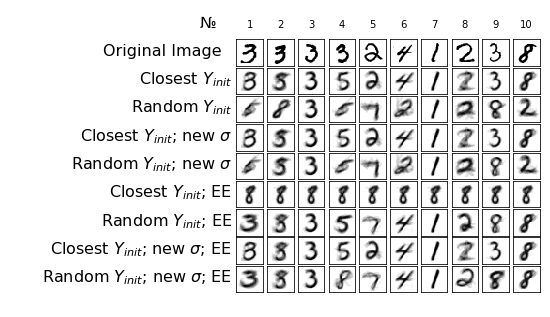

In [190]:
# Another way to check whether we are in the same cluster:
# For ending Y, pick several nearest neighbors in Y space, get their Xs, average them out and print.
width = shown_indices
height = len(gd_method_results)

gs = gridspec.GridSpec(height+2, width+1, width_ratios=[8]+[1]*width)     
    
width = shown_indices #total number to show
start_index = 0

f, ax_total = plt.subplots()

# First row - number of examples
plt.subplot(gs[0]).set_axis_off()
plt.subplot(gs[width+1]).set_axis_off()
plt.subplot(gs[0]).text(text="№   ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)
plt.subplot(gs[width+1]).text(text="Original Image  ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)

f.set_size_inches(7,4)
f.subplots_adjust()

for j in range(len(gd_method_results)):
    sp = plt.subplot(gs[(j+2)*(width+1)])
    sp.text(text=gd_method_list[j],x=1.0, y=0.4,s=11, ha='right', fontsize=16)
    sp.set_axis_off()
    
# It is just a plot, let's make it simple and use 2 loop rather than vectorization
for i in range(width):
    orig_sp = plt.subplot(gs[width+i+2])
    orig_sp.imshow(X_mnist_raw[picked_indices[i], :].reshape(28,28), cmap='gray_r')
    orig_sp.axes.get_xaxis().set_visible(False)
    orig_sp.axes.get_yaxis().set_visible(False)
    num_sp = plt.subplot(gs[i+1])
    num_sp.text(text=str(i+1),x=0.5, y=0.5,s=11, ha='center', va='center', fontsize=10)
    num_sp.set_axis_off()
    for j in range(len(gd_method_results)):
        sp = plt.subplot(gs[(j+2)*(width+1) + i+1])
        nn_indices = get_nearest_neighbors_in_y(gd_method_results[j][i,:], n=illustration_nn)
        average_image = np.mean(X_mnist_raw[nn_indices,:], axis=0).reshape(28,28)
        sp.imshow(average_image, cmap='gray_r')
        sp.axes.get_xaxis().set_visible(False)
        sp.axes.get_yaxis().set_visible(False)
#gs.tight_layout(f)
gs.update(wspace=0.1, hspace=0.025)
f.subplots_adjust(left=-0.04, right=0.99, top=0.99,bottom=0.01)

plt.show(f)
f.savefig("Figures/gd_clustered_nearest_neighbors.png")
plt.close()

In [191]:
gd_accuracy = np.zeros((len(gd_method_list,)))

for j in range(len(gd_method_results)):
    per_sample_accuracy = np.zeros((len(picked_neighbors),))
    for i in range(len(picked_neighbors)):
        expected_label = picked_neighbor_labels[i]
        nn_indices = get_nearest_neighbors_in_y(gd_method_results[j][i,:], n=accuracy_nn)
        obtained_labels = labels_mnist[nn_indices]
        per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
    gd_accuracy[j] = np.mean(per_sample_accuracy) 
    print(gd_method_list[j], ":\t", gd_accuracy[j])

Closest $Y_{init}$ :	 0.7632
Random $Y_{init}$ :	 0.3035
Closest $Y_{init}$; new $\sigma$ :	 0.7632
Random $Y_{init}$; new $\sigma$ :	 0.2914
Closest $Y_{init}$; EE :	 0.085
Random $Y_{init}$; EE :	 0.4253
Closest $Y_{init}$; new $\sigma$; EE :	 0.763
Random $Y_{init}$; new $\sigma$; EE :	 0.4236


In [192]:
# TODO - average distance from the starting position, along with accuracy.

In [193]:
picked_random_starting_positions.shape

(1000, 2)

There is a tendency not to move much.

% TODO Try to use poor local optima avoidance

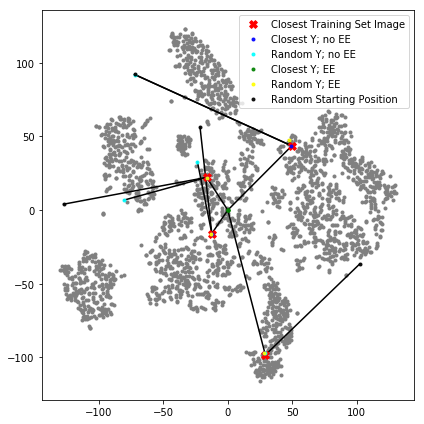

In [194]:
cur_shown_indices = [1,5,6,9]

legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20)
#chosen_indices = list(range(cur_shown_indices))
#chosen_indices = [3]
for l in cur_shown_indices:
#    if l in chosen_indices:
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gd_transformed[l,0]],
                 [picked_indices_y_mnist[l,1], picked_neighbors_y_gd_transformed[l,1]], c='black', label=None, zorder=2)
        #ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gd_variance_recalc_transformed[l,0]],
        #        [picked_indices_y_mnist[l,1], picked_neighbors_y_gd_variance_recalc_transformed[l,1]], c='black', label=None,
        #        zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gd_transformed_random[l,0]],
                [picked_indices_y_mnist[l,1], picked_neighbors_y_gd_transformed_random[l,1]], c='black', label=None, zorder=2)
        #ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gd_variance_recalc_transformed_random[l,0]],
        #        [picked_indices_y_mnist[l,1], picked_neighbors_y_gd_variance_recalc_transformed_random[l,1]], c='black',
        #        label=None, zorder=2) 
        
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gd_early_exagg_transformed[l,0]],
                [picked_indices_y_mnist[l,1], picked_neighbors_y_gd_early_exagg_transformed[l,1]], c='black', label=None, zorder=2)
        #ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gd_variance_recalc_early_exagg_transformed[l,0]],
        #        [picked_indices_y_mnist[l,1], picked_neighbors_y_gd_variance_recalc_early_exagg_transformed[l,1]], c='black', label=None,
        #        zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gd_early_exagg_transformed_random[l,0]],
                [picked_indices_y_mnist[l,1], picked_neighbors_y_gd_early_exagg_transformed_random[l,1]], c='black', label=None, zorder=2)
        #ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gd_variance_recalc_early_exagg_transformed_random[l,0]],
        #        [picked_indices_y_mnist[l,1], picked_neighbors_y_gd_variance_recalc_early_exagg_transformed_random[l,1]], c='black',
        #        label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_neighbors_y_gd_early_exagg_transformed_random[l,0]],
                [picked_indices_y_mnist[l,1], picked_neighbors_y_gd_early_exagg_transformed_random[l,1]], c='black',
                label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], picked_random_starting_positions[l,0]],
                [picked_indices_y_mnist[l,1], picked_random_starting_positions[l,1]], c='black', label=None, zorder=2)
    
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
#legend_list.append(str(l))
h1 = ax.scatter(picked_indices_y_mnist[cur_shown_indices,0],
                picked_indices_y_mnist[cur_shown_indices,1], c='red', marker='X', s=60, zorder=3)
h2 = ax.scatter(picked_neighbors_y_gd_transformed[cur_shown_indices,0],
                picked_neighbors_y_gd_transformed[cur_shown_indices,1], c='blue', marker='.',zorder=3,alpha=0.9)
h3 = ax.scatter(picked_neighbors_y_gd_transformed_random[cur_shown_indices,0],
                picked_neighbors_y_gd_transformed_random[cur_shown_indices,1], c='cyan', marker='.', zorder=3,alpha=0.9)
#h4 = ax.scatter(picked_neighbors_y_gd_variance_recalc_transformed[:cur_shown_indices,0],
#                picked_neighbors_y_gd_variance_recalc_transformed[:cur_shown_indices,1], c='green', marker='.', zorder=3,alpha=0.9)
#h5 = ax.scatter(picked_neighbors_y_gd_variance_recalc_transformed_random[:cur_shown_indices,0],
#                picked_neighbors_y_gd_variance_recalc_transformed_random[:cur_shown_indices,1],
#                c='brown', marker='.', zorder=3,alpha=0.9)
h6 = ax.scatter(picked_neighbors_y_gd_early_exagg_transformed[cur_shown_indices,0],
                picked_neighbors_y_gd_early_exagg_transformed[cur_shown_indices,1], c='green', marker='.',zorder=3,alpha=0.9)
h7 = ax.scatter(picked_neighbors_y_gd_early_exagg_transformed_random[cur_shown_indices,0],
                picked_neighbors_y_gd_early_exagg_transformed_random[cur_shown_indices,1],
                c='yellow', marker='.', zorder=3,alpha=0.9)
#h8 = ax.scatter(picked_neighbors_y_gd_variance_recalc_early_exagg_transformed[:cur_shown_indices,0],
#                picked_neighbors_y_gd_variance_recalc_early_exagg_transformed[:cur_shown_indices,1],
#                c='black', marker='.', zorder=3,alpha=0.9)
#h9 = ax.scatter(picked_neighbors_y_gd_variance_recalc_early_exagg_transformed_random[:cur_shown_indices,0],
#                picked_neighbors_y_gd_variance_recalc_early_exagg_transformed_random[:cur_shown_indices,1],
#                c='olive', marker='.', zorder=3,alpha=0.9)
h10 = ax.scatter(picked_random_starting_positions[cur_shown_indices,0],
                 picked_random_starting_positions[cur_shown_indices,1], c='black', marker='.', zorder=3,alpha=0.9)

ax.legend([h1,h2,h3,h6,h7,h10], ["Closest Training Set Image",
                                        r'Closest Y; no EE',
                                        r'Random Y; no EE',
                                        #r'Closest Y; new $\sigma$; no EE',
                                        #r'Random Y; new $\sigma$; no EE',                             
                                        r'Closest Y; EE',
                                        r'Random Y; EE',
                                        #r'Closest Y; new $\sigma$; EE',
                                        #r'Random Y; new $\sigma$; EE',
                                        'Random Starting Position'
                            ])
f.tight_layout()
plt.savefig("Figures/neighbor-test-GD.png")
plt.show(f)

## Neural Network Approximation

In [355]:
import keras

Using TensorFlow backend.


In [391]:
regenerate_model1 = False
model1_weights_file = 'model1.hd5'
model1_json_file = 'model1.json'
if not os.path.isfile(model1_weights_file) or regenerate_model1:
    # 2 layers, 250 nodes per layer, ReLu activation, dropout regularization with rate of 0.25.]
    
    model1 = keras.models.Sequential()
    model1.add(keras.layers.Dense(250, activation='relu', kernel_initializer='normal', input_dim = X_mnist.shape[1]))
    model1.add(keras.layers.Dropout(0.25))
    model1.add(keras.layers.Dense(250, activation='relu', kernel_initializer='normal', input_dim = X_mnist.shape[1]))
    model1.add(keras.layers.Dropout(0.25))
    model1.add(keras.layers.Dense(Y_mnist.shape[1], kernel_initializer='normal'))
    model1.compile(loss='mean_squared_error', optimizer='adam')
    model1.fit(X_mnist, Y_mnist,
              epochs=5000,
              verbose=1,
              validation_data=(X_mnist, Y_mnist))
    with open(model1_json_file,"w") as f:
        f.write(model1.to_json())
    model1.save_weights(model1_weights_file)
else:
    with open(model1_json_file,"r") as f:
        model1 = keras.models.model_from_json(f.read())    
    model1.load_weights(model1_weights_file)
    model1.compile(loss='mean_squared_error', optimizer='adam')
    
picked_neighbors_y_nn1 = model1.predict(picked_neighbors)
Y_nn1_mnist = model1.predict(X_mnist)

score = model1.evaluate(X_mnist, Y_mnist, verbose=0)
score

2.7556740180969239

In [392]:
regenerate_model2 = False
model2_weights_file = 'model2.hd5'
model2_json_file = 'model2.json'
if not os.path.isfile(model2_weights_file) or regenerate_model2:
    # 2 layers, 500 nodes per layer, ReLu activation, dropout regularization with rate of 0.5.]
    
    model2 = keras.models.Sequential()
    model2.add(keras.layers.Dense(500, activation='relu', kernel_initializer='normal', input_dim = X_mnist.shape[1]))
    model2.add(keras.layers.Dropout(0.5))
    model2.add(keras.layers.Dense(500, activation='relu', kernel_initializer='normal', input_dim = X_mnist.shape[1]))
    model2.add(keras.layers.Dropout(0.5))
    model2.add(keras.layers.Dense(Y_mnist.shape[1], kernel_initializer='normal'))
    model2.compile(loss='mean_squared_error', optimizer='adam')
    model2.fit(X_mnist, Y_mnist,
              epochs=5000,
              verbose=1,
              validation_data=(X_mnist, Y_mnist))
    with open(model2_json_file,"w") as f:
        f.write(model2.to_json())
    model2.save_weights(model2_weights_file)
else:
    with open(model2_json_file,"r") as f:
        model2 = keras.models.model_from_json(f.read())    
    model2.load_weights(model2_weights_file)
    model2.compile(loss='mean_squared_error', optimizer='adam')
    
picked_neighbors_y_nn2 = model2.predict(picked_neighbors)
Y_nn2_mnist = model2.predict(X_mnist)

score = model2.evaluate(X_mnist, Y_mnist, verbose=0)

In [397]:
regenerate_model3 = True
model3_weights_file = 'model3.hd5'
model3_json_file = 'model3.json'
if not os.path.isfile(model3_weights_file) or regenerate_model3:
    # 2 layers, 500 nodes per layer, ReLu activation, dropout regularization with rate of 0.5.]
    
    model3 = keras.models.Sequential()
    model3.add(keras.layers.Dense(500, activation='tanh', kernel_initializer='normal', input_dim = X_mnist.shape[1]))
    model3.add(keras.layers.Dense(Y_mnist.shape[1], kernel_initializer='normal'))
    model3.compile(loss='mean_squared_error', optimizer='adam')
    model3.fit(X_mnist, Y_mnist,
              epochs=5000,
              verbose=1,
              validation_data=(X_mnist, Y_mnist))
    with open(model3_json_file,"w") as f:
        f.write(model3.to_json())
    model3.save_weights(model3_weights_file)
else:
    with open(model3_json_file,"r") as f:
        model3 = keras.models.model_from_json(f.read())    
    model3.load_weights(model3_weights_file)
    model3.compile(loss='mean_squared_error', optimizer='adam')
    
picked_neighbors_y_nn3 = model3.predict(picked_neighbors)
Y_nn3_mnist = model3.predict(X_mnist)

score = model3.evaluate(X_mnist, Y_mnist, verbose=0)

Train on 2500 samples, validate on 2500 samples
Epoch 1/5000
2500/2500 [==============================] - 0s - loss: 3088.6690 - val_loss: 2559.6575
Epoch 2/5000
2500/2500 [==============================] - 0s - loss: 1946.9716 - val_loss: 1377.4478
Epoch 3/5000
2500/2500 [==============================] - 0s - loss: 1127.1485 - val_loss: 953.0050
Epoch 4/5000
2500/2500 [==============================] - 0s - loss: 915.8207 - val_loss: 877.8092
Epoch 5/5000
2500/2500 [==============================] - 0s - loss: 875.6010 - val_loss: 856.4749
Epoch 6/5000
2500/2500 [==============================] - 0s - loss: 857.0346 - val_loss: 839.6753
Epoch 7/5000
2500/2500 [==============================] - 0s - loss: 840.8318 - val_loss: 823.3900
Epoch 8/5000
2500/2500 [==============================] - 0s - loss: 823.7112 - val_loss: 806.9980
Epoch 9/5000
2500/2500 [==============================] - 0s - loss: 808.9122 - val_loss: 790.5734
Epoch 10/5000
2500/2500 [==============================]

2500/2500 [==============================] - 0s - loss: 9.5047 - val_loss: 8.1553
Epoch 165/5000
2500/2500 [==============================] - 0s - loss: 9.1603 - val_loss: 7.9784
Epoch 166/5000
2500/2500 [==============================] - 0s - loss: 8.7927 - val_loss: 7.6074
Epoch 167/5000
2500/2500 [==============================] - 0s - loss: 8.3644 - val_loss: 7.3425
Epoch 168/5000
2500/2500 [==============================] - 0s - loss: 8.0224 - val_loss: 7.0475
Epoch 169/5000
2500/2500 [==============================] - 0s - loss: 7.7802 - val_loss: 6.8945
Epoch 170/5000
2500/2500 [==============================] - 0s - loss: 7.7627 - val_loss: 6.5516
Epoch 171/5000
2500/2500 [==============================] - 0s - loss: 7.1237 - val_loss: 6.1805
Epoch 172/5000
2500/2500 [==============================] - 0s - loss: 6.7517 - val_loss: 5.9336
Epoch 173/5000
2500/2500 [==============================] - 0s - loss: 6.6798 - val_loss: 5.6354
Epoch 174/5000
2500/2500 [===================

2500/2500 [==============================] - 0s - loss: 0.1568 - val_loss: 0.1503
Epoch 333/5000
2500/2500 [==============================] - 0s - loss: 0.1884 - val_loss: 0.2068
Epoch 334/5000
2500/2500 [==============================] - 0s - loss: 0.2506 - val_loss: 0.2804
Epoch 335/5000
2500/2500 [==============================] - 0s - loss: 0.3130 - val_loss: 0.2775
Epoch 336/5000
2500/2500 [==============================] - 0s - loss: 0.2972 - val_loss: 0.2467
Epoch 337/5000
2500/2500 [==============================] - 0s - loss: 0.3732 - val_loss: 0.4345
Epoch 338/5000
2500/2500 [==============================] - 0s - loss: 0.4373 - val_loss: 0.3923
Epoch 339/5000
2500/2500 [==============================] - 0s - loss: 0.3636 - val_loss: 0.3694
Epoch 340/5000
2500/2500 [==============================] - 0s - loss: 0.3154 - val_loss: 0.2542
Epoch 341/5000
2500/2500 [==============================] - 0s - loss: 0.2659 - val_loss: 0.1925
Epoch 342/5000
2500/2500 [===================

2500/2500 [==============================] - 0s - loss: 0.2915 - val_loss: 0.2121
Epoch 501/5000
2500/2500 [==============================] - 0s - loss: 0.2467 - val_loss: 0.2355
Epoch 502/5000
2500/2500 [==============================] - 0s - loss: 0.2111 - val_loss: 0.2209
Epoch 503/5000
2500/2500 [==============================] - 0s - loss: 0.2452 - val_loss: 0.1914
Epoch 504/5000
2500/2500 [==============================] - 0s - loss: 0.2657 - val_loss: 0.1967
Epoch 505/5000
2500/2500 [==============================] - 0s - loss: 0.2110 - val_loss: 0.1651
Epoch 506/5000
2500/2500 [==============================] - 0s - loss: 0.1813 - val_loss: 0.1543
Epoch 507/5000
2500/2500 [==============================] - 0s - loss: 0.1532 - val_loss: 0.1359
Epoch 508/5000
2500/2500 [==============================] - 0s - loss: 0.1515 - val_loss: 0.1614
Epoch 509/5000
2500/2500 [==============================] - 0s - loss: 0.2238 - val_loss: 0.2171
Epoch 510/5000
2500/2500 [===================

2500/2500 [==============================] - 0s - loss: 0.1171 - val_loss: 0.1108
Epoch 669/5000
2500/2500 [==============================] - 0s - loss: 0.1289 - val_loss: 0.1315
Epoch 670/5000
2500/2500 [==============================] - 0s - loss: 0.1629 - val_loss: 0.1848
Epoch 671/5000
2500/2500 [==============================] - 0s - loss: 0.2002 - val_loss: 0.1885
Epoch 672/5000
2500/2500 [==============================] - 0s - loss: 0.2388 - val_loss: 0.2062
Epoch 673/5000
2500/2500 [==============================] - 0s - loss: 0.2280 - val_loss: 0.2558
Epoch 674/5000
2500/2500 [==============================] - 0s - loss: 0.3007 - val_loss: 0.2634
Epoch 675/5000
2500/2500 [==============================] - 0s - loss: 0.2704 - val_loss: 0.2513
Epoch 676/5000
2500/2500 [==============================] - 0s - loss: 0.2630 - val_loss: 0.2491
Epoch 677/5000
2500/2500 [==============================] - 0s - loss: 0.2715 - val_loss: 0.2609
Epoch 678/5000
2500/2500 [===================

2500/2500 [==============================] - 0s - loss: 0.1508 - val_loss: 0.1301
Epoch 837/5000
2500/2500 [==============================] - 0s - loss: 0.1121 - val_loss: 0.0880
Epoch 838/5000
2500/2500 [==============================] - 0s - loss: 0.1225 - val_loss: 0.0976
Epoch 839/5000
2500/2500 [==============================] - 0s - loss: 0.1251 - val_loss: 0.1201
Epoch 840/5000
2500/2500 [==============================] - 0s - loss: 0.1200 - val_loss: 0.1223
Epoch 841/5000
2500/2500 [==============================] - 0s - loss: 0.1522 - val_loss: 0.1326
Epoch 842/5000
2500/2500 [==============================] - 0s - loss: 0.1516 - val_loss: 0.1445
Epoch 843/5000
2500/2500 [==============================] - 0s - loss: 0.1459 - val_loss: 0.1409
Epoch 844/5000
2500/2500 [==============================] - 0s - loss: 0.1641 - val_loss: 0.2049
Epoch 845/5000
2500/2500 [==============================] - 0s - loss: 0.2765 - val_loss: 0.3084
Epoch 846/5000
2500/2500 [===================

2500/2500 [==============================] - 0s - loss: 0.1472 - val_loss: 0.1641
Epoch 1005/5000
2500/2500 [==============================] - 0s - loss: 0.1947 - val_loss: 0.2002
Epoch 1006/5000
2500/2500 [==============================] - 0s - loss: 0.2369 - val_loss: 0.2545
Epoch 1007/5000
2500/2500 [==============================] - 0s - loss: 0.2445 - val_loss: 0.2217
Epoch 1008/5000
2500/2500 [==============================] - 0s - loss: 0.3205 - val_loss: 0.2969
Epoch 1009/5000
2500/2500 [==============================] - 0s - loss: 0.2805 - val_loss: 0.3005
Epoch 1010/5000
2500/2500 [==============================] - 0s - loss: 0.2682 - val_loss: 0.1982
Epoch 1011/5000
2500/2500 [==============================] - 0s - loss: 0.2150 - val_loss: 0.1964
Epoch 1012/5000
2500/2500 [==============================] - 0s - loss: 0.1691 - val_loss: 0.1578
Epoch 1013/5000
2500/2500 [==============================] - 0s - loss: 0.1546 - val_loss: 0.1495
Epoch 1014/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1843 - val_loss: 0.1550
Epoch 1171/5000
2500/2500 [==============================] - 0s - loss: 0.1434 - val_loss: 0.1034
Epoch 1172/5000
2500/2500 [==============================] - 0s - loss: 0.1165 - val_loss: 0.1025
Epoch 1173/5000
2500/2500 [==============================] - 0s - loss: 0.1186 - val_loss: 0.0974
Epoch 1174/5000
2500/2500 [==============================] - 0s - loss: 0.1124 - val_loss: 0.0952
Epoch 1175/5000
2500/2500 [==============================] - 0s - loss: 0.1137 - val_loss: 0.1141
Epoch 1176/5000
2500/2500 [==============================] - 0s - loss: 0.1346 - val_loss: 0.1520
Epoch 1177/5000
2500/2500 [==============================] - 0s - loss: 0.1538 - val_loss: 0.1476
Epoch 1178/5000
2500/2500 [==============================] - 0s - loss: 0.1835 - val_loss: 0.1682
Epoch 1179/5000
2500/2500 [==============================] - 0s - loss: 0.1744 - val_loss: 0.1709
Epoch 1180/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1646 - val_loss: 0.1487
Epoch 1337/5000
2500/2500 [==============================] - 0s - loss: 0.1483 - val_loss: 0.1314
Epoch 1338/5000
2500/2500 [==============================] - 0s - loss: 0.1261 - val_loss: 0.1056
Epoch 1339/5000
2500/2500 [==============================] - 0s - loss: 0.1232 - val_loss: 0.1050
Epoch 1340/5000
2500/2500 [==============================] - 0s - loss: 0.1384 - val_loss: 0.1328
Epoch 1341/5000
2500/2500 [==============================] - 0s - loss: 0.1412 - val_loss: 0.1392
Epoch 1342/5000
2500/2500 [==============================] - 0s - loss: 0.1850 - val_loss: 0.1634
Epoch 1343/5000
2500/2500 [==============================] - 0s - loss: 0.1740 - val_loss: 0.1540
Epoch 1344/5000
2500/2500 [==============================] - 0s - loss: 0.1611 - val_loss: 0.1429
Epoch 1345/5000
2500/2500 [==============================] - 0s - loss: 0.1595 - val_loss: 0.1555ss: 0.155
Epoch 1346/5000
2500/2500 [

2500/2500 [==============================] - 0s - loss: 0.2459 - val_loss: 0.1750
Epoch 1503/5000
2500/2500 [==============================] - 0s - loss: 0.1860 - val_loss: 0.1183
Epoch 1504/5000
2500/2500 [==============================] - 0s - loss: 0.1450 - val_loss: 0.1051
Epoch 1505/5000
2500/2500 [==============================] - 0s - loss: 0.1168 - val_loss: 0.0999
Epoch 1506/5000
2500/2500 [==============================] - 0s - loss: 0.1087 - val_loss: 0.0881
Epoch 1507/5000
2500/2500 [==============================] - 0s - loss: 0.0855 - val_loss: 0.0691
Epoch 1508/5000
2500/2500 [==============================] - 0s - loss: 0.0671 - val_loss: 0.0683
Epoch 1509/5000
2500/2500 [==============================] - 0s - loss: 0.0679 - val_loss: 0.0625
Epoch 1510/5000
2500/2500 [==============================] - 0s - loss: 0.0703 - val_loss: 0.0757
Epoch 1511/5000
2500/2500 [==============================] - 0s - loss: 0.0838 - val_loss: 0.0860
Epoch 1512/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1403 - val_loss: 0.1239
Epoch 1669/5000
2500/2500 [==============================] - 0s - loss: 0.1440 - val_loss: 0.1310
Epoch 1670/5000
2500/2500 [==============================] - 0s - loss: 0.1330 - val_loss: 0.1196
Epoch 1671/5000
2500/2500 [==============================] - 0s - loss: 0.1366 - val_loss: 0.1682
Epoch 1672/5000
2500/2500 [==============================] - 0s - loss: 0.1752 - val_loss: 0.1858
Epoch 1673/5000
2500/2500 [==============================] - 0s - loss: 0.1648 - val_loss: 0.1270
Epoch 1674/5000
2500/2500 [==============================] - 0s - loss: 0.1748 - val_loss: 0.1312
Epoch 1675/5000
2500/2500 [==============================] - 0s - loss: 0.2353 - val_loss: 0.2393
Epoch 1676/5000
2500/2500 [==============================] - 0s - loss: 0.2567 - val_loss: 0.1992
Epoch 1677/5000
2500/2500 [==============================] - 0s - loss: 0.2276 - val_loss: 0.1788
Epoch 1678/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.0703 - val_loss: 0.0466
Epoch 1835/5000
2500/2500 [==============================] - 0s - loss: 0.0494 - val_loss: 0.0438
Epoch 1836/5000
2500/2500 [==============================] - 0s - loss: 0.0515 - val_loss: 0.0437
Epoch 1837/5000
2500/2500 [==============================] - 0s - loss: 0.0560 - val_loss: 0.0490
Epoch 1838/5000
2500/2500 [==============================] - 0s - loss: 0.0494 - val_loss: 0.0511
Epoch 1839/5000
2500/2500 [==============================] - 0s - loss: 0.0850 - val_loss: 0.0848
Epoch 1840/5000
2500/2500 [==============================] - 0s - loss: 0.1181 - val_loss: 0.1268
Epoch 1841/5000
2500/2500 [==============================] - 0s - loss: 0.1562 - val_loss: 0.1515
Epoch 1842/5000
2500/2500 [==============================] - 0s - loss: 0.2494 - val_loss: 0.2462
Epoch 1843/5000
2500/2500 [==============================] - 0s - loss: 0.2411 - val_loss: 0.2436
Epoch 1844/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.2015 - val_loss: 0.1646
Epoch 2001/5000
2500/2500 [==============================] - 0s - loss: 0.1734 - val_loss: 0.1164
Epoch 2002/5000
2500/2500 [==============================] - 0s - loss: 0.1364 - val_loss: 0.1319
Epoch 2003/5000
2500/2500 [==============================] - 0s - loss: 0.1390 - val_loss: 0.1068
Epoch 2004/5000
2500/2500 [==============================] - 0s - loss: 0.1711 - val_loss: 0.1447
Epoch 2005/5000
2500/2500 [==============================] - 0s - loss: 0.1559 - val_loss: 0.1173
Epoch 2006/5000
2500/2500 [==============================] - 0s - loss: 0.1710 - val_loss: 0.1483
Epoch 2007/5000
2500/2500 [==============================] - 0s - loss: 0.1354 - val_loss: 0.1066
Epoch 2008/5000
2500/2500 [==============================] - 0s - loss: 0.1221 - val_loss: 0.1102
Epoch 2009/5000
2500/2500 [==============================] - 0s - loss: 0.1207 - val_loss: 0.1031
Epoch 2010/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1196 - val_loss: 0.1025
Epoch 2167/5000
2500/2500 [==============================] - 0s - loss: 0.1194 - val_loss: 0.0952
Epoch 2168/5000
2500/2500 [==============================] - 0s - loss: 0.1174 - val_loss: 0.1110
Epoch 2169/5000
2500/2500 [==============================] - 0s - loss: 0.1162 - val_loss: 0.1498
Epoch 2170/5000
2500/2500 [==============================] - 0s - loss: 0.1206 - val_loss: 0.1035
Epoch 2171/5000
2500/2500 [==============================] - 0s - loss: 0.1339 - val_loss: 0.1393
Epoch 2172/5000
2500/2500 [==============================] - 0s - loss: 0.1443 - val_loss: 0.1439
Epoch 2173/5000
2500/2500 [==============================] - 0s - loss: 0.1552 - val_loss: 0.1461
Epoch 2174/5000
2500/2500 [==============================] - 0s - loss: 0.1829 - val_loss: 0.1805
Epoch 2175/5000
2500/2500 [==============================] - 0s - loss: 0.1630 - val_loss: 0.1596
Epoch 2176/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1083 - val_loss: 0.0841
Epoch 2333/5000
2500/2500 [==============================] - 0s - loss: 0.0990 - val_loss: 0.0954
Epoch 2334/5000
2500/2500 [==============================] - 0s - loss: 0.0883 - val_loss: 0.0840
Epoch 2335/5000
2500/2500 [==============================] - 0s - loss: 0.0943 - val_loss: 0.0932
Epoch 2336/5000
2500/2500 [==============================] - 0s - loss: 0.1071 - val_loss: 0.1125
Epoch 2337/5000
2500/2500 [==============================] - 0s - loss: 0.1157 - val_loss: 0.1027
Epoch 2338/5000
2500/2500 [==============================] - 0s - loss: 0.1181 - val_loss: 0.1252
Epoch 2339/5000
2500/2500 [==============================] - 0s - loss: 0.1332 - val_loss: 0.1417
Epoch 2340/5000
2500/2500 [==============================] - 0s - loss: 0.1712 - val_loss: 0.1568
Epoch 2341/5000
2500/2500 [==============================] - 0s - loss: 0.2472 - val_loss: 0.2232
Epoch 2342/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1357 - val_loss: 0.1519
Epoch 2499/5000
2500/2500 [==============================] - 0s - loss: 0.1485 - val_loss: 0.1158
Epoch 2500/5000
2500/2500 [==============================] - 0s - loss: 0.1395 - val_loss: 0.1169
Epoch 2501/5000
2500/2500 [==============================] - 0s - loss: 0.1618 - val_loss: 0.1564
Epoch 2502/5000
2500/2500 [==============================] - 0s - loss: 0.1480 - val_loss: 0.1039
Epoch 2503/5000
2500/2500 [==============================] - 0s - loss: 0.1391 - val_loss: 0.1114
Epoch 2504/5000
2500/2500 [==============================] - 0s - loss: 0.1150 - val_loss: 0.0934
Epoch 2505/5000
2500/2500 [==============================] - 0s - loss: 0.1035 - val_loss: 0.0910
Epoch 2506/5000
2500/2500 [==============================] - 0s - loss: 0.1196 - val_loss: 0.1720
Epoch 2507/5000
2500/2500 [==============================] - 0s - loss: 0.1607 - val_loss: 0.1425
Epoch 2508/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.0969 - val_loss: 0.0940
Epoch 2665/5000
2500/2500 [==============================] - 0s - loss: 0.0970 - val_loss: 0.1117
Epoch 2666/5000
2500/2500 [==============================] - 0s - loss: 0.1233 - val_loss: 0.1492
Epoch 2667/5000
2500/2500 [==============================] - 0s - loss: 0.1433 - val_loss: 0.1731
Epoch 2668/5000
2500/2500 [==============================] - 0s - loss: 0.1727 - val_loss: 0.1538ss: 0.197
Epoch 2669/5000
2500/2500 [==============================] - 0s - loss: 0.1827 - val_loss: 0.1567
Epoch 2670/5000
2500/2500 [==============================] - 0s - loss: 0.1977 - val_loss: 0.1686
Epoch 2671/5000
2500/2500 [==============================] - 0s - loss: 0.1951 - val_loss: 0.1854
Epoch 2672/5000
2500/2500 [==============================] - 0s - loss: 0.2027 - val_loss: 0.1814
Epoch 2673/5000
2500/2500 [==============================] - 0s - loss: 0.1790 - val_loss: 0.1437
Epoch 2674/5000
2500/2500 [

2500/2500 [==============================] - 0s - loss: 0.0709 - val_loss: 0.0620
Epoch 2831/5000
2500/2500 [==============================] - 0s - loss: 0.0766 - val_loss: 0.0795
Epoch 2832/5000
2500/2500 [==============================] - 0s - loss: 0.0873 - val_loss: 0.0888
Epoch 2833/5000
2500/2500 [==============================] - 0s - loss: 0.1047 - val_loss: 0.0942
Epoch 2834/5000
2500/2500 [==============================] - 0s - loss: 0.1271 - val_loss: 0.1408
Epoch 2835/5000
2500/2500 [==============================] - 0s - loss: 0.1488 - val_loss: 0.1394
Epoch 2836/5000
2500/2500 [==============================] - 0s - loss: 0.1603 - val_loss: 0.1572
Epoch 2837/5000
2500/2500 [==============================] - 0s - loss: 0.1591 - val_loss: 0.1281
Epoch 2838/5000
2500/2500 [==============================] - 0s - loss: 0.1696 - val_loss: 0.1762
Epoch 2839/5000
2500/2500 [==============================] - 0s - loss: 0.1538 - val_loss: 0.1398
Epoch 2840/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1516 - val_loss: 0.1390
Epoch 2997/5000
2500/2500 [==============================] - 0s - loss: 0.1287 - val_loss: 0.0966
Epoch 2998/5000
2500/2500 [==============================] - 0s - loss: 0.1267 - val_loss: 0.1146
Epoch 2999/5000
2500/2500 [==============================] - 0s - loss: 0.1136 - val_loss: 0.1077
Epoch 3000/5000
2500/2500 [==============================] - 0s - loss: 0.1115 - val_loss: 0.1146
Epoch 3001/5000
2500/2500 [==============================] - 0s - loss: 0.1166 - val_loss: 0.1050
Epoch 3002/5000
2500/2500 [==============================] - 0s - loss: 0.1064 - val_loss: 0.0932
Epoch 3003/5000
2500/2500 [==============================] - 0s - loss: 0.1077 - val_loss: 0.0969
Epoch 3004/5000
2500/2500 [==============================] - 0s - loss: 0.1016 - val_loss: 0.0879
Epoch 3005/5000
2500/2500 [==============================] - 0s - loss: 0.0965 - val_loss: 0.0804
Epoch 3006/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.0857 - val_loss: 0.0701
Epoch 3163/5000
2500/2500 [==============================] - 0s - loss: 0.0813 - val_loss: 0.0933
Epoch 3164/5000
2500/2500 [==============================] - 0s - loss: 0.0811 - val_loss: 0.0722
Epoch 3165/5000
2500/2500 [==============================] - 0s - loss: 0.0786 - val_loss: 0.0717
Epoch 3166/5000
2500/2500 [==============================] - 0s - loss: 0.0850 - val_loss: 0.0757
Epoch 3167/5000
2500/2500 [==============================] - 0s - loss: 0.0970 - val_loss: 0.0886
Epoch 3168/5000
2500/2500 [==============================] - 0s - loss: 0.1042 - val_loss: 0.1259
Epoch 3169/5000
2500/2500 [==============================] - 0s - loss: 0.1095 - val_loss: 0.1059
Epoch 3170/5000
2500/2500 [==============================] - 0s - loss: 0.1514 - val_loss: 0.1416
Epoch 3171/5000
2500/2500 [==============================] - 0s - loss: 0.1572 - val_loss: 0.1376
Epoch 3172/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1941 - val_loss: 0.1838
Epoch 3329/5000
2500/2500 [==============================] - 0s - loss: 0.1778 - val_loss: 0.1473
Epoch 3330/5000
2500/2500 [==============================] - 0s - loss: 0.1569 - val_loss: 0.1167ss: 0.171
Epoch 3331/5000
2500/2500 [==============================] - 0s - loss: 0.1588 - val_loss: 0.1336
Epoch 3332/5000
2500/2500 [==============================] - 0s - loss: 0.1284 - val_loss: 0.1013
Epoch 3333/5000
2500/2500 [==============================] - 0s - loss: 0.1022 - val_loss: 0.0810
Epoch 3334/5000
2500/2500 [==============================] - 0s - loss: 0.0901 - val_loss: 0.0925
Epoch 3335/5000
2500/2500 [==============================] - 0s - loss: 0.0712 - val_loss: 0.0546
Epoch 3336/5000
2500/2500 [==============================] - 0s - loss: 0.0600 - val_loss: 0.0544
Epoch 3337/5000
2500/2500 [==============================] - 0s - loss: 0.0616 - val_loss: 0.0609
Epoch 3338/5000
2500/2500 [

2500/2500 [==============================] - 0s - loss: 0.1754 - val_loss: 0.1411
Epoch 3495/5000
2500/2500 [==============================] - 0s - loss: 0.1500 - val_loss: 0.1051
Epoch 3496/5000
2500/2500 [==============================] - 0s - loss: 0.1128 - val_loss: 0.0898
Epoch 3497/5000
2500/2500 [==============================] - 0s - loss: 0.1114 - val_loss: 0.0953
Epoch 3498/5000
2500/2500 [==============================] - 0s - loss: 0.0924 - val_loss: 0.0862
Epoch 3499/5000
2500/2500 [==============================] - 0s - loss: 0.1000 - val_loss: 0.0819
Epoch 3500/5000
2500/2500 [==============================] - 0s - loss: 0.0819 - val_loss: 0.0655
Epoch 3501/5000
2500/2500 [==============================] - 0s - loss: 0.0632 - val_loss: 0.0500
Epoch 3502/5000
2500/2500 [==============================] - 0s - loss: 0.0613 - val_loss: 0.0573
Epoch 3503/5000
2500/2500 [==============================] - 0s - loss: 0.0622 - val_loss: 0.0576
Epoch 3504/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1400 - val_loss: 0.1239
Epoch 3661/5000
2500/2500 [==============================] - 0s - loss: 0.1325 - val_loss: 0.1200
Epoch 3662/5000
2500/2500 [==============================] - 0s - loss: 0.1697 - val_loss: 0.1265
Epoch 3663/5000
2500/2500 [==============================] - 0s - loss: 0.1249 - val_loss: 0.0825
Epoch 3664/5000
2500/2500 [==============================] - 0s - loss: 0.0956 - val_loss: 0.0688
Epoch 3665/5000
2500/2500 [==============================] - 0s - loss: 0.0713 - val_loss: 0.0619
Epoch 3666/5000
2500/2500 [==============================] - 0s - loss: 0.0672 - val_loss: 0.0538
Epoch 3667/5000
2500/2500 [==============================] - 0s - loss: 0.0603 - val_loss: 0.0521
Epoch 3668/5000
2500/2500 [==============================] - 0s - loss: 0.0730 - val_loss: 0.0670
Epoch 3669/5000
2500/2500 [==============================] - 0s - loss: 0.0768 - val_loss: 0.0846
Epoch 3670/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1298 - val_loss: 0.0923
Epoch 3827/5000
2500/2500 [==============================] - 0s - loss: 0.1084 - val_loss: 0.0864
Epoch 3828/5000
2500/2500 [==============================] - 0s - loss: 0.0931 - val_loss: 0.0764
Epoch 3829/5000
2500/2500 [==============================] - 0s - loss: 0.0726 - val_loss: 0.0600
Epoch 3830/5000
2500/2500 [==============================] - 0s - loss: 0.0592 - val_loss: 0.0533
Epoch 3831/5000
2500/2500 [==============================] - 0s - loss: 0.0572 - val_loss: 0.0531
Epoch 3832/5000
2500/2500 [==============================] - 0s - loss: 0.0668 - val_loss: 0.0624
Epoch 3833/5000
2500/2500 [==============================] - 0s - loss: 0.0703 - val_loss: 0.0726
Epoch 3834/5000
2500/2500 [==============================] - 0s - loss: 0.0798 - val_loss: 0.0753
Epoch 3835/5000
2500/2500 [==============================] - 0s - loss: 0.0912 - val_loss: 0.0924
Epoch 3836/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1529 - val_loss: 0.1177
Epoch 3993/5000
2500/2500 [==============================] - 0s - loss: 0.1241 - val_loss: 0.1212
Epoch 3994/5000
2500/2500 [==============================] - 0s - loss: 0.2010 - val_loss: 0.1479
Epoch 3995/5000
2500/2500 [==============================] - 0s - loss: 0.1468 - val_loss: 0.1534
Epoch 3996/5000
2500/2500 [==============================] - 0s - loss: 0.1220 - val_loss: 0.1088
Epoch 3997/5000
2500/2500 [==============================] - 0s - loss: 0.0950 - val_loss: 0.0636
Epoch 3998/5000
2500/2500 [==============================] - 0s - loss: 0.0875 - val_loss: 0.0797
Epoch 3999/5000
2500/2500 [==============================] - 0s - loss: 0.0752 - val_loss: 0.0548
Epoch 4000/5000
2500/2500 [==============================] - 0s - loss: 0.0602 - val_loss: 0.0501
Epoch 4001/5000
2500/2500 [==============================] - 0s - loss: 0.0633 - val_loss: 0.0572
Epoch 4002/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1102 - val_loss: 0.1013
Epoch 4159/5000
2500/2500 [==============================] - 0s - loss: 0.1261 - val_loss: 0.1357
Epoch 4160/5000
2500/2500 [==============================] - 0s - loss: 0.1402 - val_loss: 0.1328
Epoch 4161/5000
2500/2500 [==============================] - 0s - loss: 0.1406 - val_loss: 0.1400
Epoch 4162/5000
2500/2500 [==============================] - 0s - loss: 0.1309 - val_loss: 0.1285
Epoch 4163/5000
2500/2500 [==============================] - 0s - loss: 0.1458 - val_loss: 0.1176
Epoch 4164/5000
2500/2500 [==============================] - 0s - loss: 0.1503 - val_loss: 0.1194
Epoch 4165/5000
2500/2500 [==============================] - 0s - loss: 0.1274 - val_loss: 0.0955
Epoch 4166/5000
2500/2500 [==============================] - 0s - loss: 0.1011 - val_loss: 0.0823
Epoch 4167/5000
2500/2500 [==============================] - 0s - loss: 0.1006 - val_loss: 0.0913
Epoch 4168/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1094 - val_loss: 0.0910
Epoch 4325/5000
2500/2500 [==============================] - 0s - loss: 0.1245 - val_loss: 0.1270
Epoch 4326/5000
2500/2500 [==============================] - 0s - loss: 0.1231 - val_loss: 0.1109
Epoch 4327/5000
2500/2500 [==============================] - 0s - loss: 0.1071 - val_loss: 0.0934
Epoch 4328/5000
2500/2500 [==============================] - 0s - loss: 0.1044 - val_loss: 0.0778
Epoch 4329/5000
2500/2500 [==============================] - 0s - loss: 0.0959 - val_loss: 0.0794
Epoch 4330/5000
2500/2500 [==============================] - 0s - loss: 0.0786 - val_loss: 0.0773
Epoch 4331/5000
2500/2500 [==============================] - 0s - loss: 0.0714 - val_loss: 0.0690
Epoch 4332/5000
2500/2500 [==============================] - 0s - loss: 0.0588 - val_loss: 0.0638
Epoch 4333/5000
2500/2500 [==============================] - 0s - loss: 0.0556 - val_loss: 0.0568
Epoch 4334/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1144 - val_loss: 0.0742
Epoch 4491/5000
2500/2500 [==============================] - 0s - loss: 0.0874 - val_loss: 0.0834
Epoch 4492/5000
2500/2500 [==============================] - 0s - loss: 0.0840 - val_loss: 0.0778
Epoch 4493/5000
2500/2500 [==============================] - 0s - loss: 0.0700 - val_loss: 0.0606
Epoch 4494/5000
2500/2500 [==============================] - 0s - loss: 0.0625 - val_loss: 0.0654
Epoch 4495/5000
2500/2500 [==============================] - 0s - loss: 0.0785 - val_loss: 0.0764
Epoch 4496/5000
2500/2500 [==============================] - 0s - loss: 0.0811 - val_loss: 0.0848
Epoch 4497/5000
2500/2500 [==============================] - 0s - loss: 0.0767 - val_loss: 0.0734
Epoch 4498/5000
2500/2500 [==============================] - 0s - loss: 0.0785 - val_loss: 0.0672
Epoch 4499/5000
2500/2500 [==============================] - 0s - loss: 0.0743 - val_loss: 0.0748
Epoch 4500/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.1015 - val_loss: 0.1068
Epoch 4657/5000
2500/2500 [==============================] - 0s - loss: 0.1052 - val_loss: 0.0899
Epoch 4658/5000
2500/2500 [==============================] - 0s - loss: 0.1023 - val_loss: 0.1095
Epoch 4659/5000
2500/2500 [==============================] - 0s - loss: 0.0971 - val_loss: 0.0920
Epoch 4660/5000
2500/2500 [==============================] - 0s - loss: 0.0877 - val_loss: 0.0809
Epoch 4661/5000
2500/2500 [==============================] - 0s - loss: 0.0820 - val_loss: 0.0825
Epoch 4662/5000
2500/2500 [==============================] - 0s - loss: 0.0816 - val_loss: 0.0807
Epoch 4663/5000
2500/2500 [==============================] - 0s - loss: 0.0794 - val_loss: 0.0756
Epoch 4664/5000
2500/2500 [==============================] - 0s - loss: 0.0765 - val_loss: 0.0789
Epoch 4665/5000
2500/2500 [==============================] - 0s - loss: 0.0910 - val_loss: 0.0982
Epoch 4666/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.0886 - val_loss: 0.0863
Epoch 4823/5000
2500/2500 [==============================] - 0s - loss: 0.1027 - val_loss: 0.0926
Epoch 4824/5000
2500/2500 [==============================] - 0s - loss: 0.1036 - val_loss: 0.1068
Epoch 4825/5000
2500/2500 [==============================] - 0s - loss: 0.0966 - val_loss: 0.0784
Epoch 4826/5000
2500/2500 [==============================] - 0s - loss: 0.1003 - val_loss: 0.0744
Epoch 4827/5000
2500/2500 [==============================] - 0s - loss: 0.1154 - val_loss: 0.1124
Epoch 4828/5000
2500/2500 [==============================] - 0s - loss: 0.1099 - val_loss: 0.1045
Epoch 4829/5000
2500/2500 [==============================] - 0s - loss: 0.0958 - val_loss: 0.0872
Epoch 4830/5000
2500/2500 [==============================] - 0s - loss: 0.0906 - val_loss: 0.0792
Epoch 4831/5000
2500/2500 [==============================] - 0s - loss: 0.0852 - val_loss: 0.0815
Epoch 4832/5000
2500/2500 [=========

2500/2500 [==============================] - 0s - loss: 0.0746 - val_loss: 0.0606
Epoch 4989/5000
2500/2500 [==============================] - 0s - loss: 0.0726 - val_loss: 0.0692
Epoch 4990/5000
2500/2500 [==============================] - 0s - loss: 0.0774 - val_loss: 0.0676
Epoch 4991/5000
2500/2500 [==============================] - 0s - loss: 0.0941 - val_loss: 0.0808
Epoch 4992/5000
2500/2500 [==============================] - 0s - loss: 0.0853 - val_loss: 0.0740
Epoch 4993/5000
2500/2500 [==============================] - 0s - loss: 0.1001 - val_loss: 0.1062
Epoch 4994/5000
2500/2500 [==============================] - 0s - loss: 0.1210 - val_loss: 0.1106
Epoch 4995/5000
2500/2500 [==============================] - 0s - loss: 0.1134 - val_loss: 0.0988
Epoch 4996/5000
2500/2500 [==============================] - 0s - loss: 0.0949 - val_loss: 0.0862ss: 0.101
Epoch 4997/5000
2500/2500 [==============================] - 0s - loss: 0.0863 - val_loss: 0.0714
Epoch 4998/5000
2500/2500 [

In [407]:
nn_models_orig = [Y_nn1_mnist, Y_nn2_mnist, Y_nn3_mnist]
nn_method_list = ['NN - 2L; 250N; ReLu; D0.25','NN - 2L; 500N; ReLu; D0.5', 'NN - 1L; 500N; tanh']

In [395]:
Y_neighb1_mnist = model1.predict(picked_neighbors)
Y_neighb2_mnist = model2.predict(picked_neighbors)
Y_neighb3_mnist = model3.predict(picked_neighbors)

nn_method_results = [Y_neighb1_mnist, Y_neighb2_mnist, Y_neighb3_mnist] 

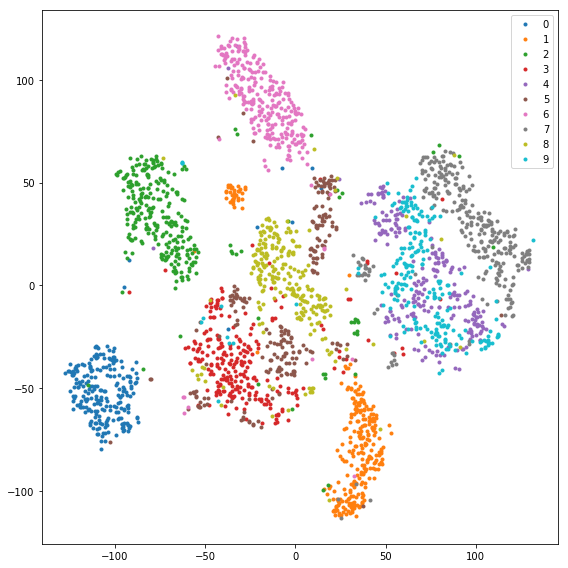

In [402]:
show_model = 0

plt.gcf().set_size_inches(8,8) #Plot is only for my own reference 
legend_list = list()
for l in set(sorted(labels_mnist)):
    plt.scatter(nn_models_orig[show_model][labels_mnist == l, 0], nn_models_orig[show_model][labels_mnist == l, 1],
                marker = '.')
    legend_list.append(str(l))
plt.tight_layout()
l = plt.legend(legend_list)
#plt.savefig("Figures/mnist_tsne_nn_original.png",bbox_extra_artists=[l],bbox_inches='tight')
plt.show()

In [408]:
nn_accuracy = np.zeros((len(nn_method_list),))

for j in range(len(nn_method_results)):
    def get_nn_nearest_neighbors_in_y(y, n=10):
        y_distances = np.sum((nn_models_orig[j] - y)**2, axis=1)
        return np.argsort(y_distances)[:n]       
    
    per_sample_accuracy = np.zeros((len(picked_neighbors),))
    for i in range(len(picked_neighbors)):
        expected_label = picked_neighbor_labels[i]
        nn_indices = get_nn_nearest_neighbors_in_y(nn_method_results[j][i,:], n=accuracy_nn)
        obtained_labels = labels_mnist[nn_indices]
        per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
    nn_accuracy[j] = np.mean(per_sample_accuracy) 
    print(nn_method_list[j], nn_accuracy[j])

NN - 2L; 250N; ReLu; D0.25 0.7845
NN - 2L; 500N; ReLu; D0.5 0.7885
NN - 1L; 500N; tanh 0.7001


In [416]:
nn_kl = np.zeros((len(nn_method_list), len(picked_neighbors)))

processed_indices = list()

kl_nn_performance_file = 'kl_nn_performance.p'
if os.path.isfile(kl_nn_performance_file):
    with open(kl_nn_performance_file, 'rb') as f:
        nn_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(picked_neighbors),))
for i in range(len(picked_neighbors)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, picked_neighbors[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = lion_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(nn_method_results)):
        # Single file with p matrix
        # CAREFUL! Comparing with approximation. nn_models_orig[j], not Y_mnist
        new_Y = np.concatenate((nn_models_orig[j], nn_method_results[j][i,:].reshape((1,-1))), axis=0)
        nn_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_nn_performance_file,'wb') as f:
        pickle.dump((nn_kl, processed_indices), f)
# This should be fast
nn_avg_kl = np.mean(nn_kl, axis=1)

Processing sample  0
	P-matrix file found. Loading.
Processing sample  1
	P-matrix file found. Loading.
Processing sample  2
	P-matrix file found. Loading.
Processing sample  3
	P-matrix file found. Loading.
Processing sample  4
	P-matrix file found. Loading.
Processing sample  5
	P-matrix file found. Loading.
Processing sample  6
	P-matrix file found. Loading.
Processing sample  7
	P-matrix file found. Loading.
Processing sample  8
	P-matrix file found. Loading.
Processing sample  9
	P-matrix file found. Loading.
Processing sample  10
	P-matrix file found. Loading.
Processing sample  11
	P-matrix file found. Loading.
Processing sample  12
	P-matrix file found. Loading.
Processing sample  13
	P-matrix file found. Loading.
Processing sample  14
	P-matrix file found. Loading.
Processing sample  15
	P-matrix file found. Loading.
Processing sample  16
	P-matrix file found. Loading.
Processing sample  17
	P-matrix file found. Loading.
Processing sample  18
	P-matrix file found. Loading.
Pro

Processing sample  154
	P-matrix file found. Loading.
Processing sample  155
	P-matrix file found. Loading.
Processing sample  156
	P-matrix file found. Loading.
Processing sample  157
	P-matrix file found. Loading.
Processing sample  158
	P-matrix file found. Loading.
Processing sample  159
	P-matrix file found. Loading.
Processing sample  160
	P-matrix file found. Loading.
Processing sample  161
	P-matrix file found. Loading.
Processing sample  162
	P-matrix file found. Loading.
Processing sample  163
	P-matrix file found. Loading.
Processing sample  164
	P-matrix file found. Loading.
Processing sample  165
	P-matrix file found. Loading.
Processing sample  166
	P-matrix file found. Loading.
Processing sample  167
	P-matrix file found. Loading.
Processing sample  168
	P-matrix file found. Loading.
Processing sample  169
	P-matrix file found. Loading.
Processing sample  170
	P-matrix file found. Loading.
Processing sample  171
	P-matrix file found. Loading.
Processing sample  172
	P-ma

Processing sample  306
	P-matrix file found. Loading.
Processing sample  307
	P-matrix file found. Loading.
Processing sample  308
	P-matrix file found. Loading.
Processing sample  309
	P-matrix file found. Loading.
Processing sample  310
	P-matrix file found. Loading.
Processing sample  311
	P-matrix file found. Loading.
Processing sample  312
	P-matrix file found. Loading.
Processing sample  313
	P-matrix file found. Loading.
Processing sample  314
	P-matrix file found. Loading.
Processing sample  315
	P-matrix file found. Loading.
Processing sample  316
	P-matrix file found. Loading.
Processing sample  317
	P-matrix file found. Loading.
Processing sample  318
	P-matrix file found. Loading.
Processing sample  319
	P-matrix file found. Loading.
Processing sample  320
	P-matrix file found. Loading.
Processing sample  321
	P-matrix file found. Loading.
Processing sample  322
	P-matrix file found. Loading.
Processing sample  323
	P-matrix file found. Loading.
Processing sample  324
	P-ma

Processing sample  458
	P-matrix file found. Loading.
Processing sample  459
	P-matrix file found. Loading.
Processing sample  460
	P-matrix file found. Loading.
Processing sample  461
	P-matrix file found. Loading.
Processing sample  462
	P-matrix file found. Loading.
Processing sample  463
	P-matrix file found. Loading.
Processing sample  464
	P-matrix file found. Loading.
Processing sample  465
	P-matrix file found. Loading.
Processing sample  466
	P-matrix file found. Loading.
Processing sample  467
	P-matrix file found. Loading.
Processing sample  468
	P-matrix file found. Loading.
Processing sample  469
	P-matrix file found. Loading.
Processing sample  470
	P-matrix file found. Loading.
Processing sample  471
	P-matrix file found. Loading.
Processing sample  472
	P-matrix file found. Loading.
Processing sample  473
	P-matrix file found. Loading.
Processing sample  474
	P-matrix file found. Loading.
Processing sample  475
	P-matrix file found. Loading.
Processing sample  476
	P-ma

Processing sample  610
	P-matrix file found. Loading.
Processing sample  611
	P-matrix file found. Loading.
Processing sample  612
	P-matrix file found. Loading.
Processing sample  613
	P-matrix file found. Loading.
Processing sample  614
	P-matrix file found. Loading.
Processing sample  615
	P-matrix file found. Loading.
Processing sample  616
	P-matrix file found. Loading.
Processing sample  617
	P-matrix file found. Loading.
Processing sample  618
	P-matrix file found. Loading.
Processing sample  619
	P-matrix file found. Loading.
Processing sample  620
	P-matrix file found. Loading.
Processing sample  621
	P-matrix file found. Loading.
Processing sample  622
	P-matrix file found. Loading.
Processing sample  623
	P-matrix file found. Loading.
Processing sample  624
	P-matrix file found. Loading.
Processing sample  625
	P-matrix file found. Loading.
Processing sample  626
	P-matrix file found. Loading.
Processing sample  627
	P-matrix file found. Loading.
Processing sample  628
	P-ma

Processing sample  762
	P-matrix file found. Loading.
Processing sample  763
	P-matrix file found. Loading.
Processing sample  764
	P-matrix file found. Loading.
Processing sample  765
	P-matrix file found. Loading.
Processing sample  766
	P-matrix file found. Loading.
Processing sample  767
	P-matrix file found. Loading.
Processing sample  768
	P-matrix file found. Loading.
Processing sample  769
	P-matrix file found. Loading.
Processing sample  770
	P-matrix file found. Loading.
Processing sample  771
	P-matrix file found. Loading.
Processing sample  772
	P-matrix file found. Loading.
Processing sample  773
	P-matrix file found. Loading.
Processing sample  774
	P-matrix file found. Loading.
Processing sample  775
	P-matrix file found. Loading.
Processing sample  776
	P-matrix file found. Loading.
Processing sample  777
	P-matrix file found. Loading.
Processing sample  778
	P-matrix file found. Loading.
Processing sample  779
	P-matrix file found. Loading.
Processing sample  780
	P-ma

Processing sample  914
	P-matrix file found. Loading.
Processing sample  915
	P-matrix file found. Loading.
Processing sample  916
	P-matrix file found. Loading.
Processing sample  917
	P-matrix file found. Loading.
Processing sample  918
	P-matrix file found. Loading.
Processing sample  919
	P-matrix file found. Loading.
Processing sample  920
	P-matrix file found. Loading.
Processing sample  921
	P-matrix file found. Loading.
Processing sample  922
	P-matrix file found. Loading.
Processing sample  923
	P-matrix file found. Loading.
Processing sample  924
	P-matrix file found. Loading.
Processing sample  925
	P-matrix file found. Loading.
Processing sample  926
	P-matrix file found. Loading.
Processing sample  927
	P-matrix file found. Loading.
Processing sample  928
	P-matrix file found. Loading.
Processing sample  929
	P-matrix file found. Loading.
Processing sample  930
	P-matrix file found. Loading.
Processing sample  931
	P-matrix file found. Loading.
Processing sample  932
	P-ma

In [415]:
nn_nearest_neighbors_percentiles_matrix = np.zeros((len(picked_neighbors), len(nn_method_list)))
for i in range(len(picked_neighbors)):
    for j in range(len(nn_method_list)):
        y = nn_method_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((nn_models_orig[j]-y)**2, axis=1)))
        nn_nearest_neighbors_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
nn_distance_percentiles = np.mean(nn_nearest_neighbors_percentiles_matrix, axis=0) 
for j in range(len(nn_method_list)):
    print(nn_method_list[j], nn_distance_percentiles[j])

NN - 2L; 250N; ReLu; D0.25 43.61492
NN - 2L; 500N; ReLu; D0.5 42.75076
NN - 1L; 500N; tanh 52.86772


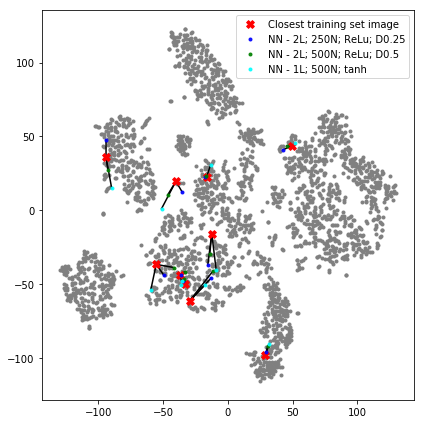

In [413]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20)
chosen_indices = list(range(shown_indices))
#chosen_indices = [3]
for l in range(shown_indices):
    if l in chosen_indices:
        ax.plot([picked_indices_y_mnist[l,0], nn_method_results[0][l,0]],
                 [picked_indices_y_mnist[l,1], nn_method_results[0][l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], nn_method_results[1][l,0]],
                 [picked_indices_y_mnist[l,1], nn_method_results[1][l,1]], c='black', label=None, zorder=2)
        ax.plot([picked_indices_y_mnist[l,0], nn_method_results[2][l,0]],
                 [picked_indices_y_mnist[l,1], nn_method_results[2][l,1]], c='black', label=None, zorder=2)          

ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
#legend_list.append(str(l))
h1 = ax.scatter(picked_indices_y_mnist[:shown_indices,0], picked_indices_y_mnist[:shown_indices,1],
                c='red', marker='X', s=60, zorder=3)
h2 = ax.scatter(nn_method_results[0][:shown_indices,0],
                nn_method_results[0][:shown_indices,1], c='blue', marker='.',zorder=3,alpha=0.9)
h3 = ax.scatter(nn_method_results[1][:shown_indices,0],
                nn_method_results[1][:shown_indices,1], c='green', marker='.',zorder=3,alpha=0.9)
h4 = ax.scatter(nn_method_results[2][:shown_indices,0],
                nn_method_results[2][:shown_indices,1], c='cyan', marker='.',zorder=3,alpha=0.9)

ax.legend([h1,h2,h3,h4], ["Closest training set image"]+nn_method_list)
f.tight_layout()
plt.savefig("Figures/neighbor-test-NN.png")
plt.show(f)

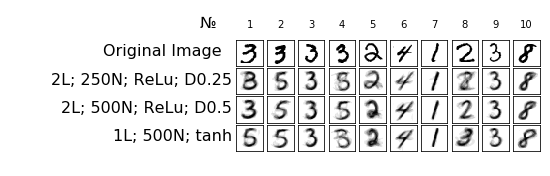

In [432]:
# Another way to check whether we are in the same cluster:
# For ending Y, pick several nearest neighbors in Y space, get their Xs, average them out and print.
width = shown_indices
height = len(nn_method_results)

gs = gridspec.GridSpec(height+2, width+1, width_ratios=[8]+[1]*width)     
    
width = shown_indices #total number to show
start_index = 0

f, ax_total = plt.subplots()

# First row - number of examples
plt.subplot(gs[0]).set_axis_off()
plt.subplot(gs[width+1]).set_axis_off()
plt.subplot(gs[0]).text(text="№   ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)
plt.subplot(gs[width+1]).text(text="Original Image  ",x=1.0, y=0.4,s=11, ha='right', fontsize=16)

f.set_size_inches(7,2)
f.subplots_adjust()

for j in range(len(nn_method_results)):
    sp = plt.subplot(gs[(j+2)*(width+1)])
    sp.text(text=nn_method_list[j][5:],x=1.0, y=0.4,s=11, ha='right', fontsize=16)
    sp.set_axis_off()
    
# It is just a plot, let's make it simple and use 2 loop rather than vectorization
for i in range(width):
    orig_sp = plt.subplot(gs[width+i+2])
    orig_sp.imshow(X_mnist_raw[picked_indices[i], :].reshape(28,28), cmap='gray_r')
    orig_sp.axes.get_xaxis().set_visible(False)
    orig_sp.axes.get_yaxis().set_visible(False)
    num_sp = plt.subplot(gs[i+1])
    num_sp.text(text=str(i+1),x=0.5, y=0.5,s=11, ha='center', va='center', fontsize=10)
    num_sp.set_axis_off()
    for j in range(len(nn_method_results)):
        def get_nn_nearest_neighbors_in_y(y, n=10):
            y_distances = np.sum((nn_models_orig[j] - y)**2, axis=1)
            return np.argsort(y_distances)[:n]      
    
        sp = plt.subplot(gs[(j+2)*(width+1) + i+1])
        nn_indices = get_nn_nearest_neighbors_in_y(nn_method_results[j][i,:], n=illustration_nn)
        average_image = np.mean(X_mnist_raw[nn_indices,:], axis=0).reshape(28,28)
        sp.imshow(average_image, cmap='gray_r')
        sp.axes.get_xaxis().set_visible(False)
        sp.axes.get_yaxis().set_visible(False)
#gs.tight_layout(f)
gs.update(wspace=0.1, hspace=0.025)
f.subplots_adjust(left=-0.04, right=0.99, top=0.99,bottom=0.01)

plt.show(f)
f.savefig("Figures/nn_clustered_nearest_neighbors.png")
plt.close()

# Outlier Test

In [212]:
D = distance.squareform(distance.pdist(X_mnist))
# Now find distance to closest neighbor
np.fill_diagonal(D, np.inf) #... but not to itself
nearest_neighbors_dist = np.min(D, axis=1) # Actually, whatever axis

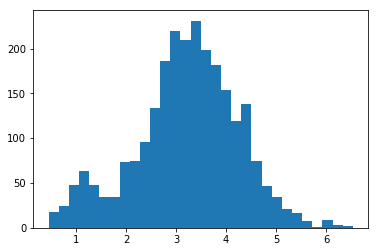

In [213]:
# TODO produce printable figure

plt.hist(nearest_neighbors_dist, bins=30)
plt.show()

In [214]:
max_nearest_dist = max(nearest_neighbors_dist)
max_nearest_dist_sqr = max_nearest_dist**2
max_nearest_dist_sqr #Operating square distances can halp to save some calculations

42.746754105020329

Sample with furthest NN: 79
Squared distance 90th percentile:  19.819594283
Squared distance 95th percentile:  22.9876107617
Squared distance 99th percentile:  30.412160279
[ 10.64421482  72.40121078]


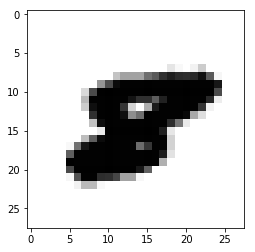

In [215]:
print("Sample with furthest NN:", np.argmax(nearest_neighbors_dist))
print("Squared distance 90th percentile: ", np.percentile(nearest_neighbors_dist**2, 90))
print("Squared distance 95th percentile: ", np.percentile(nearest_neighbors_dist**2, 95))
print("Squared distance 99th percentile: ", np.percentile(nearest_neighbors_dist**2, 99))
print(Y_mnist[79])
plt.imshow(X_mnist_raw[79].reshape(28,28),cmap='gray_r')
plt.show()

In [216]:
regenerate_outliers = False
outliers_file = 'generated_outliers.p'

if os.path.isfile(outliers_file) and not regenerate_outliers:
    print("Found file with generated outliers. Loading...")
    with open(outliers_file, 'rb') as f:
        outlier_samples, outlier_samples_raw = pickle.load(f)
else:
    print("No outlier file or regeneration requested")
    np.random.seed(23412) #Whatever number
    # For speed generating PCA and applying inverse_Tran
    outlier_samples = np.zeros((ind_to_pick, X_mnist.shape[1]))
    outlier_samples_raw = np.zeros((ind_to_pick, X_mnist_raw.shape[1]))
    #boundary = np.percentile(nearest_neighbors_dist**2, 99)
    boundary = max_nearest_dist_sqr
    i = 0
    num_found = 0
    while num_found < ind_to_pick:
        # Step 1. Generate some sample. A few ways to generate outliers:
        # Option 1. Uniform over PCA. Generates outliers very infrequently + no guarantee that inverse transform is in bounds.
        #x_candidate = np.random.uniform(low=0,high=1, size = (1,X_mnist.shape[1]))
        # Option 2. Binomial over PCA. Generates outliers very infrequently + again no guarantee that inverse transform is in bounds.
        #x_candidate = np.random.binomial(n=1, p=0.5, size = (1,X_mnist.shape[1]))
        # TODO Try PCAs, but check that inverse transform is within [0,1]? might work
        # Option 3. Generate randomly over original space. Seems to be the best option by far.
        x_candidate_raw = np.random.uniform(low=0,high=1, size = (1,X_mnist_raw.shape[1]))
        x_candidate = mnist_pca.transform(x_candidate_raw)
        # Step 2. Check the distance.
        #Subtracting from each row, sqaring and summing up to get sqr distances, then minimizing
        closest_square_dist = np.min(np.sum((X_mnist-x_candidate)**2, axis=1))
        if closest_square_dist > boundary:
            outlier_samples[num_found,:] = x_candidate
            outlier_samples_raw[num_found,:] = x_candidate_raw
            num_found += 1
            print("Got one! ",i, num_found, closest_square_dist)
        i += 1
    with open(outliers_file, 'wb') as f:
         pickle.dump((outlier_samples, outlier_samples_raw), f)
        

Found file with generated outliers. Loading...


In [217]:
#del outlier_samples_raw_list

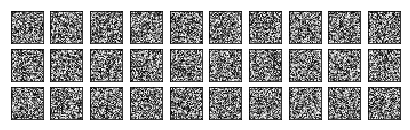

In [218]:
width = 10 #total number to show
height = 3
start_index = 0

f, ax = plt.subplots(height,width)
f.set_size_inches(7,2)
f.subplots_adjust()
#f.tight_layout()
for i in range(height):
    for j in range(width):
        ax[i,j].imshow(outlier_samples_raw[i*width+j,:].reshape(28,28), cmap='gray_r')
        #Set_axis_off does not fit. I want a bounding box.
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)
#gs.update(wspace=0.1, hspace=0.025)
#f.subplots_adjust(left=-0.04, right=0.99, top=0.99,bottom=0.01)

plt.show(f)
f.savefig("Figures/outlier_examples.png")

In [221]:
regenerate_outliers_results = False # Just in case you run cell by mistake
outliers_results_file = 'outliers_results.p'

if os.path.isfile(outliers_results_file) and not regenerate_outliers_results:
    print("Results file found. Loading...")
    with open(outliers_results_file, 'rb') as f:
        outliers_y_multiquadric, outliers_y_cubic, outliers_y_linear,\
        outliers_y_quintic, outliers_y_gaussian, outliers_y_inverse,\
        outliers_y_thin_plate, outliers_y_idw1, outliers_y_idw10,\
        outliers_y_idw20, outliers_y_idw_optimal, outliers_y_idw40 = pickle.load(f)
else:
    print("Outliers resutls not found or regeneration requested.")
    outliers_y_multiquadric = emb_mnist_multiquadric(outlier_samples)
    print("Got multiquadric")
    outliers_y_cubic = emb_mnist_cubic(outlier_samples)
    print("Got cubic")
    outliers_y_linear = emb_mnist_linear(outlier_samples)
    print("Got linear")
    outliers_y_quintic = emb_mnist_quintic(outlier_samples)
    print("Got quintic")
    outliers_y_gaussian = emb_mnist_gaussian(outlier_samples)
    print("Got Gaussian")
    outliers_y_inverse = emb_mnist_inverse(outlier_samples)
    print("Got inverse")
    outliers_y_thin_plate = emb_mnist_thin_plate(outlier_samples)
    print("Got thin plate")
    outliers_y_idw1 = emb_mnist_idw1(outlier_samples)
    print("Got IDW-1")
    outliers_y_idw20 = emb_mnist_idw20(outlier_samples)
    print("Got IDW-20")
    outliers_y_idw10 = emb_mnist_idw10(outlier_samples)
    print("Got IDW-10")
    outliers_y_idw_optimal = emb_mnist_idw_optimal(outlier_samples)
    print("Got IDW-optimal")
    outliers_y_idw40 = emb_mnist_idw40(outlier_samples)
    print("Got IDW-40")
    
    with open(outliers_results_file, 'wb') as f:
        pickle.dump((outliers_y_multiquadric, outliers_y_cubic, outliers_y_linear,\
        outliers_y_quintic, outliers_y_gaussian, outliers_y_inverse,\
        outliers_y_thin_plate, outliers_y_idw1, outliers_y_idw10,\
        outliers_y_idw20, outliers_y_idw_optimal, outliers_y_idw40), f)        

Outliers resutls not found or regeneration requested.
Got multiquadric
Got cubic
Got linear
Got quintic
Got Gaussian
Got inverse
Got thin plate
Got IDW-1
Got IDW-20
Got IDW-10
Got IDW-optimal
Got IDW-40


In [420]:
Y_outl1_mnist = model1.predict(outlier_samples)
Y_outl2_mnist = model2.predict(outlier_samples)
Y_outl3_mnist = model3.predict(outlier_samples)

nn_outliers_results = [Y_outl1_mnist, Y_outl2_mnist, Y_outl3_mnist] 

In [265]:
#picked_neighbors_mnist_pca = mnist_pca.transform(picked_neighbors)
#It takes a while. Let's pickle.

outlier_lion_results_file = 'lion_outlier_results.p'
regenerate_lion_outlier_results = False

if os.path.isfile(outlier_lion_results_file) and not regenerate_lion_outlier_results:
    print("Results file found. Loading...")
    with open(outlier_lion_results_file, 'rb') as f:
        outliers_y_lion90, outliers_y_lion95, outliers_y_lion99, \
        outliers_y_lion100 = pickle.load(f)
else:
    # One-by-one. It is important, or we'll go very far trying to place all outliers together
    print("No results file or regenerate requested")
    outliers_y_lion90 = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
    outliers_y_lion95 = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
    outliers_y_lion99 = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
    outliers_y_lion100 = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
    for i in range(len(outlier_samples)):
        outliers_y_lion90[i,:] = emb_lion_90(outlier_samples[i,:])
    print("Got LION-tSNE 90th percentile")
    for i in range(len(outlier_samples)):    
        outliers_y_lion95[i,:] = emb_lion_95(outlier_samples[i,:])
    print("Got LION-tSNE 95th percentile")
    for i in range(len(outlier_samples)):    
        outliers_y_lion99[i,:] = emb_lion_99(outlier_samples[i,:])
    print("Got LION-tSNE 99th percentile")
    for i in range(len(outlier_samples)):   
        outliers_y_lion100[i,:] = emb_lion_100(outlier_samples[i,:])
    print("Got LION-tSNE 100th percentile")    
    with open(cluster_lion_results_file, 'wb') as f:
        pickle.dump((outliers_y_lion90, outliers_y_lion95, outliers_y_lion99, \
        outliers_y_lion100), f)    
    print("Saved")

No results file or regenerate requested
Got LION-tSNE 90th percentile
Got LION-tSNE 95th percentile
Got LION-tSNE 99th percentile
Got LION-tSNE 100th percentile
Saved


In [266]:
#shown_outlier_indices = shown_indices
shown_outlier_indices = 20

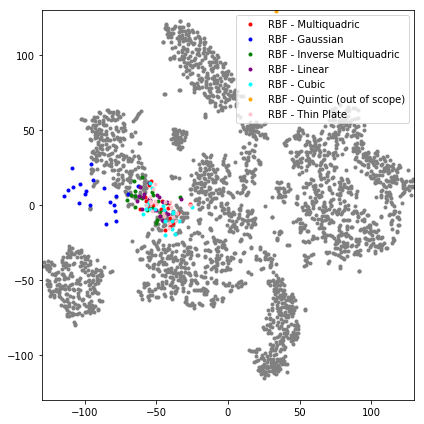

In [224]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20)
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
h1 = ax.scatter(outliers_y_multiquadric[:shown_outlier_indices, 0],
                outliers_y_multiquadric[:shown_outlier_indices, 1], c='red', zorder=1, label=None, marker='.')
h2 = ax.scatter(outliers_y_gaussian[:shown_outlier_indices, 0],
                outliers_y_gaussian[:shown_outlier_indices, 1], c='blue', zorder=1, label=None, marker='.')
h3 = ax.scatter(outliers_y_inverse[:shown_outlier_indices, 0],
                outliers_y_inverse[:shown_outlier_indices, 1], c='green', zorder=1, label=None, marker='.')
h4 = ax.scatter(outliers_y_linear[:shown_outlier_indices, 0],
                outliers_y_linear[:shown_outlier_indices, 1], c='purple', zorder=1, label=None, marker='.')
h5 = ax.scatter(outliers_y_cubic[:shown_outlier_indices, 0],
                outliers_y_cubic[:shown_outlier_indices, 1], c='cyan', zorder=1, label=None, marker='.')
h6 = ax.scatter(outliers_y_quintic[:shown_outlier_indices, 0],
                outliers_y_quintic[:shown_outlier_indices, 1], c='orange', zorder=1, label=None, marker='.')
h7 = ax.scatter(outliers_y_thin_plate[:shown_outlier_indices,0],
                outliers_y_thin_plate[:shown_outlier_indices,1], c='pink', marker='.', zorder=3,alpha=0.9)

ax.legend([h1,h2,h3,h4,h5,h6,h7], ["RBF - Multiquadric","RBF - Gaussian", 'RBF - Inverse Multiquadric', 'RBF - Linear',
                                  'RBF - Cubic','RBF - Quintic (out of scope)', 'RBF - Thin Plate'])
ax.set_xlim([-130,130])
ax.set_ylim([-130,130])

f.tight_layout()
plt.savefig("Figures/outlier-test-RBF.png")
plt.show(f)

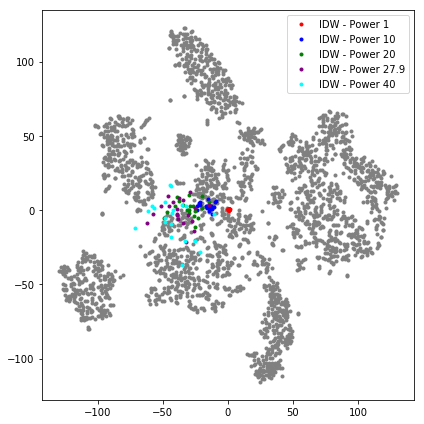

In [226]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20)
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
h1 = ax.scatter(outliers_y_idw1[:shown_outlier_indices, 0],
                outliers_y_idw1[:shown_outlier_indices, 1], c='red', zorder=1, label=None, marker='.')
h2 = ax.scatter(outliers_y_idw10[:shown_outlier_indices, 0],
                outliers_y_idw10[:shown_outlier_indices, 1], c='blue', zorder=1, label=None, marker='.')
h3 = ax.scatter(outliers_y_idw20[:shown_outlier_indices, 0],
                outliers_y_idw20[:shown_outlier_indices, 1], c='green', zorder=1, label=None, marker='.')
h4 = ax.scatter(outliers_y_idw_optimal[:shown_outlier_indices, 0],
                outliers_y_idw_optimal[:shown_outlier_indices, 1], c='purple', zorder=1, label=None, marker='.')
h5 = ax.scatter(outliers_y_idw40[:shown_outlier_indices, 0],
                outliers_y_idw40[:shown_outlier_indices, 1], c='cyan', zorder=1, label=None, marker='.')
ax.legend([h1,h2,h3,h4,h5], idw_method_list)
f.tight_layout()
plt.savefig("Figures/outlier-test-IDW.png")
plt.show(f)

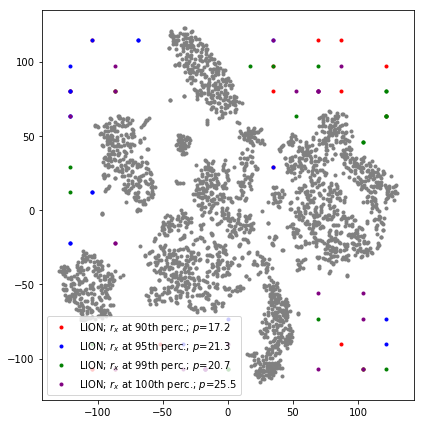

In [268]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20)
cur_shown_outlier_indices = shown_outlier_indices
#cur_shown_outlier_indices = 1000
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
h1 = ax.scatter(outliers_y_lion90[:cur_shown_outlier_indices, 0],
                outliers_y_lion90[:cur_shown_outlier_indices, 1], c='red', zorder=1, label=None, marker='.')
h2 = ax.scatter(outliers_y_lion95[:cur_shown_outlier_indices, 0],
                outliers_y_lion95[:cur_shown_outlier_indices, 1], c='blue', zorder=1, label=None, marker='.')
h3 = ax.scatter(outliers_y_lion99[:cur_shown_outlier_indices, 0],
                outliers_y_lion99[:cur_shown_outlier_indices, 1], c='green', zorder=1, label=None, marker='.')
h4 = ax.scatter(outliers_y_lion100[:cur_shown_outlier_indices, 0],
                outliers_y_lion100[:cur_shown_outlier_indices, 1], c='purple', zorder=1, label=None, marker='.')
ax.legend([h1,h2,h3,h4], lion_method_list)
f.tight_layout()
#plt.ylim([-400, 400])
#plt.xlim([-400, 400])
plt.savefig("Figures/outlier-test-LION.png")
plt.show(f)

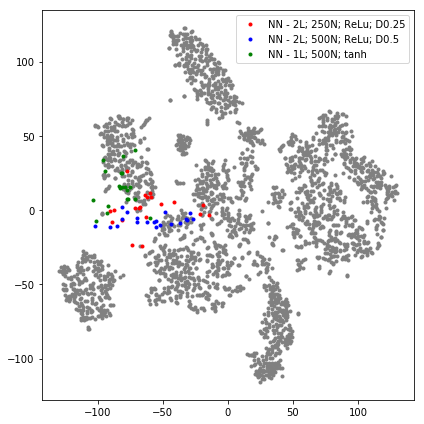

In [421]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20)
cur_shown_outlier_indices = shown_outlier_indices
#cur_shown_outlier_indices = 1000
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
h1 = ax.scatter(nn_outliers_results[0][:cur_shown_outlier_indices, 0],
                nn_outliers_results[0][:cur_shown_outlier_indices, 1], c='red', zorder=1, label=None, marker='.')
h2 = ax.scatter(nn_outliers_results[1][:cur_shown_outlier_indices, 0],
                nn_outliers_results[1][:cur_shown_outlier_indices, 1], c='blue', zorder=1, label=None, marker='.')
h3 = ax.scatter(nn_outliers_results[2][:cur_shown_outlier_indices, 0],
                nn_outliers_results[2][:cur_shown_outlier_indices, 1], c='green', zorder=1, label=None, marker='.')
ax.legend([h1,h2,h3], nn_method_list)
f.tight_layout()
#plt.ylim([-400, 400])
#plt.xlim([-400, 400])
plt.savefig("Figures/outlier-test-NN.png")
plt.show(f)

In [228]:
# Doing it from scratch takes REALLY long time. If possible, save results & pre-load

# These are consequences of parallelization
input_files = ['gd_outlier_results'+str(100*i)+'_'+str(100*i+100)+'.p' for i in range(10)]
output_file = 'gd_outlier_results.p'
covered_samples = list()

first_sample_inc = 0 #Change only if it is one of "Other notebooks just for parallelization"
last_sample_exclusive = len(picked_neighbors)

outliers_y_gd_transformed = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
outliers_y_gd_variance_recalc_transformed = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
outliers_y_gd_transformed_random = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
outliers_y_gd_variance_recalc_transformed_random = np.zeros((len(outlier_samples), Y_mnist.shape[1]))

outliers_y_gd_early_exagg_transformed_random = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
outliers_y_gd_early_exagg_transformed = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
outliers_y_gd_variance_recalc_early_exagg_transformed_random = np.zeros((len(outlier_samples), Y_mnist.shape[1]))
outliers_y_gd_variance_recalc_early_exagg_transformed = np.zeros((len(outlier_samples), Y_mnist.shape[1]))

outliers_random_starting_positions = np.zeros((len(outlier_samples), Y_mnist.shape[1])) 

for fname in input_files:
    if not os.path.isfile(fname):
        print("File not found: ",fname)
    else:
        with open(fname, 'rb') as f:
            cur_gd_transformed, cur_gd_variance_recalc_transformed, \
            cur_gd_transformed_random, cur_gd_variance_recalc_transformed_random, \
            cur_gd_early_exagg_transformed_random, cur_gd_early_exagg_transformed, \
            cur_gd_variance_recalc_early_exagg_transformed_random, cur_random_starting_positions, \
            cur_gd_variance_recalc_early_exagg_transformed, cur_covered_samples = pickle.load(f)
        print(cur_covered_samples)
        # Each files covers only part of samples
        for i in cur_covered_samples:
            print("\tLoaded sample ",i)
            outliers_y_gd_transformed[i,:] = cur_gd_transformed[i,:]
            outliers_y_gd_variance_recalc_transformed[i,:] = cur_gd_variance_recalc_transformed[i,:]
            outliers_random_starting_positions[i,:] = cur_random_starting_positions[i,:]
            outliers_y_gd_transformed_random[i,:] = cur_gd_transformed_random[i,:]
            outliers_y_gd_variance_recalc_transformed_random[i,:] = cur_gd_variance_recalc_transformed_random[i,:]
            outliers_y_gd_early_exagg_transformed_random[i,:] = cur_gd_early_exagg_transformed_random[i,:]
            outliers_y_gd_early_exagg_transformed[i,:] = picked_neighbors_y_gd_early_exagg_transformed[i,:]
            outliers_y_gd_variance_recalc_early_exagg_transformed_random[i,:] = \
                            cur_gd_variance_recalc_early_exagg_transformed_random[i,:] 
            outliers_y_gd_variance_recalc_early_exagg_transformed[i,:] = \
                            cur_gd_variance_recalc_early_exagg_transformed[i,:]
            covered_samples.append(i)
            
    
for i in range(first_sample_inc, last_sample_exclusive):
    np.random.seed(i) # We reset random seed every time. Otherwise, if you load partial results from file, everything
    # will depend on which parts were loaded, random sequence will "shift" depend on that, and reproducibility will be lost.
    # I.e. if put seed(0) before the loop and start from scratch, then you will have some random sequence [abc] for sample 0,
    # other (continuation of that sequence) [def] for sample 1, etc. But if you already loaded sample 0 from file, you will
    # have [abc] for sample 1, [def] for sample 2, etc. Reproducibility should not depend on what parts are loaded.
    # Hence, random seed every time, and it depends on ABSOLUTE sample number.
    print(" ====================== Sample ",i,"\n\n")
    if i in covered_samples:
        print("Already loaded.")
    else:
        outlier = outlier_samples[i].reshape((1,-1))
        outliers_y_gd_transformed[i,:] = dTSNE_mnist.transform(outlier,y='closest',
                                                               verbose=2,optimizer_kwargs={'early_exaggeration':None})
        outliers_y_gd_variance_recalc_transformed[i,:] = dTSNE_mnist.transform(outlier, keep_sigmas=False,y='closest',
                                                                       verbose=2,optimizer_kwargs={'early_exaggeration':None})

        #Let's pick random starts at any point. not necessary near the center.
        y_start = np.array([[
            np.random.uniform(np.min(Y_mnist[:,0]),np.max(Y_mnist[:,0])),
            np.random.uniform(np.min(Y_mnist[:,1]),np.max(Y_mnist[:,1]))
        ]])

        outliers_random_starting_positions[i,:] = y_start

        outliers_y_gd_transformed_random[i,:] = dTSNE_mnist.transform(outlier, y=y_start, #y='random',
                                                                       verbose=2,optimizer_kwargs={'early_exaggeration':None})
        outliers_y_gd_variance_recalc_transformed_random[i,:] = dTSNE_mnist.transform(outlier,
                                                                        keep_sigmas=False, y=y_start, #y='random',
                                                                        verbose=2,optimizer_kwargs={'early_exaggeration':None})


        outliers_y_gd_early_exagg_transformed_random[i,:] = dTSNE_mnist.transform(outlier,y=y_start, #y='random',
                                                                       verbose=2)
        outliers_y_gd_early_exagg_transformed[i,:] = dTSNE_mnist.transform(neighbor, y='closest', verbose=2)

        outliers_y_gd_variance_recalc_early_exagg_transformed_random[i,:] = dTSNE_mnist.transform(outlier,y=y_start,
                                                                       keep_sigmas=False, verbose=2)
        outliers_y_gd_variance_recalc_early_exagg_transformed[i,:] = dTSNE_mnist.transform(outlier, keep_sigmas=False,
                                                                        y='closest', verbose=2)

    covered_samples.append(i)
    print("Saving...")
    # Gradient descent results take a long while. Let's cache.
    with open(output_file, 'wb') as f:
        pickle.dump( (outliers_y_gd_transformed, outliers_y_gd_variance_recalc_transformed,
            outliers_y_gd_transformed_random, outliers_y_gd_variance_recalc_transformed_random,
            outliers_y_gd_early_exagg_transformed_random, outliers_y_gd_early_exagg_transformed,
            outliers_y_gd_variance_recalc_early_exagg_transformed_random, outliers_random_starting_positions,
            outliers_y_gd_variance_recalc_early_exagg_transformed, covered_samples), f)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
	Loaded sample  0
	Loaded sample  1
	Loaded sample  2
	Loaded sample  3
	Loaded sample  4
	Loaded sample  5
	Loaded sample  6
	Loaded sample  7
	Loaded sample  8
	Loaded sample  9
	Loaded sample  10
	Loaded sample  11
	Loaded sample  12
	Loaded sample  13
	Loaded sample  14
	Loaded sample  15
	Loaded sample  16
	Loaded sample  17
	Loaded sample  18
	Loaded sample  19
	Loaded sample  20
	Loaded sample  21
	Loaded sample  22
	Loaded sample  23
	Loaded sample  24
	Loaded sample  25
	Loaded sample  26
	Loaded sample  27
	Loaded sample  28
	Loaded sample  29
	Loaded sample  30
	Loaded sample  31
	Loaded sam

	Loaded sample  631
	Loaded sample  632
	Loaded sample  633
	Loaded sample  634
	Loaded sample  635
	Loaded sample  636
	Loaded sample  637
	Loaded sample  638
	Loaded sample  639
	Loaded sample  640
	Loaded sample  641
	Loaded sample  642
	Loaded sample  643
	Loaded sample  644
	Loaded sample  645
	Loaded sample  646
	Loaded sample  647
	Loaded sample  648
	Loaded sample  649
	Loaded sample  650
	Loaded sample  651
	Loaded sample  652
	Loaded sample  653
	Loaded sample  654
	Loaded sample  655
	Loaded sample  656
	Loaded sample  657
	Loaded sample  658
	Loaded sample  659
	Loaded sample  660
	Loaded sample  661
	Loaded sample  662
	Loaded sample  663
	Loaded sample  664
	Loaded sample  665
	Loaded sample  666
	Loaded sample  667
	Loaded sample  668
	Loaded sample  669
	Loaded sample  670
	Loaded sample  671
	Loaded sample  672
	Loaded sample  673
	Loaded sample  674
	Loaded sample  675
	Loaded sample  676
	Loaded sample  677
	Loaded sample  678
	Loaded sample  679
	Loaded sample  680


 ====================== Sample  128 


Already loaded.
Saving...
 ====================== Sample  129 


Already loaded.
Saving...
 ====================== Sample  130 


Already loaded.
Saving...
 ====================== Sample  131 


Already loaded.
Saving...
 ====================== Sample  132 


Already loaded.
Saving...
 ====================== Sample  133 


Already loaded.
Saving...
 ====================== Sample  134 


Already loaded.
Saving...
 ====================== Sample  135 


Already loaded.
Saving...
 ====================== Sample  136 


Already loaded.
Saving...
 ====================== Sample  137 


Already loaded.
Saving...
 ====================== Sample  138 


Already loaded.
Saving...
 ====================== Sample  139 


Already loaded.
Saving...
 ====================== Sample  140 


Already loaded.
Saving...
 ====================== Sample  141 


Already loaded.
Saving...
 ====================== Sample  142 


Already loaded.
Saving...
 ====================== S

 ====================== Sample  465 


Already loaded.
Saving...
 ====================== Sample  466 


Already loaded.
Saving...
 ====================== Sample  467 


Already loaded.
Saving...
 ====================== Sample  468 


Already loaded.
Saving...
 ====================== Sample  469 


Already loaded.
Saving...
 ====================== Sample  470 


Already loaded.
Saving...
 ====================== Sample  471 


Already loaded.
Saving...
 ====================== Sample  472 


Already loaded.
Saving...
 ====================== Sample  473 


Already loaded.
Saving...
 ====================== Sample  474 


Already loaded.
Saving...
 ====================== Sample  475 


Already loaded.
Saving...
 ====================== Sample  476 


Already loaded.
Saving...
 ====================== Sample  477 


Already loaded.
Saving...
 ====================== Sample  478 


Already loaded.
Saving...
 ====================== Sample  479 


Already loaded.
Saving...
 ====================== S

Saving...
 ====================== Sample  768 


Already loaded.
Saving...
 ====================== Sample  769 


Already loaded.
Saving...
 ====================== Sample  770 


Already loaded.
Saving...
 ====================== Sample  771 


Already loaded.
Saving...
 ====================== Sample  772 


Already loaded.
Saving...
 ====================== Sample  773 


Already loaded.
Saving...
 ====================== Sample  774 


Already loaded.
Saving...
 ====================== Sample  775 


Already loaded.
Saving...
 ====================== Sample  776 


Already loaded.
Saving...
 ====================== Sample  777 


Already loaded.
Saving...
 ====================== Sample  778 


Already loaded.
Saving...
 ====================== Sample  779 


Already loaded.
Saving...
 ====================== Sample  780 


Already loaded.
Saving...
 ====================== Sample  781 


Already loaded.
Saving...
 ====================== Sample  782 


Already loaded.
Saving...
 ==============

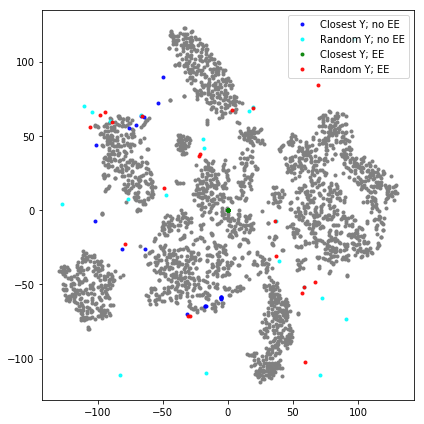

In [229]:
cur_shown_indices = list(range(shown_outlier_indices))

legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
    
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
#legend_list.append(str(l))
h2 = ax.scatter(outliers_y_gd_transformed[cur_shown_indices,0],
                outliers_y_gd_transformed[cur_shown_indices,1], c='blue', marker='.',zorder=3,alpha=0.9)
h3 = ax.scatter(outliers_y_gd_transformed_random[cur_shown_indices,0],
                outliers_y_gd_transformed_random[cur_shown_indices,1], c='cyan', marker='.', zorder=3,alpha=0.9)
#h4 = ax.scatter(picked_neighbors_y_gd_variance_recalc_transformed[:cur_shown_indices,0],
#                picked_neighbors_y_gd_variance_recalc_transformed[:cur_shown_indices,1], c='green', marker='.', zorder=3,alpha=0.9)
#h5 = ax.scatter(picked_neighbors_y_gd_variance_recalc_transformed_random[:cur_shown_indices,0],
#                picked_neighbors_y_gd_variance_recalc_transformed_random[:cur_shown_indices,1],
#                c='brown', marker='.', zorder=3,alpha=0.9)
h6 = ax.scatter(outliers_y_gd_early_exagg_transformed[cur_shown_indices,0],
                outliers_y_gd_early_exagg_transformed[cur_shown_indices,1], c='green', marker='.',zorder=3,alpha=0.9)
h7 = ax.scatter(outliers_y_gd_early_exagg_transformed_random[cur_shown_indices,0],
                outliers_y_gd_early_exagg_transformed_random[cur_shown_indices,1],
                c='red', marker='.', zorder=3,alpha=0.9)
#h8 = ax.scatter(outliers_y_gd_variance_recalc_early_exagg_transformed[:cur_shown_indices,0],
#                outliers_y_gd_variance_recalc_early_exagg_transformed[:cur_shown_indices,1],
#                c='black', marker='.', zorder=3,alpha=0.9)
#h9 = ax.scatter(outliers_y_gd_variance_recalc_early_exagg_transformed_random[:cur_shown_indices,0],
#                outliers_y_gd_variance_recalc_early_exagg_transformed_random[:cur_shown_indices,1],
#                c='olive', marker='.', zorder=3,alpha=0.9)
#h10 = ax.scatter(outliers_random_starting_positions[cur_shown_indices,0],
#                 outliers_random_starting_positions[cur_shown_indices,1], c='black', marker='.', zorder=3,alpha=0.9)

ax.legend([h2,h3,h6,h7,h10], [          r'Closest Y; no EE',
                                        r'Random Y; no EE',
                                        #r'Closest Y; new $\sigma$; no EE',
                                        #r'Random Y; new $\sigma$; no EE',                             
                                        r'Closest Y; EE',
                                        r'Random Y; EE',
                                        #r'Closest Y; new $\sigma$; EE',
                                        #r'Random Y; new $\sigma$; EE',
                                        #'Random Starting Position'
                            ])
f.tight_layout()
plt.savefig("Figures/outlier-test-GD.png")
plt.show(f)

In [279]:
rbf_outliers_results = [outliers_y_multiquadric, outliers_y_gaussian, outliers_y_inverse,
                        outliers_y_linear, outliers_y_cubic, outliers_y_quintic,
                        outliers_y_thin_plate]

idw_outliers_results = [outliers_y_idw1, outliers_y_idw10, outliers_y_idw20,
                      outliers_y_idw_optimal, outliers_y_idw40]

lion_outliers_results = [outliers_y_lion90, outliers_y_lion95, outliers_y_lion99, outliers_y_lion100]

gd_outliers_results = [
    outliers_y_gd_transformed,
    outliers_y_gd_transformed_random,
    outliers_y_gd_variance_recalc_transformed,
    outliers_y_gd_variance_recalc_transformed_random,
    outliers_y_gd_early_exagg_transformed,
    outliers_y_gd_early_exagg_transformed_random,
    outliers_y_gd_variance_recalc_early_exagg_transformed,
    outliers_y_gd_variance_recalc_early_exagg_transformed_random,    
]

In [231]:
rbf_outliers_kl = np.zeros((len(rbf_method_list), len(outlier_samples)))

processed_indices = list()

kl_rbf_outliers_performance_file = 'kl_outliers_rbf_performance.p'
if os.path.isfile(kl_rbf_outliers_performance_file):
    with open(kl_rbf_outliers_performance_file, 'rb') as f:
        rbf_outliers_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(outlier_samples),))
for i in range(len(outlier_samples)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, outlier_samples[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = lion_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(rbf_method_results)):
        # Single file with p matrix
        new_Y = np.concatenate((Y_mnist, rbf_outliers_results[j][i,:].reshape((1,-1))), axis=0)
        rbf_outliers_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_rbf_outliers_performance_file,'wb') as f:
        pickle.dump((rbf_outliers_kl, processed_indices), f)
# This should be fast
rbf_avg_outliers_kl = np.mean(rbf_outliers_kl, axis=1) 

Sample 0 already processed. Results loaded.
Sample 1 already processed. Results loaded.
Sample 2 already processed. Results loaded.
Sample 3 already processed. Results loaded.
Sample 4 already processed. Results loaded.
Sample 5 already processed. Results loaded.
Sample 6 already processed. Results loaded.
Sample 7 already processed. Results loaded.
Sample 8 already processed. Results loaded.
Sample 9 already processed. Results loaded.
Sample 10 already processed. Results loaded.
Sample 11 already processed. Results loaded.
Sample 12 already processed. Results loaded.
Sample 13 already processed. Results loaded.
Sample 14 already processed. Results loaded.
Sample 15 already processed. Results loaded.
Sample 16 already processed. Results loaded.
Sample 17 already processed. Results loaded.
Sample 18 already processed. Results loaded.
Sample 19 already processed. Results loaded.
Sample 20 already processed. Results loaded.
Sample 21 already processed. Results loaded.
Sample 22 already pr

Sample 477 already processed. Results loaded.
Sample 478 already processed. Results loaded.
Sample 479 already processed. Results loaded.
Sample 480 already processed. Results loaded.
Sample 481 already processed. Results loaded.
Sample 482 already processed. Results loaded.
Sample 483 already processed. Results loaded.
Sample 484 already processed. Results loaded.
Sample 485 already processed. Results loaded.
Sample 486 already processed. Results loaded.
Sample 487 already processed. Results loaded.
Sample 488 already processed. Results loaded.
Sample 489 already processed. Results loaded.
Sample 490 already processed. Results loaded.
Sample 491 already processed. Results loaded.
Sample 492 already processed. Results loaded.
Sample 493 already processed. Results loaded.
Sample 494 already processed. Results loaded.
Sample 495 already processed. Results loaded.
Sample 496 already processed. Results loaded.
Sample 497 already processed. Results loaded.
Sample 498 already processed. Resu

In [233]:
idw_outliers_kl = np.zeros((len(idw_method_list), len(outlier_samples)))

processed_indices = list()

kl_idw_outliers_performance_file = 'kl_outliers_idw_performance.p'
if os.path.isfile(kl_idw_outliers_performance_file):
    with open(kl_idw_outliers_performance_file, 'rb') as f:
        idw_outliers_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(outlier_samples),))
for i in range(len(outlier_samples)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, outlier_samples[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = lion_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(idw_method_results)):
        # Single file with p matrix
        new_Y = np.concatenate((Y_mnist, idw_outliers_results[j][i,:].reshape((1,-1))), axis=0)
        idw_outliers_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_idw_outliers_performance_file,'wb') as f:
        pickle.dump((idw_outliers_kl, processed_indices), f)
# This should be fast
idw_avg_outliers_kl = np.mean(idw_outliers_kl, axis=1) 

Processing sample  0
	P-matrix file found. Loading.
Processing sample  1
	P-matrix file found. Loading.
Processing sample  2
	P-matrix file found. Loading.
Processing sample  3
	P-matrix file found. Loading.
Processing sample  4
	P-matrix file found. Loading.
Processing sample  5
	P-matrix file found. Loading.
Processing sample  6
	P-matrix file found. Loading.
Processing sample  7
	P-matrix file found. Loading.
Processing sample  8
	P-matrix file found. Loading.
Processing sample  9
	P-matrix file found. Loading.
Processing sample  10
	P-matrix file found. Loading.
Processing sample  11
	P-matrix file found. Loading.
Processing sample  12
	P-matrix file found. Loading.
Processing sample  13
	P-matrix file found. Loading.
Processing sample  14
	P-matrix file found. Loading.
Processing sample  15
	P-matrix file found. Loading.
Processing sample  16
	P-matrix file found. Loading.
Processing sample  17
	P-matrix file found. Loading.
Processing sample  18
	P-matrix file found. Loading.
Pro

Processing sample  154
	P-matrix file found. Loading.
Processing sample  155
	P-matrix file found. Loading.
Processing sample  156
	P-matrix file found. Loading.
Processing sample  157
	P-matrix file found. Loading.
Processing sample  158
	P-matrix file found. Loading.
Processing sample  159
	P-matrix file found. Loading.
Processing sample  160
	P-matrix file found. Loading.
Processing sample  161
	P-matrix file found. Loading.
Processing sample  162
	P-matrix file found. Loading.
Processing sample  163
	P-matrix file found. Loading.
Processing sample  164
	P-matrix file found. Loading.
Processing sample  165
	P-matrix file found. Loading.
Processing sample  166
	P-matrix file found. Loading.
Processing sample  167
	P-matrix file found. Loading.
Processing sample  168
	P-matrix file found. Loading.
Processing sample  169
	P-matrix file found. Loading.
Processing sample  170
	P-matrix file found. Loading.
Processing sample  171
	P-matrix file found. Loading.
Processing sample  172
	P-ma

Processing sample  306
	P-matrix file found. Loading.
Processing sample  307
	P-matrix file found. Loading.
Processing sample  308
	P-matrix file found. Loading.
Processing sample  309
	P-matrix file found. Loading.
Processing sample  310
	P-matrix file found. Loading.
Processing sample  311
	P-matrix file found. Loading.
Processing sample  312
	P-matrix file found. Loading.
Processing sample  313
	P-matrix file found. Loading.
Processing sample  314
	P-matrix file found. Loading.
Processing sample  315
	P-matrix file found. Loading.
Processing sample  316
	P-matrix file found. Loading.
Processing sample  317
	P-matrix file found. Loading.
Processing sample  318
	P-matrix file found. Loading.
Processing sample  319
	P-matrix file found. Loading.
Processing sample  320
	P-matrix file found. Loading.
Processing sample  321
	P-matrix file found. Loading.
Processing sample  322
	P-matrix file found. Loading.
Processing sample  323
	P-matrix file found. Loading.
Processing sample  324
	P-ma

Processing sample  458
	P-matrix file found. Loading.
Processing sample  459
	P-matrix file found. Loading.
Processing sample  460
	P-matrix file found. Loading.
Processing sample  461
	P-matrix file found. Loading.
Processing sample  462
	P-matrix file found. Loading.
Processing sample  463
	P-matrix file found. Loading.
Processing sample  464
	P-matrix file found. Loading.
Processing sample  465
	P-matrix file found. Loading.
Processing sample  466
	P-matrix file found. Loading.
Processing sample  467
	P-matrix file found. Loading.
Processing sample  468
	P-matrix file found. Loading.
Processing sample  469
	P-matrix file found. Loading.
Processing sample  470
	P-matrix file found. Loading.
Processing sample  471
	P-matrix file found. Loading.
Processing sample  472
	P-matrix file found. Loading.
Processing sample  473
	P-matrix file found. Loading.
Processing sample  474
	P-matrix file found. Loading.
Processing sample  475
	P-matrix file found. Loading.
Processing sample  476
	P-ma

Processing sample  610
	P-matrix file found. Loading.
Processing sample  611
	P-matrix file found. Loading.
Processing sample  612
	P-matrix file found. Loading.
Processing sample  613
	P-matrix file found. Loading.
Processing sample  614
	P-matrix file found. Loading.
Processing sample  615
	P-matrix file found. Loading.
Processing sample  616
	P-matrix file found. Loading.
Processing sample  617
	P-matrix file found. Loading.
Processing sample  618
	P-matrix file found. Loading.
Processing sample  619
	P-matrix file found. Loading.
Processing sample  620
	P-matrix file found. Loading.
Processing sample  621
	P-matrix file found. Loading.
Processing sample  622
	P-matrix file found. Loading.
Processing sample  623
	P-matrix file found. Loading.
Processing sample  624
	P-matrix file found. Loading.
Processing sample  625
	P-matrix file found. Loading.
Processing sample  626
	P-matrix file found. Loading.
Processing sample  627
	P-matrix file found. Loading.
Processing sample  628
	P-ma

Processing sample  762
	P-matrix file found. Loading.
Processing sample  763
	P-matrix file found. Loading.
Processing sample  764
	P-matrix file found. Loading.
Processing sample  765
	P-matrix file found. Loading.
Processing sample  766
	P-matrix file found. Loading.
Processing sample  767
	P-matrix file found. Loading.
Processing sample  768
	P-matrix file found. Loading.
Processing sample  769
	P-matrix file found. Loading.
Processing sample  770
	P-matrix file found. Loading.
Processing sample  771
	P-matrix file found. Loading.
Processing sample  772
	P-matrix file found. Loading.
Processing sample  773
	P-matrix file found. Loading.
Processing sample  774
	P-matrix file found. Loading.
Processing sample  775
	P-matrix file found. Loading.
Processing sample  776
	P-matrix file found. Loading.
Processing sample  777
	P-matrix file found. Loading.
Processing sample  778
	P-matrix file found. Loading.
Processing sample  779
	P-matrix file found. Loading.
Processing sample  780
	P-ma

Processing sample  914
	P-matrix file found. Loading.
Processing sample  915
	P-matrix file found. Loading.
Processing sample  916
	P-matrix file found. Loading.
Processing sample  917
	P-matrix file found. Loading.
Processing sample  918
	P-matrix file found. Loading.
Processing sample  919
	P-matrix file found. Loading.
Processing sample  920
	P-matrix file found. Loading.
Processing sample  921
	P-matrix file found. Loading.
Processing sample  922
	P-matrix file found. Loading.
Processing sample  923
	P-matrix file found. Loading.
Processing sample  924
	P-matrix file found. Loading.
Processing sample  925
	P-matrix file found. Loading.
Processing sample  926
	P-matrix file found. Loading.
Processing sample  927
	P-matrix file found. Loading.
Processing sample  928
	P-matrix file found. Loading.
Processing sample  929
	P-matrix file found. Loading.
Processing sample  930
	P-matrix file found. Loading.
Processing sample  931
	P-matrix file found. Loading.
Processing sample  932
	P-ma

In [451]:
nn_outliers_kl = np.zeros((len(nn_method_list), len(outlier_samples)))

processed_indices = list()

kl_nn_outliers_performance_file = 'kl_outliers_nn_performance.p'
if os.path.isfile(kl_nn_outliers_performance_file):
    with open(kl_nn_outliers_performance_file, 'rb') as f:
        nn_outliers_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(outlier_samples),))
for i in range(len(outlier_samples)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, outlier_samples[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = nn_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(nn_method_results)):
        # Single file with p matrix
        new_Y = np.concatenate((nn_models_orig[j], nn_outliers_results[j][i,:].reshape((1,-1))), axis=0)
        nn_outliers_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_nn_outliers_performance_file,'wb') as f:
        pickle.dump((nn_outliers_kl, processed_indices), f)
# This should be fast
nn_avg_outliers_kl = np.mean(nn_outliers_kl, axis=1) 

Processing sample  0
	P-matrix file found. Loading.
Processing sample  1
	P-matrix file found. Loading.
Processing sample  2
	P-matrix file found. Loading.
Processing sample  3
	P-matrix file found. Loading.
Processing sample  4
	P-matrix file found. Loading.
Processing sample  5
	P-matrix file found. Loading.
Processing sample  6
	P-matrix file found. Loading.
Processing sample  7
	P-matrix file found. Loading.
Processing sample  8
	P-matrix file found. Loading.
Processing sample  9
	P-matrix file found. Loading.
Processing sample  10
	P-matrix file found. Loading.
Processing sample  11
	P-matrix file found. Loading.
Processing sample  12
	P-matrix file found. Loading.
Processing sample  13
	P-matrix file found. Loading.
Processing sample  14
	P-matrix file found. Loading.
Processing sample  15
	P-matrix file found. Loading.
Processing sample  16
	P-matrix file found. Loading.
Processing sample  17
	P-matrix file found. Loading.
Processing sample  18
	P-matrix file found. Loading.
Pro

Processing sample  154
	P-matrix file found. Loading.
Processing sample  155
	P-matrix file found. Loading.
Processing sample  156
	P-matrix file found. Loading.
Processing sample  157
	P-matrix file found. Loading.
Processing sample  158
	P-matrix file found. Loading.
Processing sample  159
	P-matrix file found. Loading.
Processing sample  160
	P-matrix file found. Loading.
Processing sample  161
	P-matrix file found. Loading.
Processing sample  162
	P-matrix file found. Loading.
Processing sample  163
	P-matrix file found. Loading.
Processing sample  164
	P-matrix file found. Loading.
Processing sample  165
	P-matrix file found. Loading.
Processing sample  166
	P-matrix file found. Loading.
Processing sample  167
	P-matrix file found. Loading.
Processing sample  168
	P-matrix file found. Loading.
Processing sample  169
	P-matrix file found. Loading.
Processing sample  170
	P-matrix file found. Loading.
Processing sample  171
	P-matrix file found. Loading.
Processing sample  172
	P-ma

Processing sample  306
	P-matrix file found. Loading.
Processing sample  307
	P-matrix file found. Loading.
Processing sample  308
	P-matrix file found. Loading.
Processing sample  309
	P-matrix file found. Loading.
Processing sample  310
	P-matrix file found. Loading.
Processing sample  311
	P-matrix file found. Loading.
Processing sample  312
	P-matrix file found. Loading.
Processing sample  313
	P-matrix file found. Loading.
Processing sample  314
	P-matrix file found. Loading.
Processing sample  315
	P-matrix file found. Loading.
Processing sample  316
	P-matrix file found. Loading.
Processing sample  317
	P-matrix file found. Loading.
Processing sample  318
	P-matrix file found. Loading.
Processing sample  319
	P-matrix file found. Loading.
Processing sample  320
	P-matrix file found. Loading.
Processing sample  321
	P-matrix file found. Loading.
Processing sample  322
	P-matrix file found. Loading.
Processing sample  323
	P-matrix file found. Loading.
Processing sample  324
	P-ma

Processing sample  458
	P-matrix file found. Loading.
Processing sample  459
	P-matrix file found. Loading.
Processing sample  460
	P-matrix file found. Loading.
Processing sample  461
	P-matrix file found. Loading.
Processing sample  462
	P-matrix file found. Loading.
Processing sample  463
	P-matrix file found. Loading.
Processing sample  464
	P-matrix file found. Loading.
Processing sample  465
	P-matrix file found. Loading.
Processing sample  466
	P-matrix file found. Loading.
Processing sample  467
	P-matrix file found. Loading.
Processing sample  468
	P-matrix file found. Loading.
Processing sample  469
	P-matrix file found. Loading.
Processing sample  470
	P-matrix file found. Loading.
Processing sample  471
	P-matrix file found. Loading.
Processing sample  472
	P-matrix file found. Loading.
Processing sample  473
	P-matrix file found. Loading.
Processing sample  474
	P-matrix file found. Loading.
Processing sample  475
	P-matrix file found. Loading.
Processing sample  476
	P-ma

Processing sample  610
	P-matrix file found. Loading.
Processing sample  611
	P-matrix file found. Loading.
Processing sample  612
	P-matrix file found. Loading.
Processing sample  613
	P-matrix file found. Loading.
Processing sample  614
	P-matrix file found. Loading.
Processing sample  615
	P-matrix file found. Loading.
Processing sample  616
	P-matrix file found. Loading.
Processing sample  617
	P-matrix file found. Loading.
Processing sample  618
	P-matrix file found. Loading.
Processing sample  619
	P-matrix file found. Loading.
Processing sample  620
	P-matrix file found. Loading.
Processing sample  621
	P-matrix file found. Loading.
Processing sample  622
	P-matrix file found. Loading.
Processing sample  623
	P-matrix file found. Loading.
Processing sample  624
	P-matrix file found. Loading.
Processing sample  625
	P-matrix file found. Loading.
Processing sample  626
	P-matrix file found. Loading.
Processing sample  627
	P-matrix file found. Loading.
Processing sample  628
	P-ma

Processing sample  762
	P-matrix file found. Loading.
Processing sample  763
	P-matrix file found. Loading.
Processing sample  764
	P-matrix file found. Loading.
Processing sample  765
	P-matrix file found. Loading.
Processing sample  766
	P-matrix file found. Loading.
Processing sample  767
	P-matrix file found. Loading.
Processing sample  768
	P-matrix file found. Loading.
Processing sample  769
	P-matrix file found. Loading.
Processing sample  770
	P-matrix file found. Loading.
Processing sample  771
	P-matrix file found. Loading.
Processing sample  772
	P-matrix file found. Loading.
Processing sample  773
	P-matrix file found. Loading.
Processing sample  774
	P-matrix file found. Loading.
Processing sample  775
	P-matrix file found. Loading.
Processing sample  776
	P-matrix file found. Loading.
Processing sample  777
	P-matrix file found. Loading.
Processing sample  778
	P-matrix file found. Loading.
Processing sample  779
	P-matrix file found. Loading.
Processing sample  780
	P-ma

Processing sample  914
	P-matrix file found. Loading.
Processing sample  915
	P-matrix file found. Loading.
Processing sample  916
	P-matrix file found. Loading.
Processing sample  917
	P-matrix file found. Loading.
Processing sample  918
	P-matrix file found. Loading.
Processing sample  919
	P-matrix file found. Loading.
Processing sample  920
	P-matrix file found. Loading.
Processing sample  921
	P-matrix file found. Loading.
Processing sample  922
	P-matrix file found. Loading.
Processing sample  923
	P-matrix file found. Loading.
Processing sample  924
	P-matrix file found. Loading.
Processing sample  925
	P-matrix file found. Loading.
Processing sample  926
	P-matrix file found. Loading.
Processing sample  927
	P-matrix file found. Loading.
Processing sample  928
	P-matrix file found. Loading.
Processing sample  929
	P-matrix file found. Loading.
Processing sample  930
	P-matrix file found. Loading.
Processing sample  931
	P-matrix file found. Loading.
Processing sample  932
	P-ma

In [274]:
lion_outliers_kl = np.zeros((len(lion_method_list), len(outlier_samples)))

processed_indices = list()

kl_lion_outliers_performance_file = 'kl_outliers_lion_performance.p'
if os.path.isfile(kl_lion_outliers_performance_file):
    with open(kl_lion_outliers_performance_file, 'rb') as f:
        lion_outliers_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(outlier_samples),))
for i in range(len(outlier_samples)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, outlier_samples[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = lion_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(lion_method_results)):
        # Single file with p matrix
        new_Y = np.concatenate((Y_mnist, lion_outliers_results[j][i,:].reshape((1,-1))), axis=0)
        lion_outliers_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_lion_outliers_performance_file,'wb') as f:
        pickle.dump((lion_outliers_kl, processed_indices), f)
# This should be fast
lion_avg_outliers_kl = np.mean(lion_outliers_kl, axis=1) 

Processing sample  0
	P-matrix file found. Loading.
Processing sample  1
	P-matrix file found. Loading.
Processing sample  2
	P-matrix file found. Loading.
Processing sample  3
	P-matrix file found. Loading.
Processing sample  4
	P-matrix file found. Loading.
Processing sample  5
	P-matrix file found. Loading.
Processing sample  6
	P-matrix file found. Loading.
Processing sample  7
	P-matrix file found. Loading.
Processing sample  8
	P-matrix file found. Loading.
Processing sample  9
	P-matrix file found. Loading.
Processing sample  10
	P-matrix file found. Loading.
Processing sample  11
	P-matrix file found. Loading.
Processing sample  12
	P-matrix file found. Loading.
Processing sample  13
	P-matrix file found. Loading.
Processing sample  14
	P-matrix file found. Loading.
Processing sample  15
	P-matrix file found. Loading.
Processing sample  16
	P-matrix file found. Loading.
Processing sample  17
	P-matrix file found. Loading.
Processing sample  18
	P-matrix file found. Loading.
Pro

Processing sample  154
	P-matrix file found. Loading.
Processing sample  155
	P-matrix file found. Loading.
Processing sample  156
	P-matrix file found. Loading.
Processing sample  157
	P-matrix file found. Loading.
Processing sample  158
	P-matrix file found. Loading.
Processing sample  159
	P-matrix file found. Loading.
Processing sample  160
	P-matrix file found. Loading.
Processing sample  161
	P-matrix file found. Loading.
Processing sample  162
	P-matrix file found. Loading.
Processing sample  163
	P-matrix file found. Loading.
Processing sample  164
	P-matrix file found. Loading.
Processing sample  165
	P-matrix file found. Loading.
Processing sample  166
	P-matrix file found. Loading.
Processing sample  167
	P-matrix file found. Loading.
Processing sample  168
	P-matrix file found. Loading.
Processing sample  169
	P-matrix file found. Loading.
Processing sample  170
	P-matrix file found. Loading.
Processing sample  171
	P-matrix file found. Loading.
Processing sample  172
	P-ma

Processing sample  306
	P-matrix file found. Loading.
Processing sample  307
	P-matrix file found. Loading.
Processing sample  308
	P-matrix file found. Loading.
Processing sample  309
	P-matrix file found. Loading.
Processing sample  310
	P-matrix file found. Loading.
Processing sample  311
	P-matrix file found. Loading.
Processing sample  312
	P-matrix file found. Loading.
Processing sample  313
	P-matrix file found. Loading.
Processing sample  314
	P-matrix file found. Loading.
Processing sample  315
	P-matrix file found. Loading.
Processing sample  316
	P-matrix file found. Loading.
Processing sample  317
	P-matrix file found. Loading.
Processing sample  318
	P-matrix file found. Loading.
Processing sample  319
	P-matrix file found. Loading.
Processing sample  320
	P-matrix file found. Loading.
Processing sample  321
	P-matrix file found. Loading.
Processing sample  322
	P-matrix file found. Loading.
Processing sample  323
	P-matrix file found. Loading.
Processing sample  324
	P-ma

Processing sample  458
	P-matrix file found. Loading.
Processing sample  459
	P-matrix file found. Loading.
Processing sample  460
	P-matrix file found. Loading.
Processing sample  461
	P-matrix file found. Loading.
Processing sample  462
	P-matrix file found. Loading.
Processing sample  463
	P-matrix file found. Loading.
Processing sample  464
	P-matrix file found. Loading.
Processing sample  465
	P-matrix file found. Loading.
Processing sample  466
	P-matrix file found. Loading.
Processing sample  467
	P-matrix file found. Loading.
Processing sample  468
	P-matrix file found. Loading.
Processing sample  469
	P-matrix file found. Loading.
Processing sample  470
	P-matrix file found. Loading.
Processing sample  471
	P-matrix file found. Loading.
Processing sample  472
	P-matrix file found. Loading.
Processing sample  473
	P-matrix file found. Loading.
Processing sample  474
	P-matrix file found. Loading.
Processing sample  475
	P-matrix file found. Loading.
Processing sample  476
	P-ma

Processing sample  610
	P-matrix file found. Loading.
Processing sample  611
	P-matrix file found. Loading.
Processing sample  612
	P-matrix file found. Loading.
Processing sample  613
	P-matrix file found. Loading.
Processing sample  614
	P-matrix file found. Loading.
Processing sample  615
	P-matrix file found. Loading.
Processing sample  616
	P-matrix file found. Loading.
Processing sample  617
	P-matrix file found. Loading.
Processing sample  618
	P-matrix file found. Loading.
Processing sample  619
	P-matrix file found. Loading.
Processing sample  620
	P-matrix file found. Loading.
Processing sample  621
	P-matrix file found. Loading.
Processing sample  622
	P-matrix file found. Loading.
Processing sample  623
	P-matrix file found. Loading.
Processing sample  624
	P-matrix file found. Loading.
Processing sample  625
	P-matrix file found. Loading.
Processing sample  626
	P-matrix file found. Loading.
Processing sample  627
	P-matrix file found. Loading.
Processing sample  628
	P-ma

Processing sample  762
	P-matrix file found. Loading.
Processing sample  763
	P-matrix file found. Loading.
Processing sample  764
	P-matrix file found. Loading.
Processing sample  765
	P-matrix file found. Loading.
Processing sample  766
	P-matrix file found. Loading.
Processing sample  767
	P-matrix file found. Loading.
Processing sample  768
	P-matrix file found. Loading.
Processing sample  769
	P-matrix file found. Loading.
Processing sample  770
	P-matrix file found. Loading.
Processing sample  771
	P-matrix file found. Loading.
Processing sample  772
	P-matrix file found. Loading.
Processing sample  773
	P-matrix file found. Loading.
Processing sample  774
	P-matrix file found. Loading.
Processing sample  775
	P-matrix file found. Loading.
Processing sample  776
	P-matrix file found. Loading.
Processing sample  777
	P-matrix file found. Loading.
Processing sample  778
	P-matrix file found. Loading.
Processing sample  779
	P-matrix file found. Loading.
Processing sample  780
	P-ma

Processing sample  914
	P-matrix file found. Loading.
Processing sample  915
	P-matrix file found. Loading.
Processing sample  916
	P-matrix file found. Loading.
Processing sample  917
	P-matrix file found. Loading.
Processing sample  918
	P-matrix file found. Loading.
Processing sample  919
	P-matrix file found. Loading.
Processing sample  920
	P-matrix file found. Loading.
Processing sample  921
	P-matrix file found. Loading.
Processing sample  922
	P-matrix file found. Loading.
Processing sample  923
	P-matrix file found. Loading.
Processing sample  924
	P-matrix file found. Loading.
Processing sample  925
	P-matrix file found. Loading.
Processing sample  926
	P-matrix file found. Loading.
Processing sample  927
	P-matrix file found. Loading.
Processing sample  928
	P-matrix file found. Loading.
Processing sample  929
	P-matrix file found. Loading.
Processing sample  930
	P-matrix file found. Loading.
Processing sample  931
	P-matrix file found. Loading.
Processing sample  932
	P-ma

In [232]:
gd_outliers_kl = np.zeros((len(gd_method_list), len(outlier_samples)))

processed_indices = list()

kl_gd_outliers_performance_file = 'kl_outliers_gd_performance.p'
if os.path.isfile(kl_gd_outliers_performance_file):
    with open(kl_gd_outliers_performance_file, 'rb') as f:
        gd_outliers_kl, processed_indices = pickle.load(f)
    
# KL divergence increase for all 1000 samples is very slow to calculate. Main part of that is calculating P-matrix.
per_sample_KL = np.zeros((len(outlier_samples),))
for i in range(len(outlier_samples)):
    if i in processed_indices:
        print("Sample",i,"already processed. Results loaded.")
        continue
    print("Processing sample ",i)    
    distance_matrix_file = 'UpdatedPMatrices/item'+str(i)+'.p' # Don't store those matrices in a single file. Way too large.
    # Make sure you can load them one-by-one.
    if os.path.isfile(distance_matrix_file):
        print("\tP-matrix file found. Loading.")
        with open (distance_matrix_file,'rb') as f:
            new_P, _ = pickle.load(f)
    else:
        print("\tP-matrix file not found. Creating and saving.")        
        new_X = np.concatenate((X_mnist, outlier_samples[i,:].reshape((1,-1))), axis=0)        
        new_D = distance.squareform(distance.pdist(new_X))
        new_P, new_sigmas = lion_tsne.get_p_and_sigma(distance_matrix=new_D, perplexity=dTSNE_mnist.perplexity)
        with open (distance_matrix_file,'wb') as f:
            pickle.dump((new_P, new_sigmas), f)
    # For all of methods P-matrix is shared.
    for j in range(len(gd_method_results)):
        # Single file with p matrix
        new_Y = np.concatenate((Y_mnist, gd_outliers_results[j][i,:].reshape((1,-1))), axis=0)
        gd_outliers_kl[j,i], _ = lion_tsne.kl_divergence_and_gradient(p_matrix=new_P, y=new_Y)
    processed_indices.append(i)
    with open (kl_gd_outliers_performance_file,'wb') as f:
        pickle.dump((gd_outliers_kl, processed_indices), f)
# This should be fast
gd_avg_outliers_kl = np.mean(gd_outliers_kl, axis=1) 

Sample 0 already processed. Results loaded.
Sample 1 already processed. Results loaded.
Sample 2 already processed. Results loaded.
Sample 3 already processed. Results loaded.
Sample 4 already processed. Results loaded.
Sample 5 already processed. Results loaded.
Sample 6 already processed. Results loaded.
Sample 7 already processed. Results loaded.
Sample 8 already processed. Results loaded.
Sample 9 already processed. Results loaded.
Sample 10 already processed. Results loaded.
Sample 11 already processed. Results loaded.
Sample 12 already processed. Results loaded.
Sample 13 already processed. Results loaded.
Sample 14 already processed. Results loaded.
Sample 15 already processed. Results loaded.
Sample 16 already processed. Results loaded.
Sample 17 already processed. Results loaded.
Sample 18 already processed. Results loaded.
Sample 19 already processed. Results loaded.
Sample 20 already processed. Results loaded.
Sample 21 already processed. Results loaded.
Sample 22 already pr

Sample 476 already processed. Results loaded.
Sample 477 already processed. Results loaded.
Sample 478 already processed. Results loaded.
Sample 479 already processed. Results loaded.
Sample 480 already processed. Results loaded.
Sample 481 already processed. Results loaded.
Sample 482 already processed. Results loaded.
Sample 483 already processed. Results loaded.
Sample 484 already processed. Results loaded.
Sample 485 already processed. Results loaded.
Sample 486 already processed. Results loaded.
Sample 487 already processed. Results loaded.
Sample 488 already processed. Results loaded.
Sample 489 already processed. Results loaded.
Sample 490 already processed. Results loaded.
Sample 491 already processed. Results loaded.
Sample 492 already processed. Results loaded.
Sample 493 already processed. Results loaded.
Sample 494 already processed. Results loaded.
Sample 495 already processed. Results loaded.
Sample 496 already processed. Results loaded.
Sample 497 already processed. Resu

In [275]:
gd_outliers_percentiles_matrix = np.zeros((len(outlier_samples), len(gd_method_list)))
gd_outliers_distance_matrix = np.zeros((len(outlier_samples), len(gd_method_list)))
for i in range(len(outlier_samples)):
    for j in range(len(gd_method_list)):
        y = gd_outliers_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((Y_mnist-y)**2, axis=1)))
        gd_outliers_distance_matrix[i,j] = nn_dist
        gd_outliers_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
gd_outliers_distance_percentiles = np.mean(gd_outliers_percentiles_matrix, axis=0)
gd_outliers_distances = np.mean(gd_outliers_distance_matrix, axis=0) 
for j in range(len(gd_method_list)):
    print(gd_method_list[j], gd_outliers_distances[j], gd_outliers_distance_percentiles[j])

Closest $Y_{init}$ 3.96391156943 97.14784
Random $Y_{init}$ 14.9639655478 97.98936
Closest $Y_{init}$; new $\sigma$ 3.96241620095 97.14704
Random $Y_{init}$; new $\sigma$ 14.964106464 97.9894
Closest $Y_{init}$; EE 1.38435004972 50.2
Random $Y_{init}$; EE 7.71056335029 98.54636
Closest $Y_{init}$; new $\sigma$; EE 3.87014641556 97.56708
Random $Y_{init}$; new $\sigma$; EE 7.70589066077 98.56688


In [276]:
idw_outliers_percentiles_matrix = np.zeros((len(outlier_samples), len(idw_method_list)))
idw_outliers_distance_matrix = np.zeros((len(outlier_samples), len(idw_method_list)))
for i in range(len(outlier_samples)):
    for j in range(len(idw_method_list)):
        y = idw_outliers_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((Y_mnist-y)**2, axis=1)))
        idw_outliers_distance_matrix[i,j] = nn_dist
        idw_outliers_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
idw_outliers_distance_percentiles = np.mean(idw_outliers_percentiles_matrix, axis=0)
idw_outliers_distances = np.mean(idw_outliers_distance_matrix, axis=0) 
for j in range(len(idw_method_list)):
    print(idw_method_list[j], idw_outliers_distances[j], idw_outliers_distance_percentiles[j])

IDW - Power 1 1.48617045733 55.68684
IDW - Power 10 1.28926386389 41.72816
IDW - Power 20 3.23631303361 72.4426
IDW - Power 27.9 3.93075310004 75.23976
IDW - Power 40 3.80197437291 75.78824


In [277]:
rbf_outliers_percentiles_matrix = np.zeros((len(outlier_samples), len(rbf_method_list)))
rbf_outliers_distance_matrix = np.zeros((len(outlier_samples), len(rbf_method_list)))
for i in range(len(outlier_samples)):
    for j in range(len(rbf_method_list)):
        y = rbf_outliers_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((Y_mnist-y)**2, axis=1)))
        rbf_outliers_distance_matrix[i,j] = nn_dist
        rbf_outliers_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
rbf_outliers_distance_percentiles = np.mean(rbf_outliers_percentiles_matrix, axis=0)
rbf_outliers_distances = np.mean(rbf_outliers_distance_matrix, axis=0) 
for j in range(len(rbf_method_list)):
    print(rbf_method_list[j], rbf_outliers_distances[j], rbf_outliers_distance_percentiles[j])

RBF - Multiquadric 4.3722284526 78.78508
RBF - Gaussian 6.59714954283 84.76464
RBF - Inverse Multiquadric 4.17454070741 77.95012
RBF - Linear 4.84377122356 83.45412
RBF - Cubic 3.88231256638 74.5956
RBF - Quintic 98.0441934172 99.75716
RBF - Thin Plate 4.55096889609 79.76576


In [449]:
nn_outliers_percentiles_matrix = np.zeros((len(outlier_samples), len(nn_method_list)))
nn_outliers_distance_matrix = np.zeros((len(outlier_samples), len(nn_method_list)))
for i in range(len(outlier_samples)):
    for j in range(len(nn_method_list)):
        y = nn_outliers_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((nn_models_orig[j]-y)**2, axis=1)))
        nn_outliers_distance_matrix[i,j] = nn_dist
        nn_outliers_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
nn_outliers_distance_percentiles = np.mean(nn_outliers_percentiles_matrix, axis=0)
nn_outliers_distances = np.mean(nn_outliers_distance_matrix, axis=0) 
for j in range(len(nn_method_list)):
    print(nn_method_list[j], nn_outliers_distances[j], nn_outliers_distance_percentiles[j])

NN - 2L; 250N; ReLu; D0.25 5.36418629827 83.13228
NN - 2L; 500N; ReLu; D0.5 6.13951548585 81.37248
NN - 1L; 500N; tanh 3.37896814199 68.03132


In [280]:
lion_outliers_percentiles_matrix = np.zeros((len(outlier_samples), len(lion_method_list)))
lion_outliers_distance_matrix = np.zeros((len(outlier_samples), len(lion_method_list)))
for i in range(len(outlier_samples)):
    for j in range(len(lion_method_list)):
        y = lion_outliers_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((Y_mnist-y)**2, axis=1)))
        nn_index = np.argmin(np.sqrt(np.sum((Y_mnist-y)**2, axis=1)))
        print(y, Y_mnist[nn_index, :], nn_dist)
        lion_outliers_distance_matrix[i,j] = nn_dist
        lion_outliers_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
lion_outliers_distance_percentiles = np.mean(lion_outliers_percentiles_matrix, axis=0)
lion_outliers_distances = np.mean(lion_outliers_distance_matrix, axis=0) 
for j in range(len(lion_method_list)):
    print(lion_method_list[j], lion_outliers_distances[j], lion_outliers_distance_percentiles[j])

[  69.42032666  114.39915611] [ 77.71761549  67.11226901] 48.0093188162
[ -69.23134824  114.39915611] [ -45.30858101  108.88777203] 24.5494225289
[ 69.42032666 -73.12134387] [ 53.83750318 -69.98954601] 15.8944186789
[  34.75740793  114.39915611] [ -1.93653082  94.41604965] 41.7824088023
[ 104.08324538 -107.21598022] [ 48.59066544 -87.89771395] 58.7590149744
[-121.22572632   80.30451975] [-102.2414152    57.15042317] 29.9418813296
[ 121.41470474   80.30451975] [ 91.15419429  63.38764874] 34.6681268228
[-86.5628076  -21.97938933] [-91.61162456 -37.0390121 ] 15.8834124368
[-51.89988888 -90.16866205] [-55.35507623 -63.4310289 ] 26.9599581903
[-103.89426696  114.39915611] [-90.22120702  61.93783723] 54.2138593638
[ 69.42032666  97.35183793] [ 77.71761549  67.11226901] 31.3572404751
[-86.5628076   80.30451975] [-83.42433608  63.44831991] 17.1458880376
[ 121.41470474   97.35183793] [ 91.15419429  63.38764874] 45.4891705782
[-103.89426696   12.11524703] [-94.08591761  12.71779453] 9.8268397983

[ 104.08324538   80.30451975] [ 91.15419429  63.38764874] 21.2918032764
[ -51.89988888 -107.21598022] [-55.35507623 -63.4310289 ] 43.9210687686
[-86.5628076   -4.93207115] [-96.43797766  -2.37116496] 10.2018245533
[ 121.41470474  -73.12134387] [ 91.64403917 -44.01954043] 41.6318086568
[ 86.75178602  97.35183793] [ 77.71761549  67.11226901] 31.5602244198
[-121.22572632   12.11524703] [-94.08591761  12.71779453] 27.1464966488
[ 121.41470474   63.25720157] [ 94.70169155  53.34736266] 28.4919283438
[ 34.75740793  63.25720157] [ 25.7256475   54.52047918] 12.5659466308
[-121.22572632   -4.93207115] [-96.52547298  -2.70236803] 24.8006873115
[-121.22572632   80.30451975] [-102.2414152    57.15042317] 29.9418813296
[ 121.41470474  -56.07402569] [ 111.00703158  -28.50408741] 29.4689863663
[-51.89988888  63.25720157] [-60.63086439  62.2625807 ] 8.78744582657
[ 104.08324538 -107.21598022] [ 48.59066544 -87.89771395] 58.7590149744
[  0.09448921 -73.12134387] [ -4.29958873 -64.18753069] 9.9559499154

[ 121.41470474   46.20988339] [ 111.02638527   32.88570654] 16.8952913564
[  86.75178602  114.39915611] [ 77.71761549  67.11226901] 48.1421429561
[-51.89988888  63.25720157] [-60.63086439  62.2625807 ] 8.78744582657
[-69.23134824 -73.12134387] [-60.05083179 -62.84280584] 13.7815175545
[-121.22572632   80.30451975] [-102.2414152    57.15042317] 29.9418813296
[-103.89426696   97.35183793] [-90.22120702  61.93783723] 37.961875797
[ 104.08324538  -56.07402569] [ 91.64403917 -44.01954043] 17.3217916517
[-51.89988888  97.35183793] [-40.68630682  97.57367281] 11.2157760888
[ 86.75178602 -90.16866205] [ 49.07092353 -85.50074202] 37.9688935205
[ 34.75740793  63.25720157] [ 25.7256475   54.52047918] 12.5659466308
[  69.42032666 -107.21598022] [  41.61081213 -105.94138021] 27.8387087215
[ 121.41470474  -56.07402569] [ 111.00703158  -28.50408741] 29.4689863663
[-51.89988888  97.35183793] [-40.68630682  97.57367281] 11.2157760888
[-121.22572632  -21.97938933] [-110.80242542  -27.50344231] 11.796625

[-86.5628076  -21.97938933] [-91.61162456 -37.0390121 ] 15.8834124368
[ 121.41470474   97.35183793] [ 91.15419429  63.38764874] 45.4891705782
[-121.22572632   29.16256521] [-95.73445799  32.17916101] 25.6691373305
[-86.5628076   -4.93207115] [-96.43797766  -2.37116496] 10.2018245533
[ 86.75178602 -73.12134387] [ 91.64403917 -44.01954043] 29.5101525629
[-86.5628076  -21.97938933] [-91.61162456 -37.0390121 ] 15.8834124368
[-121.22572632   80.30451975] [-102.2414152    57.15042317] 29.9418813296
[-69.23134824  97.35183793] [ -45.30858101  108.88777203] 26.5589263269
[-69.23134824 -90.16866205] [-60.05083179 -62.84280584] 28.8267982849
[ -34.56842951 -107.21598022] [-23.68401626 -68.58106943] 40.1388438348
[ 69.42032666  80.30451975] [ 77.71761549  67.11226901] 15.5846232378
[ 104.08324538   63.25720157] [ 91.15419429  63.38764874] 12.9297091421
[ 121.41470474   97.35183793] [ 91.15419429  63.38764874] 45.4891705782
[  34.75740793  114.39915611] [ -1.93653082  94.41604965] 41.7824088023
[ 

[ -69.23134824  114.39915611] [ -45.30858101  108.88777203] 24.5494225289
[  0.09448921 -90.16866205] [ 14.4125354  -96.60598257] 15.698584086
[-121.22572632   97.35183793] [-102.2414152    57.15042317] 44.4584954526
[ -51.89988888 -107.21598022] [-55.35507623 -63.4310289 ] 43.9210687686
[  9.44892090e-02   1.14399156e+02] [ -12.69302459  105.14007622] 15.7876872767
[ 104.08324538  -73.12134387] [ 91.64403917 -44.01954043] 31.6488359114
[-51.89988888 -90.16866205] [-55.35507623 -63.4310289 ] 26.9599581903
[ 69.42032666 -73.12134387] [ 53.83750318 -69.98954601] 15.8944186789
[-121.22572632   12.11524703] [-94.08591761  12.71779453] 27.1464966488
[-51.89988888  46.20988339] [-61.09342699  41.18636997] 10.4764894016
[-69.23134824  97.35183793] [ -45.30858101  108.88777203] 26.5589263269
[  86.75178602  114.39915611] [ 77.71761549  67.11226901] 48.1421429561
[-103.89426696   12.11524703] [-94.08591761  12.71779453] 9.82683979836
[ -69.23134824  114.39915611] [ -45.30858101  108.88777203] 2

[-103.89426696   12.11524703] [-94.08591761  12.71779453] 9.82683979836
[-103.89426696  -90.16866205] [-106.80821533  -80.15615307] 10.4279159511
[-17.23697015 -90.16866205] [-23.68401626 -68.58106943] 22.529726109
[  69.42032666 -107.21598022] [  41.61081213 -105.94138021] 27.8387087215
[ 52.08886729  97.35183793] [ 72.83209443  63.89015441] 39.369604208
[  34.75740793  114.39915611] [ -1.93653082  94.41604965] 41.7824088023
[ 52.08886729  80.30451975] [ 70.40143751  62.33909921] 25.6535877179
[ 104.08324538   63.25720157] [ 91.15419429  63.38764874] 12.9297091421
[-51.89988888 -90.16866205] [-55.35507623 -63.4310289 ] 26.9599581903
[-103.89426696   80.30451975] [-90.22120702  61.93783723] 22.8973272492
[  17.42594857  114.39915611] [ -1.93653082  94.41604965] 27.8249915036
[-121.22572632  114.39915611] [-102.2414152    57.15042317] 60.3143556087
[ 121.41470474  114.39915611] [ 91.15419429  63.38764874] 59.3116546439
[-17.23697015  46.20988339] [-29.27979137  47.40898648] 12.102371299

[ 104.08324538  -73.12134387] [ 91.64403917 -44.01954043] 31.6488359114
[ 69.42032666  80.30451975] [ 77.71761549  67.11226901] 15.5846232378
[  0.09448921 -90.16866205] [ 14.4125354  -96.60598257] 15.698584086
[  34.75740793  114.39915611] [ -1.93653082  94.41604965] 41.7824088023
[ 104.08324538  -56.07402569] [ 91.64403917 -44.01954043] 17.3217916517
[ -86.5628076   114.39915611] [ -45.30858101  108.88777203] 41.6207468257
[  86.75178602  114.39915611] [ 77.71761549  67.11226901] 48.1421429561
[-103.89426696   12.11524703] [-94.08591761  12.71779453] 9.82683979836
[ 86.75178602 -90.16866205] [ 49.07092353 -85.50074202] 37.9688935205
[-121.22572632  -21.97938933] [-110.80242542  -27.50344231] 11.7966250752
[ 104.08324538  -90.16866205] [ 91.64403917 -44.01954043] 47.7961847567
[-121.22572632 -107.21598022] [-106.80821533  -80.15615307] 30.661031765
[ -69.23134824  114.39915611] [ -45.30858101  108.88777203] 24.5494225289
[  86.75178602  114.39915611] [ 77.71761549  67.11226901] 48.142

[ 86.75178602 -73.12134387] [ 91.64403917 -44.01954043] 29.5101525629
[  69.42032666 -107.21598022] [  41.61081213 -105.94138021] 27.8387087215
[  86.75178602 -107.21598022] [ 48.59066544 -87.89771395] 42.7722636294
[ 52.08886729  97.35183793] [ 72.83209443  63.89015441] 39.369604208
[ 69.42032666 -90.16866205] [ 49.07092353 -85.50074202] 20.8779233862
[ 121.41470474 -107.21598022] [ 91.64403917 -44.01954043] 69.8575875031
[-69.23134824 -73.12134387] [-60.05083179 -62.84280584] 13.7815175545
[-121.22572632   12.11524703] [-94.08591761  12.71779453] 27.1464966488
[-69.23134824  80.30451975] [-76.44478539  62.02209425] 19.6540265027
[  86.75178602 -107.21598022] [ 48.59066544 -87.89771395] 42.7722636294
[ 104.08324538   80.30451975] [ 91.15419429  63.38764874] 21.2918032764
[ 17.42594857  97.35183793] [  1.82145373  87.18186831] 18.6260178587
[ 121.41470474  -73.12134387] [ 91.64403917 -44.01954043] 41.6318086568
[ -69.23134824 -107.21598022] [-90.52663208 -70.39052045] 42.5394358437
[-5

[ 121.41470474  -73.12134387] [ 91.64403917 -44.01954043] 41.6318086568
[  52.08886729  114.39915611] [ 77.71761549  67.11226901] 53.7855224498
[ 104.08324538  114.39915611] [ 88.48838895  64.46337465] 52.3142601692
[-121.22572632  -21.97938933] [-110.80242542  -27.50344231] 11.7966250752
[-86.5628076   97.35183793] [-83.42433608  63.44831991] 34.0484733535
[-69.23134824 -90.16866205] [-60.05083179 -62.84280584] 28.8267982849
[-121.22572632   46.20988339] [-102.2414152    57.15042317] 21.9111724816
[ 121.41470474  -73.12134387] [ 91.64403917 -44.01954043] 41.6318086568
[  69.42032666 -107.21598022] [  41.61081213 -105.94138021] 27.8387087215
[-121.22572632  114.39915611] [-102.2414152    57.15042317] 60.3143556087
[ 104.08324538 -107.21598022] [ 48.59066544 -87.89771395] 58.7590149744
[-103.89426696   80.30451975] [-90.22120702  61.93783723] 22.8973272492
[ 34.75740793  63.25720157] [ 25.7256475   54.52047918] 12.5659466308
[  52.08886729 -107.21598022] [  41.61081213 -105.94138021] 10

[ -17.23697015 -107.21598022] [ 14.4125354  -96.60598257] 33.3805819582
[ 121.41470474 -107.21598022] [ 91.64403917 -44.01954043] 69.8575875031
[ 34.75740793  97.35183793] [  3.53514103  84.2343831 ] 33.8658762114
[ 52.08886729  63.25720157] [ 49.5025724   51.00696533] 12.5202719338
[-69.23134824 -73.12134387] [-60.05083179 -62.84280584] 13.7815175545
[ 104.08324538  -90.16866205] [ 91.64403917 -44.01954043] 47.7961847567
[-69.23134824 -73.12134387] [-60.05083179 -62.84280584] 13.7815175545
[  9.44892090e-02  -1.07215980e+02] [ 14.4125354  -96.60598257] 17.8207322203
[ 69.42032666 -73.12134387] [ 53.83750318 -69.98954601] 15.8944186789
[-51.89988888 -90.16866205] [-55.35507623 -63.4310289 ] 26.9599581903
[ 86.75178602  97.35183793] [ 77.71761549  67.11226901] 31.5602244198
[ -86.5628076  -107.21598022] [-106.80821533  -80.15615307] 33.7951295284
[-86.5628076   80.30451975] [-83.42433608  63.44831991] 17.1458880376
[-121.22572632   97.35183793] [-102.2414152    57.15042317] 44.458495452

[ 121.41470474  -73.12134387] [ 91.64403917 -44.01954043] 41.6318086568
[-69.23134824  97.35183793] [ -45.30858101  108.88777203] 26.5589263269
[ -17.23697015 -107.21598022] [ 14.4125354  -96.60598257] 33.3805819582
[-86.5628076   97.35183793] [-83.42433608  63.44831991] 34.0484733535
[ 121.41470474  -56.07402569] [ 111.00703158  -28.50408741] 29.4689863663
[ -51.89988888 -107.21598022] [-55.35507623 -63.4310289 ] 43.9210687686
[ 104.08324538   46.20988339] [ 95.15673968  50.18649035] 9.77220072619
[-51.89988888 -90.16866205] [-55.35507623 -63.4310289 ] 26.9599581903
[  52.08886729  114.39915611] [ 77.71761549  67.11226901] 53.7855224498
[-69.23134824  80.30451975] [-76.44478539  62.02209425] 19.6540265027
[ 69.42032666  97.35183793] [ 77.71761549  67.11226901] 31.3572404751
[  52.08886729 -107.21598022] [  41.61081213 -105.94138021] 10.555294652
[ 52.08886729  63.25720157] [ 49.5025724   51.00696533] 12.5202719338
[ 104.08324538   63.25720157] [ 91.15419429  63.38764874] 12.9297091421

[-103.89426696 -107.21598022] [-106.80821533  -80.15615307] 27.2162697804
[-121.22572632   63.25720157] [-102.2414152    57.15042317] 19.9423371605
[-121.22572632   80.30451975] [-102.2414152    57.15042317] 29.9418813296
[ 104.08324538  -56.07402569] [ 91.64403917 -44.01954043] 17.3217916517
[-103.89426696 -107.21598022] [-106.80821533  -80.15615307] 27.2162697804
[  69.42032666  114.39915611] [ 77.71761549  67.11226901] 48.0093188162
[ 121.41470474   80.30451975] [ 91.15419429  63.38764874] 34.6681268228
[ 121.41470474   97.35183793] [ 91.15419429  63.38764874] 45.4891705782
[ 69.42032666 -73.12134387] [ 53.83750318 -69.98954601] 15.8944186789
[ 121.41470474  114.39915611] [ 91.15419429  63.38764874] 59.3116546439
[-51.89988888 -90.16866205] [-55.35507623 -63.4310289 ] 26.9599581903
[  9.44892090e-02   1.14399156e+02] [ -12.69302459  105.14007622] 15.7876872767
[-103.89426696  114.39915611] [-90.22120702  61.93783723] 54.2138593638
[ 34.75740793  29.16256521] [ 45.07198837  30.787949

[ 121.41470474  -73.12134387] [ 91.64403917 -44.01954043] 41.6318086568
[ 104.08324538 -107.21598022] [ 48.59066544 -87.89771395] 58.7590149744
[  52.08886729 -107.21598022] [  41.61081213 -105.94138021] 10.555294652
[-103.89426696 -107.21598022] [-106.80821533  -80.15615307] 27.2162697804
[-51.89988888 -73.12134387] [-55.35507623 -63.4310289 ] 10.287882372
[ 121.41470474   80.30451975] [ 91.15419429  63.38764874] 34.6681268228
[-17.23697015  46.20988339] [-29.27979137  47.40898648] 12.1023712991
[  52.08886729 -107.21598022] [  41.61081213 -105.94138021] 10.555294652
[  52.08886729 -107.21598022] [  41.61081213 -105.94138021] 10.555294652
[  52.08886729 -107.21598022] [  41.61081213 -105.94138021] 10.555294652
[  34.75740793  114.39915611] [ -1.93653082  94.41604965] 41.7824088023
[-51.89988888  46.20988339] [-61.09342699  41.18636997] 10.4764894016
[-121.22572632   29.16256521] [-95.73445799  32.17916101] 25.6691373305
[-103.89426696   80.30451975] [-90.22120702  61.93783723] 22.8973

[ 34.75740793  80.30451975] [ 10.64421482  72.40121078] 25.375349746
[-121.22572632  114.39915611] [-102.2414152    57.15042317] 60.3143556087
[-103.89426696   97.35183793] [-90.22120702  61.93783723] 37.961875797
[ 69.42032666  80.30451975] [ 77.71761549  67.11226901] 15.5846232378
[ 34.75740793  97.35183793] [  3.53514103  84.2343831 ] 33.8658762114
[ 69.42032666  80.30451975] [ 77.71761549  67.11226901] 15.5846232378
[-17.23697015 -90.16866205] [-23.68401626 -68.58106943] 22.529726109
[-121.22572632   97.35183793] [-102.2414152    57.15042317] 44.4584954526
[-121.22572632   12.11524703] [-94.08591761  12.71779453] 27.1464966488
[-103.89426696  -90.16866205] [-106.80821533  -80.15615307] 10.4279159511
[  0.09448921 -73.12134387] [ -4.29958873 -64.18753069] 9.95594991542
[ 121.41470474   80.30451975] [ 91.15419429  63.38764874] 34.6681268228
[ -86.5628076  -107.21598022] [-106.80821533  -80.15615307] 33.7951295284
[-17.23697015 -90.16866205] [-23.68401626 -68.58106943] 22.529726109
[-

[ 104.08324538  -90.16866205] [ 91.64403917 -44.01954043] 47.7961847567
[-51.89988888  46.20988339] [-61.09342699  41.18636997] 10.4764894016
[-51.89988888  46.20988339] [-61.09342699  41.18636997] 10.4764894016
[-121.22572632   12.11524703] [-94.08591761  12.71779453] 27.1464966488
[ 104.08324538   63.25720157] [ 91.15419429  63.38764874] 12.9297091421
[  69.42032666 -107.21598022] [  41.61081213 -105.94138021] 27.8387087215
[ 121.41470474  -73.12134387] [ 91.64403917 -44.01954043] 41.6318086568
[  69.42032666 -107.21598022] [  41.61081213 -105.94138021] 27.8387087215
[ 121.41470474   63.25720157] [ 94.70169155  53.34736266] 28.4919283438
[-103.89426696 -107.21598022] [-106.80821533  -80.15615307] 27.2162697804
[  0.09448921 -73.12134387] [ -4.29958873 -64.18753069] 9.95594991542
[ 86.75178602 -56.07402569] [ 91.64403917 -44.01954043] 13.0094102772
[ -69.23134824 -107.21598022] [-90.52663208 -70.39052045] 42.5394358437
[ 69.42032666 -73.12134387] [ 53.83750318 -69.98954601] 15.8944186

[-103.89426696  -90.16866205] [-106.80821533  -80.15615307] 10.4279159511
[ 69.42032666 -56.07402569] [ 78.07796477 -41.99981046] 16.5238685499
[-121.22572632   80.30451975] [-102.2414152    57.15042317] 29.9418813296
[ 121.41470474   97.35183793] [ 91.15419429  63.38764874] 45.4891705782
[  0.09448921 -90.16866205] [ 14.4125354  -96.60598257] 15.698584086
[-51.89988888  63.25720157] [-60.63086439  62.2625807 ] 8.78744582657
[ 86.75178602  97.35183793] [ 77.71761549  67.11226901] 31.5602244198
[ 69.42032666 -56.07402569] [ 78.07796477 -41.99981046] 16.5238685499
[-86.5628076  -21.97938933] [-91.61162456 -37.0390121 ] 15.8834124368
[-34.56842951  63.25720157] [-36.7611847   50.42904034] 13.0142189853
[-34.56842951  63.25720157] [-36.7611847   50.42904034] 13.0142189853
[  86.75178602  114.39915611] [ 77.71761549  67.11226901] 48.1421429561
[ 121.41470474  114.39915611] [ 91.15419429  63.38764874] 59.3116546439
[  86.75178602  114.39915611] [ 77.71761549  67.11226901] 48.1421429561
[  0.

[ 34.75740793  29.16256521] [ 45.07198837  30.78794992] 10.4418602307
[-121.22572632  114.39915611] [-102.2414152    57.15042317] 60.3143556087
[-51.89988888  46.20988339] [-61.09342699  41.18636997] 10.4764894016
[-103.89426696  -90.16866205] [-106.80821533  -80.15615307] 10.4279159511
[ 69.42032666  80.30451975] [ 77.71761549  67.11226901] 15.5846232378
[-121.22572632   29.16256521] [-95.73445799  32.17916101] 25.6691373305
[-103.89426696   12.11524703] [-94.08591761  12.71779453] 9.82683979836
[-69.23134824 -73.12134387] [-60.05083179 -62.84280584] 13.7815175545
[-121.22572632  114.39915611] [-102.2414152    57.15042317] 60.3143556087
[ 121.41470474   80.30451975] [ 91.15419429  63.38764874] 34.6681268228
[  86.75178602 -107.21598022] [ 48.59066544 -87.89771395] 42.7722636294
[ 121.41470474   46.20988339] [ 111.02638527   32.88570654] 16.8952913564
[-69.23134824  97.35183793] [ -45.30858101  108.88777203] 26.5589263269
[ 121.41470474  -90.16866205] [ 91.64403917 -44.01954043] 54.918

[ 34.75740793  63.25720157] [ 25.7256475   54.52047918] 12.5659466308
[  86.75178602  114.39915611] [ 77.71761549  67.11226901] 48.1421429561
[-34.56842951  63.25720157] [-36.7611847   50.42904034] 13.0142189853
[ 69.42032666 -56.07402569] [ 78.07796477 -41.99981046] 16.5238685499
[ 104.08324538   97.35183793] [ 91.15419429  63.38764874] 36.3418011282
[-103.89426696  -90.16866205] [-106.80821533  -80.15615307] 10.4279159511
[  86.75178602  114.39915611] [ 77.71761549  67.11226901] 48.1421429561
[ 121.41470474   97.35183793] [ 91.15419429  63.38764874] 45.4891705782
[-121.22572632  114.39915611] [-102.2414152    57.15042317] 60.3143556087
[ -51.89988888 -107.21598022] [-55.35507623 -63.4310289 ] 43.9210687686
[ 121.41470474  -56.07402569] [ 111.00703158  -28.50408741] 29.4689863663
[ 121.41470474   97.35183793] [ 91.15419429  63.38764874] 45.4891705782
[ 121.41470474   63.25720157] [ 94.70169155  53.34736266] 28.4919283438
[-69.23134824  80.30451975] [-76.44478539  62.02209425] 19.65402

[ 104.08324538  -90.16866205] [ 91.64403917 -44.01954043] 47.7961847567
[-121.22572632   63.25720157] [-102.2414152    57.15042317] 19.9423371605
[-69.23134824  97.35183793] [ -45.30858101  108.88777203] 26.5589263269
[ 52.08886729  80.30451975] [ 70.40143751  62.33909921] 25.6535877179
[ 69.42032666 -73.12134387] [ 53.83750318 -69.98954601] 15.8944186789
[-121.22572632   29.16256521] [-95.73445799  32.17916101] 25.6691373305
[ 17.42594857  97.35183793] [  1.82145373  87.18186831] 18.6260178587
[  9.44892090e-02   1.14399156e+02] [ -12.69302459  105.14007622] 15.7876872767
[-17.23697015 -90.16866205] [-23.68401626 -68.58106943] 22.529726109
[-121.22572632  -21.97938933] [-110.80242542  -27.50344231] 11.7966250752
[ 86.75178602  97.35183793] [ 77.71761549  67.11226901] 31.5602244198
[ 86.75178602 -56.07402569] [ 91.64403917 -44.01954043] 13.0094102772
[-103.89426696   12.11524703] [-94.08591761  12.71779453] 9.82683979836
[-86.5628076  -21.97938933] [-91.61162456 -37.0390121 ] 15.883412

[-103.89426696  114.39915611] [-90.22120702  61.93783723] 54.2138593638
[-86.5628076  -90.16866205] [-93.1710612  -71.33715388] 19.9573223515
[  52.08886729 -107.21598022] [  41.61081213 -105.94138021] 10.555294652
[-69.23134824 -73.12134387] [-60.05083179 -62.84280584] 13.7815175545
[-51.89988888  97.35183793] [-40.68630682  97.57367281] 11.2157760888
[ 104.08324538  -56.07402569] [ 91.64403917 -44.01954043] 17.3217916517
[-86.5628076   -4.93207115] [-96.43797766  -2.37116496] 10.2018245533
[-34.56842951 -90.16866205] [-23.68401626 -68.58106943] 24.1763232744
[ 52.08886729  63.25720157] [ 49.5025724   51.00696533] 12.5202719338
[-51.89988888  63.25720157] [-60.63086439  62.2625807 ] 8.78744582657
[ 104.08324538  -73.12134387] [ 91.64403917 -44.01954043] 31.6488359114
[ 121.41470474   80.30451975] [ 91.15419429  63.38764874] 34.6681268228
[ 69.42032666  97.35183793] [ 77.71761549  67.11226901] 31.3572404751
[  9.44892090e-02   1.14399156e+02] [ -12.69302459  105.14007622] 15.7876872767

[ -17.23697015 -107.21598022] [ 14.4125354  -96.60598257] 33.3805819582
[ 104.08324538   97.35183793] [ 91.15419429  63.38764874] 36.3418011282
[ 52.08886729  63.25720157] [ 49.5025724   51.00696533] 12.5202719338
[-86.5628076  -90.16866205] [-93.1710612  -71.33715388] 19.9573223515
[ 121.41470474  -73.12134387] [ 91.64403917 -44.01954043] 41.6318086568
[-121.22572632   -4.93207115] [-96.52547298  -2.70236803] 24.8006873115
[ -17.23697015 -107.21598022] [ 14.4125354  -96.60598257] 33.3805819582
[-69.23134824  97.35183793] [ -45.30858101  108.88777203] 26.5589263269
[  52.08886729 -107.21598022] [  41.61081213 -105.94138021] 10.555294652
[ 104.08324538 -107.21598022] [ 48.59066544 -87.89771395] 58.7590149744
[ 104.08324538   46.20988339] [ 95.15673968  50.18649035] 9.77220072619
[  69.42032666 -107.21598022] [  41.61081213 -105.94138021] 27.8387087215
[  86.75178602 -107.21598022] [ 48.59066544 -87.89771395] 42.7722636294
[  0.09448921 -90.16866205] [ 14.4125354  -96.60598257] 15.698584

[ 52.08886729  80.30451975] [ 70.40143751  62.33909921] 25.6535877179
[  9.44892090e-02   1.14399156e+02] [ -12.69302459  105.14007622] 15.7876872767
[  52.08886729  114.39915611] [ 77.71761549  67.11226901] 53.7855224498
[ 121.41470474   63.25720157] [ 94.70169155  53.34736266] 28.4919283438
[  0.09448921 -90.16866205] [ 14.4125354  -96.60598257] 15.698584086
[ 121.41470474   97.35183793] [ 91.15419429  63.38764874] 45.4891705782
[-103.89426696  -90.16866205] [-106.80821533  -80.15615307] 10.4279159511
[ 34.75740793  63.25720157] [ 25.7256475   54.52047918] 12.5659466308
[ 86.75178602  80.30451975] [ 83.88351241  65.27291857] 15.3028110941
[-121.22572632  -21.97938933] [-110.80242542  -27.50344231] 11.7966250752
[ 121.41470474   97.35183793] [ 91.15419429  63.38764874] 45.4891705782
[ 104.08324538   80.30451975] [ 91.15419429  63.38764874] 21.2918032764
[ -69.23134824 -107.21598022] [-90.52663208 -70.39052045] 42.5394358437
[-86.5628076   97.35183793] [-83.42433608  63.44831991] 34.04

[ 86.75178602  97.35183793] [ 77.71761549  67.11226901] 31.5602244198
[-51.89988888  63.25720157] [-60.63086439  62.2625807 ] 8.78744582657
[ 104.08324538  -90.16866205] [ 91.64403917 -44.01954043] 47.7961847567
[-121.22572632   46.20988339] [-102.2414152    57.15042317] 21.9111724816
[-121.22572632   63.25720157] [-102.2414152    57.15042317] 19.9423371605
[-86.5628076   80.30451975] [-83.42433608  63.44831991] 17.1458880376
[-121.22572632   80.30451975] [-102.2414152    57.15042317] 29.9418813296
[  52.08886729  114.39915611] [ 77.71761549  67.11226901] 53.7855224498
[-121.22572632   80.30451975] [-102.2414152    57.15042317] 29.9418813296
[-69.23134824  80.30451975] [-76.44478539  62.02209425] 19.6540265027
[ 34.75740793  80.30451975] [ 10.64421482  72.40121078] 25.375349746
[ 104.08324538 -107.21598022] [ 48.59066544 -87.89771395] 58.7590149744
[-121.22572632   46.20988339] [-102.2414152    57.15042317] 21.9111724816
[-51.89988888 -90.16866205] [-55.35507623 -63.4310289 ] 26.959958

## Parametric tSNE

Implementation by the author is available here: https://lvdmaaten.github.io/tsne/
By 16 July 2017 only Matlab implementation is available.

So, here we just save our data to MAT file, load results from MAT file after running and process them as usual. It is much easier to train both normal data and outliers at once.

In [240]:
from scipy.io import savemat
from scipy.io import loadmat

In [328]:
mat_file_structure = dict()
mat_file_structure['train_labels'] = labels_mnist.reshape((-1,1))
mat_file_structure['train_X'] = X_mnist
mat_file_structure['test_labels'] = np.array(picked_neighbor_labels).reshape((-1,1))
mat_file_structure['test_X'] = picked_neighbors
mat_file_structure['outliers_X'] = outlier_samples

In [330]:
savemat('parametric_tsne_input.mat', mat_file_structure)

In [373]:
configs = ['500x500x2000x2', '250x250x1000x2', '50x50x100x2']
res = [loadmat('results_'+i.replace('x','_')+'.mat') for i in configs]

In [374]:
ptsne_method_list = ['p-tSNE; '+i for i in configs ]
ptsne_outliers_results = [i['mapped_outliers_X'] for i in res]
ptsne_method_results = [i['mapped_test_X'] for i in res]
ptsne_y = [i['mapped_train_X'] for i in res]

In [375]:
ptsne_accuracy = np.zeros((len(ptsne_method_list),))

for j in range(len(ptsne_method_results)):
    def get_ptsne_nearest_neighbors_in_y(y, n=10):
        y_distances = np.sum((ptsne_y[j] - y)**2, axis=1)
        return np.argsort(y_distances)[:n]    
    
    per_sample_accuracy = np.zeros((len(picked_neighbors),))
    for i in range(len(picked_neighbors)):
        expected_label = picked_neighbor_labels[i]
        nn_indices = get_ptsne_nearest_neighbors_in_y(ptsne_method_results[j][i,:], n=accuracy_nn)
        obtained_labels = labels_mnist[nn_indices]
        per_sample_accuracy[i] = sum(obtained_labels==expected_label) / len(obtained_labels)
    ptsne_accuracy[j] = np.mean(per_sample_accuracy) 
    print(ptsne_method_list[j], ptsne_accuracy[j])

p-tSNE; 500x500x2000x2 0.5429
p-tSNE; 250x250x1000x2 0.5216
p-tSNE; 50x50x100x2 0.4885


In [376]:
ptsne_nearest_neighbors_percentiles_matrix = np.zeros((len(picked_neighbors), len(ptsne_method_list)))
for i in range(len(picked_neighbors)):
    for j in range(len(ptsne_method_list)):
        y = ptsne_method_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((ptsne_y[j]-y)**2, axis=1)))
        ptsne_nearest_neighbors_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
ptsne_distance_percentiles = np.mean(ptsne_nearest_neighbors_percentiles_matrix, axis=0) 
for j in range(len(ptsne_method_list)):
    print(ptsne_method_list[j], ptsne_distance_percentiles[j])

p-tSNE; 500x500x2000x2 0.5032
p-tSNE; 250x250x1000x2 0.78024
p-tSNE; 50x50x100x2 0.13228


In [377]:
ptsne_outliers_percentiles_matrix = np.zeros((len(outlier_samples), len(ptsne_method_list)))
ptsne_outliers_distance_matrix = np.zeros((len(outlier_samples), len(ptsne_method_list)))
for i in range(len(outlier_samples)):
    for j in range(len(ptsne_method_list)):
        y = ptsne_outliers_results[j][i,:]
        nn_dist = np.min(np.sqrt(np.sum((ptsne_y[j]-y)**2, axis=1)))
        ptsne_outliers_distance_matrix[i,j] = nn_dist
        ptsne_outliers_percentiles_matrix[i,j] = stats.percentileofscore(nearest_neighbors_y_dist, nn_dist)
ptsne_outliers_distance_percentiles = np.mean(ptsne_outliers_percentiles_matrix, axis=0)
ptsne_outliers_distances = np.mean(ptsne_outliers_distance_matrix, axis=0) 
for j in range(len(ptsne_method_list)):
    print(ptsne_method_list[j], ptsne_outliers_distances[j], ptsne_outliers_distance_percentiles[j])

p-tSNE; 500x500x2000x2 0.303027611737 1.0732
p-tSNE; 250x250x1000x2 0.258833602533 1.061
p-tSNE; 50x50x100x2 0.00124547198084 0.00216


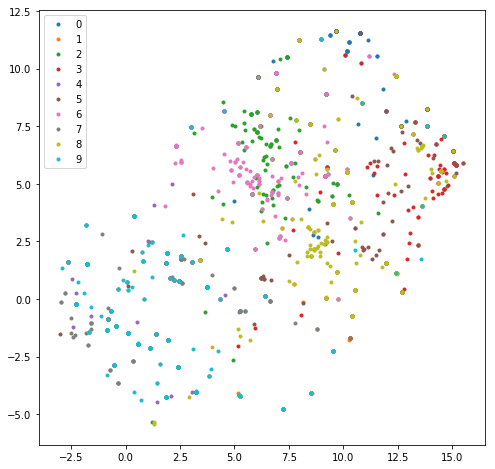

In [384]:
# That plot is just for my own reference 
plt.gcf().set_size_inches(8,8)
chosen_ptsne = 2
legend_list = list()
for l in set(sorted(labels_mnist)):
    plt.scatter(ptsne_y[chosen_ptsne][labels_mnist == l,0], ptsne_y[chosen_ptsne][labels_mnist == l,1], marker = '.', alpha=1.0)
    legend_list.append(str(l))
#plt.title("MNIST Dataset - TSNE visualization")
#plt.tight_layout()
plt.legend(legend_list)
plt.show()
#plt.scatter(res1['mapped_train_X'][:,0], res1['mapped_train_X'][:,1], c='gray',marker='.')

In [385]:
ptsne_y[chosen_ptsne].shape

(2500, 2)

## Summary

Here we produce summary table, that we can just copy/paste in LaTeX article.

In [466]:
print('''\\begin{table*} \caption{Cluster attribution test: methods comparison}  \label{tab_cluster_methods_comparison}
    \\begin{tabular}{| m{0.42\\textwidth} | m{0.13\\textwidth} | m{0.15\\textwidth} | m{0.15\\textwidth} |}
        \\hline
            \\textbf{Method}
            & \\textbf{Accuracy}
            & \\textbf{Distance Percentile}
            & \\textbf{KL Divergence}
        \\\\ \\hline''')

initial_kl_divergence, _ = lion_tsne.kl_divergence_and_gradient(y=dTSNE_mnist.Y, p_matrix=dTSNE_mnist.P_matrix)

print('\t\\textbf{Baseline} & %.2f\\%% & - & %.5f'%(baseline_accuracy*100, initial_kl_divergence))
print('\t\\\\ \\hline')

for j in range(len(rbf_method_results)):
    print('\t %s & %.2f\\%% & %.3f & %.5f'%(rbf_method_list[j], rbf_accuracy[j]*100, rbf_distance_percentiles[j], rbf_avg_kl[j]) )
    print('\t\\\\ \\hline')
    
for j in range(len(idw_method_results)):
    print('\t %s & %.2f\\%% & %.3f & %.5f'%(idw_method_list[j], idw_accuracy[j]*100, idw_distance_percentiles[j], idw_avg_kl[j]) )
    print('\t\\\\ \\hline')

for j in range(len(gd_method_results)):
    print('\t GD - %s & %.2f\\%% & %.3f & %.5f'%(gd_method_list[j], gd_accuracy[j]*100, gd_distance_percentiles[j], gd_avg_kl[j]) )
    print('\t\\\\ \\hline')

for j in range(len(nn_method_results)):
    print('\t %s & %.2f\\%% & %.3f & %.5f'%(nn_method_list[j], nn_accuracy[j]*100, nn_distance_percentiles[j], nn_avg_kl[j]) )
    print('\t\\\\ \\hline')

for j in range(len(lion_method_results)):
    print('\t \\textbf{%s} - %s & \\textbf{%.2f\\%%} & \\textbf{%.3f} & \\textbf{%.5f}'%
          (lion_method_list[j].split(";")[0], ';'.join(lion_method_list[j].split(";")[1:]), lion_accuracy[j]*100, lion_distance_percentiles[j], lion_avg_kl[j]) )
    print('\t\\\\ \\hline')

print('''
    \\end{tabular}
\\end{table*}
''')

\begin{table*} \caption{Cluster attribution test: methods comparison}  \label{tab_cluster_methods_comparison}
    \begin{tabular}{| m{0.42\textwidth} | m{0.13\textwidth} | m{0.15\textwidth} | m{0.15\textwidth} |}
        \hline
            \textbf{Method}
            & \textbf{Accuracy}
            & \textbf{Distance Percentile}
            & \textbf{KL Divergence}
        \\ \hline
	\textbf{Baseline} & 87.59\% & - & 1.11688
	\\ \hline
	 RBF - Multiquadric & 73.84\% & 53.548 & 1.11909
	\\ \hline
	 RBF - Gaussian & 73.78\% & 55.081 & 1.11907
	\\ \hline
	 RBF - Inverse Multiquadric & 74.30\% & 53.226 & 1.11899
	\\ \hline
	 RBF - Linear & 70.93\% & 52.659 & 1.11908
	\\ \hline
	 RBF - Cubic & 73.49\% & 53.974 & 1.11909
	\\ \hline
	 RBF - Quintic & 67.44\% & 61.672 & 1.11960
	\\ \hline
	 RBF - Thin Plate & 72.83\% & 53.141 & 1.11903
	\\ \hline
	 IDW - Power 1 & 8.92\% & 65.853 & 1.12220
	\\ \hline
	 IDW - Power 10 & 83.73\% & 25.170 & 1.11819
	\\ \hline
	 IDW - Power 20 & 87.88\% & 4.845 & 

In [467]:
print('''\\begin{table*}\\caption{Outliers test: methods comparison} \\label{tab_outliers_methods_comparison}
    \\begin{tabular}{| m{0.39\\textwidth} | m{0.15\\textwidth} | m{0.16\\textwidth} | m{0.15\\textwidth} |}
        \\hline
            \\textbf{Method}
            & \\textbf{Distance Percentile}
            & \\textbf{Distance}
            & \\textbf{KL Divergence}
        \\\\ \\hline''')

initial_kl_divergence, _ = lion_tsne.kl_divergence_and_gradient(y=dTSNE_mnist.Y, p_matrix=dTSNE_mnist.P_matrix)

print('\t\\textbf{Baseline} & - & - & %.5f'%(initial_kl_divergence))
print('\t\\\\ \\hline')

for j in range(len(rbf_outliers_results)):
    print('\t %s & %.3f & %.3f & %.5f'%(rbf_method_list[j], rbf_outliers_distance_percentiles[j],
                                        rbf_outliers_distances[j], rbf_avg_outliers_kl[j]) )
    print('\t\\\\ \\hline')
    
for j in range(len(idw_method_results)):
    print('\t %s & %.3f & %.3f &%.5f'%(idw_method_list[j], idw_outliers_distance_percentiles[j],
                                       idw_outliers_distances[j], idw_avg_outliers_kl[j]) )
    print('\t\\\\ \\hline')

for j in range(len(gd_method_results)):
    print('\t GD - %s & %.3f & %.3f & %.5f'%(gd_method_list[j], gd_outliers_distance_percentiles[j],
                                             gd_outliers_distances[j], gd_avg_outliers_kl[j]) )
    print('\t\\\\ \\hline')

for j in range(len(nn_method_results)):
    print('\t %s & %.3f & %.3f &%.5f'%(nn_method_list[j], nn_outliers_distance_percentiles[j],
                                       nn_outliers_distances[j], nn_avg_outliers_kl[j]) )
    print('\t\\\\ \\hline')

for j in range(len(lion_method_results)):
    print('\t \\textbf{%s} - %s & \\textbf{%.3f} & \\textbf{%.3f} &\\textbf{%.5f}'%
          (lion_method_list[j].split(";")[0], lion_method_list[j].split(";")[1], lion_outliers_distance_percentiles[j],
           lion_outliers_distances[j], lion_avg_outliers_kl[j]) )
    print('\t\\\\ \\hline')

print('''
    \\end{tabular}
\\end{table*}
''')

\begin{table*}\caption{Outliers test: methods comparison} \label{tab_outliers_methods_comparison}
    \begin{tabular}{| m{0.39\textwidth} | m{0.15\textwidth} | m{0.16\textwidth} | m{0.15\textwidth} |}
        \hline
            \textbf{Method}
            & \textbf{Distance Percentile}
            & \textbf{Distance}
            & \textbf{KL Divergence}
        \\ \hline
	\textbf{Baseline} & - & - & 1.11688
	\\ \hline
	 RBF - Multiquadric & 78.785 & 4.372 & 1.12235
	\\ \hline
	 RBF - Gaussian & 84.765 & 6.597 & 1.12271
	\\ \hline
	 RBF - Inverse Multiquadric & 77.950 & 4.175 & 1.12245
	\\ \hline
	 RBF - Linear & 83.454 & 4.844 & 1.12235
	\\ \hline
	 RBF - Cubic & 74.596 & 3.882 & 1.12239
	\\ \hline
	 RBF - Quintic & 99.757 & 98.044 & 1.12383
	\\ \hline
	 RBF - Thin Plate & 79.766 & 4.551 & 1.12233
	\\ \hline
	 IDW - Power 1 & 55.687 & 1.486 &1.12236
	\\ \hline
	 IDW - Power 10 & 41.728 & 1.289 &1.12256
	\\ \hline
	 IDW - Power 20 & 72.443 & 3.236 &1.12233
	\\ \hline
	 IDW - Power 27.9 

## Lettter Test - Obsolete

Replaced with outlier test.

First let's get those images

In [ ]:
from scipy import ndimage
from scipy import misc
#from PIL import Image
#import string

In [ ]:
letter_picks = ['A','C','E','F','G','H','R','V','W','X']
letter_examples = np.zeros((len(letter_picks), 28*28))
for i in range(len(letter_picks)):
    x = letter_picks[i]
    img = misc.imread('letters/'+x+'.png')
    img = np.mean(img,-1)
    img = (255-img)/255
    letter_examples[i,:] = img.reshape((-1,28*28))

In [ ]:
f, ax = plt.subplots(1, len(letter_examples))
for i in range(len(letter_examples)):
    ax[i].imshow(letter_examples[i,:].reshape(28,28), cmap='gray_r')
    ax[i].axes.get_yaxis().set_visible(False)
    ax[i].axes.get_yaxis().set_visible(False)
    ax[i].set_xticks([])
plt.show(f)

In [ ]:
letters_transformed = mnist_pca.transform(letter_examples)

In [ ]:
letters_y_multiquadric = emb_mnist_multiquadric(letters_transformed)
letters_y_cubic = emb_mnist_cubic(letters_transformed)
letters_y_linear = emb_mnist_linear(letters_transformed)
letters_y_quintic = emb_mnist_quintic(letters_transformed)
letters_y_gaussian = emb_mnist_gaussian(letters_transformed)
letters_y_inverse = emb_mnist_inverse(letters_transformed)
letters_y_thin_plate = emb_mnist_thin_plate(letters_transformed)
letters_y_idw2 = emb_mnist_idw2(letters_transformed)
letters_y_idw20 = emb_mnist_idw20(letters_transformed)
letters_y_idw10 = emb_mnist_idw10(letters_transformed)
letters_y_idwhalf = emb_mnist_idwhalf(letters_transformed)
letters_y_idw1 = emb_mnist_idw1(letters_transformed)

In [ ]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20)
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
h1 = ax.scatter(letters_y_multiquadric[:, 0], letters_y_multiquadric[:, 1], c='red', zorder=1, label=None, marker='.')
h2 = ax.scatter(letters_y_gaussian[:, 0], letters_y_gaussian[:, 1], c='blue', zorder=1, label=None, marker='.')
h3 = ax.scatter(letters_y_inverse[:, 0], letters_y_inverse[:, 1], c='green', zorder=1, label=None, marker='.')
h4 = ax.scatter(letters_y_linear[:, 0], letters_y_linear[:, 1], c='purple', zorder=1, label=None, marker='.')
h5 = ax.scatter(letters_y_cubic[:, 0], letters_y_cubic[:, 1], c='cyan', zorder=1, label=None, marker='.')
h6 = ax.scatter(letters_y_quintic[:, 0], letters_y_quintic[:, 1], c='orange', zorder=1, label=None, marker='.')
h7 = ax.scatter(letters_y_thin_plate[:,0], letters_y_thin_plate[:,1], c='pink', marker='.', zorder=3,alpha=0.9)

ax.legend([h1,h2,h3,h4,h5,h6,h7], ["RBF - Multiquadric","RBF - Gaussian",
                        "RBF - Inverse Quadratic","RBF - Linear",'RBF - Cubic','RBF - Quintic',
                        'RBF - Thin Plate'])

f.tight_layout()
plt.savefig("Figures/letter-test-RBF.png")
plt.show(f)

In [ ]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20)
ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
h1 = ax.scatter(letters_y_idwhalf[:, 0], letters_y_idwhalf[:, 1], c='red', zorder=1, label=None, marker='.')
h2 = ax.scatter(letters_y_idw1[:, 0], letters_y_idw1[:, 1], c='blue', zorder=1, label=None, marker='.')
h3 = ax.scatter(letters_y_idw2[:, 0], letters_y_idw2[:, 1], c='green', zorder=1, label=None, marker='.')
h4 = ax.scatter(letters_y_idw10[:, 0], letters_y_idw10[:, 1], c='purple', zorder=1, label=None, marker='.')
h5 = ax.scatter(letters_y_idw20[:, 0], letters_y_idw20[:, 1], c='cyan', zorder=1, label=None, marker='.')

ax.legend([h1,h2,h3,h4,h5], ["IDW - Power 1/2","IDW - Power 1",
                        "IDW - Power 2","IDW - Power 10", "IDW - Power 20"])
f.tight_layout()
plt.savefig("Figures/letter-test-IDW.png")
plt.show(f)

In [ ]:
letters_y_400_relu = model_400_relu.predict(letters_transformed)
letters_y_400_tanh = model_400_tanh.predict(letters_transformed)
letters_y_400_400_relu = model_400_400_relu.predict(letters_transformed)
letters_y_400_400_tanh = model_400_400_tanh.predict(letters_transformed)

In [ ]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20))     

#['A','C','E','F','G','H','R','V','W','X']
#see_letters = [True]*len(letter_picks)
see_letters = [False]*len(letter_picks)
see_letters[5] = True

ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
h1 = ax.scatter(letters_y_400_relu[see_letters,0],
                letters_y_400_relu[see_letters,1], c='blue', marker='.',zorder=3,alpha=0.9)
h2 = ax.scatter(letters_y_400_tanh[see_letters,0],
                letters_y_400_tanh[see_letters,1], c='green', marker='.',zorder=3,alpha=0.9)
h3 = ax.scatter(letters_y_400_400_relu[see_letters,0],
                letters_y_400_400_relu[see_letters,1], c='cyan', marker='.',zorder=3,alpha=0.9)
h4 = ax.scatter(letters_y_400_400_tanh[see_letters,0],
                letters_y_400_400_tanh[see_letters,1], c='orange', marker='.',zorder=3,alpha=0.9)

ax.legend([h1,h2,h3,h4], ['400; ReLu','400; tanh','400+400; ReLu','400+400; tanh'])
f.tight_layout()
plt.savefig("Figures/letter-test-NN.png")
plt.show(f)

# Letter A is coutned close to 1, 400 ReLu - close to 8
# Letter C is counted close to 0, 400 ReLu - correct outlier.
# Letter E all counted close to 3 (though all but 400 tanh - correctly outlier)
# Letter F 400-tanh & 400+400 ReLu - correct outlier; 400+400 tanh - 2, 400 ReLu - close to 8
# Letter G 400-tanh & 400+400 ReLu - correct outlier; 400+400 tanh - 2, 400 ReLu - close to 3
# Letter H scattered, only 400 tanh correctly detected as outlier
# 

In [ ]:
letters_y_400_relu

In [ ]:
# Evaluation of neural network models is moved to another file

In [ ]:
#keras_model_characteristics

In [314]:
import pandas as pd
nn_models_evaluation = pd.read_csv("nn-models-evaluation.csv")
ind = nn_models_evaluation.Activation=='relu'
nn_models_evaluation.loc[ind,"Activation"] = 'ReLu'
nn_models_evaluation#[nn_models_evaluation.Nodes==500]

Nodes  Layers  Dropout Activation   TrainLoss    TestLoss  Epochs
0      100       1     0.00       ReLu   11.706555  665.287442    5000
1      150       1     0.00       ReLu    0.508716  702.102460    5000
2      200       1     0.00       ReLu    0.293785  478.602673    5000
3      250       1     0.00       ReLu    0.231072  455.234647    5000
4      300       1     0.00       ReLu    0.415545  409.690183    5000
5      350       1     0.00       ReLu    0.267100  411.396135    5000
6      400       1     0.00       ReLu    0.251606  388.503367    5000
7      450       1     0.00       ReLu    0.363875  389.145685    5000
8      100       1     0.10       ReLu   82.961028  401.284249    5000
9      150       1     0.10       ReLu   52.577765  401.955758    5000
10     200       1     0.10       ReLu   30.837420  383.446973    5000
11     250       1     0.10       ReLu   23.996509  391.295530    5000
12     300       1     0.10       ReLu   17.933667  392.075746    5000
13     350       1     0.10       ReLu   14.643882  397.217862    5000
14     400       1     0.10       ReLu   10.395198  405.013896    5000
15     450       1     0.10       ReLu    9.445267  395.132004    5000
16     100       1     0.25       ReLu  175.857040  379.064807    5000
17     150       1     0.25       ReLu  110.575466  364.021195    5000
18     200       1     0.25       ReLu   83.293112  371.224608    5000
19     250       1     0.25       ReLu   62.362609  377.683891    5000
20     300       1     0.25       ReLu   45.826614  378.686657    5000
21     350       1     0.25       ReLu   39.774107  370.977705    5000
22     400       1     0.25       ReLu   30.101547  368.049956    5000
23     450       1     0.25       ReLu   26.384807  350.404013    5000
24     100       1     0.50       ReLu  403.260625  502.297230    5000
25     150       1     0.50       ReLu  309.377855  439.503901    5000
26     200       1     0.50       ReLu  249.749830  403.743252    5000
27     250       1     0.50       ReLu  208.807976  392.126744    5000
28     300       1     0.50       ReLu  169.731764  371.023538    5000
29     350       1     0.50       ReLu  145.446584  372.268024    5000
..     ...     ...      ...        ...         ...         ...     ...
466    900       2     0.00       tanh    0.020880  254.862354    5000
467    900       3     0.00       ReLu    0.021042  181.880526    5000
468    850       3     0.10       tanh    0.620957  192.973012    5000
469    650       3     0.25       tanh    1.176942  180.592974    5000
470    850       3     0.50       ReLu    2.517304  183.219075    5000
471    800       3     0.50       tanh    2.809532  156.102848    5000
472    850       3     0.50       tanh    2.912505  161.043660    5000
473    550       2     0.10       tanh    0.503012  241.926006    5000
474    600       2     0.10       tanh    0.413468  224.015413    5000
475    650       2     0.10       tanh    0.425041  226.590960    5000
476    700       2     0.10       tanh    0.396417  228.308989    5000
477    750       2     0.10       tanh    0.427336  222.639784    5000
478    800       2     0.10       tanh    0.400033  229.406033    5000
479    550       2     0.25       tanh    1.220436  225.111576    5000
480    600       2     0.25       tanh    1.008408  216.483791    5000
481    650       2     0.25       tanh    0.975876  217.956359    5000
482    700       2     0.25       tanh    0.877011  217.245108    5000
483    950       2     0.00       tanh    0.027987  253.603058    5000
484   1000       2     0.00       tanh    0.049147  249.535225    5000
485    850       2     0.10       tanh    0.410427  229.948616    5000
486    900       2     0.10       tanh    0.425761  225.594960    5000
487    950       2     0.10       tanh    0.402228  233.732979    5000
488    550       2     0.25       ReLu    0.910111  167.760757    5000
489    600       2     0.25       ReLu    0.893562  157.784569    5000
490    650       2     0.25  

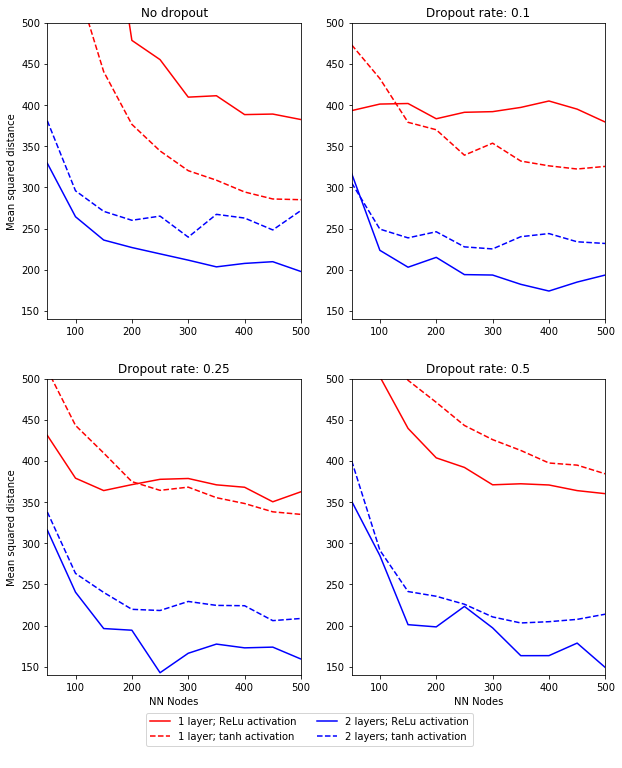

In [424]:
legend_list = list()
layers = [1,2,3]

dropout_rates = np.array([[0,0.1],[0.25,0.5]])

activation_linestyles = {'ReLu': "-", 'tanh': "--"}

layer_colors = {
    1 : 'red',
    2 : 'blue',
    #3 : 'green',
}

f,ax = plt.subplots(dropout_rates.shape[0], dropout_rates.shape[1])

f.set_size_inches(10,12)
for i in range(len(dropout_rates)):
    for j in range(len(dropout_rates[i])):
        legend_list = list() #We need only one
        lines_list = list()        
        d = dropout_rates[i][j]
        for l in layer_colors:           
            for a in activation_linestyles:             
                    legend_list.append(str(l)+" layer"+("s" if l>1 else "")+"; "+a+" activation")
                    subset = nn_models_evaluation[(nn_models_evaluation.Layers==l)&
                                                  (nn_models_evaluation.Activation==a)&
                                                  (nn_models_evaluation.Dropout==d)].sort_values(by=["Nodes"])
                    h, = ax[i][j].plot(subset.Nodes, subset.TestLoss, linestyle=activation_linestyles[a], c=layer_colors[l])
                    if j==0:
                        ax[i][j].set_ylabel("Mean squared distance")
                    if i==1:
                        ax[i][j].set_xlabel("NN Nodes")                        
                    lines_list.append(h)
        ax[i][j].set_xlim([50,500])
        ax[i][j].set_ylim([140,500])
        ax[i][j].set_title( "No dropout" if d==0 else ("Dropout rate: "+str(d)))
l = f.legend(lines_list, legend_list, ncol = 2, loc = 8, bbox_to_anchor=(0.43,0.02))
#f.tight_layout()
plt.show(f)
f.savefig('Figures/nn-grid-search.png', bbox_extra_artist = (l,),bbox_inches='tight')
plt.close(f)

In [364]:
nn_models_evaluation[(nn_models_evaluation.Nodes <= 500) & (nn_models_evaluation.Layers <= 1)].sort_values(by=["TestLoss"])[:30]

Nodes  Layers  Dropout Activation   TrainLoss    TestLoss  Epochs
212    500       1     0.00       tanh    0.092772  285.168819    5000
39     450       1     0.00       tanh    0.066943  286.043561    5000
38     400       1     0.00       tanh    0.053501  294.540025    5000
37     350       1     0.00       tanh    0.055757  308.840401    5000
36     300       1     0.00       tanh    0.040112  320.415736    5000
47     450       1     0.10       tanh    3.207939  322.427456    5000
217    500       1     0.10       tanh    2.878183  325.621826    5000
46     400       1     0.10       tanh    4.424975  326.285691    5000
45     350       1     0.10       tanh    5.665121  332.079543    5000
222    500       1     0.25       tanh   14.913113  335.100694    5000
55     450       1     0.25       tanh   17.531994  338.212193    5000
43     250       1     0.10       tanh   10.145809  339.231267    5000
35     250       1     0.00       tanh    0.046975  344.357637    5000
54     400       1     0.25       tanh   21.754223  348.308493    5000
23     450       1     0.25       ReLu   26.384807  350.404013    5000
44     300       1     0.10       tanh    7.168730  353.785827    5000
53     350       1     0.25       tanh   26.670130  355.369941    5000
207    500       1     0.50       ReLu   95.055431  360.251920    5000
202    500       1     0.25       ReLu   22.390844  362.571016    5000
31     450       1     0.50       ReLu  113.587200  363.970449    5000
17     150       1     0.25       ReLu  110.575466  364.021195    5000
51     250       1     0.25       tanh   45.082713  364.292104    5000
22     400       1     0.25       ReLu   30.101547  368.049956    5000
52     300       1     0.25       tanh   34.379566  368.175419    5000
42     200       1     0.10       tanh   15.540752  370.108381    5000
30     400       1     0.50       ReLu  128.684348  370.791408    5000
21     350       1     0.25       ReLu   39.774107  370.977705    5000
28     300       1     0.50       ReLu  169.731764  371.023538    5000
18     200       1     0.25       ReLu   83.293112  371.224608    5000
29     350       1     0.50       ReLu  145.446584  372.268024    5000

In [ ]:
np.random.seed(321)

#Let's build all possible combinations. Later we'll decide what to plot

letters_y_gd_transformed = np.zeros((len(letters_transformed), Y_mnist.shape[1]))
letters_y_gd_variance_recalc_transformed = np.zeros((len(letters_transformed), Y_mnist.shape[1]))
letters_y_gd_transformed_random = np.zeros((len(letters_transformed), Y_mnist.shape[1]))
letters_y_gd_variance_recalc_transformed_random = np.zeros((len(letters_transformed), Y_mnist.shape[1]))

letters_y_gd_early_exagg_transformed_random = np.zeros((len(letters_transformed), Y_mnist.shape[1]))
letters_y_gd_early_exagg_transformed = np.zeros((len(letters_transformed), Y_mnist.shape[1]))
letters_y_gd_variance_recalc_early_exagg_transformed_random = np.zeros((len(letters_transformed), Y_mnist.shape[1]))

for i in range(len(letters_transformed)):
    letter = picked_neighbors[i].reshape((1,-1))
    letters_y_gd_transformed[i,:] = dTSNE_mnist.transform(letter,y='closest',
                                                                   verbose=2,optimizer_kwargs={'early_exaggeration':None})
    letters_y_gd_variance_recalc_transformed[i,:] = dTSNE_mnist.transform(letter, keep_sigmas=False,y='closest',
                                                                   verbose=2,optimizer_kwargs={'early_exaggeration':None})
    
    #Let's pick random starts at any point. not necessary near the center.
    y_start = np.array([[
        np.random.uniform(np.min(Y_mnist[:,0]),np.max(Y_mnist[:,0])),
        np.random.uniform(np.min(Y_mnist[:,1]),np.max(Y_mnist[:,1]))
    ]])
    
    letters_y_gd_transformed_random[i,:] = dTSNE_mnist.transform(letter, y=y_start, #y='random',
                                                                   verbose=2,optimizer_kwargs={'early_exaggeration':None})
    letters_y_gd_variance_recalc_transformed_random[i,:] = dTSNE_mnist.transform(letter,
                                                                    keep_sigmas=False, y=y_start, #y='random',
                                                                    verbose=2,optimizer_kwargs={'early_exaggeration':None})
    letters_y_gd_early_exagg_transformed_random[i,:] = dTSNE_mnist.transform(letter,y=y_start, #y='random',
                                                                   verbose=2)
    letters_y_gd_early_exagg_transformed[i,:] = dTSNE_mnist.transform(letter, y='closest', verbose=2)
    
    letters_y_gd_variance_recalc_early_exagg_transformed_random[i,:] = dTSNE_mnist.transform(letter,y=y_start,
                                                                   verbose=2)

In [ ]:
legend_list = list()
f, ax = plt.subplots()
f.set_size_inches(6,6)
#f.set_size_inches(20,20))     

#['A','C','E','F','G','H','R','V','W','X']
see_letters = [True]*len(letter_picks)
#see_letters = [False]*len(letter_picks)
#see_letters[5] = True

ax.scatter(Y_mnist[:, 0], Y_mnist[:, 1], c= 'gray', zorder=1, label=None, marker='.')
h1 = ax.scatter(letters_y_gd_transformed[see_letters,0],
                letters_y_gd_transformed[see_letters,1], c='blue', marker='.',zorder=3,alpha=0.9)
h2 = ax.scatter(letters_y_gd_transformed_random[see_letters,0],
                letters_y_gd_transformed_random[see_letters,1], c='green', marker='.',zorder=3,alpha=0.9)
h3 = ax.scatter(letters_y_gd_early_exagg_transformed[see_letters,0],
                letters_y_gd_early_exagg_transformed[see_letters,1], c='cyan', marker='.',zorder=3,alpha=0.9)
h4 = ax.scatter(letters_y_gd_early_exagg_transformed_random[see_letters,0],
                letters_y_gd_early_exagg_transformed_random[see_letters,1], c='orange', marker='.',zorder=3,alpha=0.9)

ax.legend([h1,h2,h3,h4], [              r'Closest Y; no EE',
                                        r'Random Y; no EE',
                                        #r'Closest Y; new $\sigma$; no EE',
                                        #r'Random Y; new $\sigma$; no EE',                             
                                        r'Closest Y; EE',
                                        r'Random Y; EE',
                                        #r'Closest Y; new $\sigma$; EE',
                                        #r'Random Y; new $\sigma$; EE',
                            ])
f.tight_layout()

plt.savefig("Figures/letter-test-GD.png")
plt.show(f)

In [ ]:
# Letter test for GD